<a href="https://colab.research.google.com/github/NatP-dev/Case_06/blob/main/Daily_Interest_Rates_Data_Analysis_28052025_2040.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Daily Interest Rates**

#### **Author**: Group X

## **<font color='#474747'>0 - Imports**</font>



In [3]:
################################ LIBRARIES ########################
# -------------------------- Core Libraries -------------------------- #
import os
import pandas as pd
import re
from IPython.display import display
import numpy as np


# -------------------------- Plotting -------------------------- #
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from scipy.stats import zscore
import plotly.graph_objects as go
from collections import Counter
from collections import defaultdict


from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday, Easter, GoodFriday, EasterMonday
from datetime import date, timedelta
from dateutil.easter import easter




---
---
<br><br>
# **<font color='#000058'>Chapter 1: Data</font>**



## **<font color='#474747'>1.1 - Load All Data Files**

In [4]:
# Step 1: Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Step 2: Set the path to your folder containing the 31 CSV files
# Replace this path with the actual folder path inside your Drive
folder_path = '/content/drive/MyDrive/EMAS 14 Case 6/Data/Interest Rates/Daily'


In [6]:
# Step 3: Load all CSV files into a list of DataFrames
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Optional: Sort filenames to maintain a consistent order
csv_files.sort()

In [7]:
# Step 4: Read all CSV files
dataframes = []
for file in csv_files:
    full_path = os.path.join(folder_path, file)
    df = pd.read_csv(full_path)
    dataframes.append(df)

# Now `dataframes` is a list of 31 DataFrames (one per CSV)
# Example: access the first DataFrame
print(dataframes[0].head())

          Unnamed: 0 BBSIS.D.I.ZST.ZI.EUR.S1311.B.A604.R005X.R.A.A._Z._Z.A  \
0                NaN  Term structure of interest rates on listed Fed...      
1            Comment  Monatsendstandsreihe: WZ9807. Bis Juli 1997 li...      
2           Decimals                                                  2      
3   Time format code                                                P1D      
4  Unit (in english)                                            percent      

  BBSIS.D.I.ZST.ZI.EUR.S1311.B.A604.R005X.R.A.A._Z._Z.A_FLAGS  
0                                                NaN           
1                                                NaN           
2                                                NaN           
3                                                NaN           
4                                                NaN           


In [8]:
# Loop for files into their own dataframes
for i in range(len(dataframes)):
    print(f"DataFrame {i}: {csv_files[i]}")

DataFrame 0: daily-term-structure-spot-interest-rate-R005X.csv
DataFrame 1: daily-term-structure-spot-interest-rate-R01XX.csv
DataFrame 2: daily-term-structure-spot-interest-rate-R02XX.csv
DataFrame 3: daily-term-structure-spot-interest-rate-R03XX.csv
DataFrame 4: daily-term-structure-spot-interest-rate-R04XX.csv
DataFrame 5: daily-term-structure-spot-interest-rate-R05XX.csv
DataFrame 6: daily-term-structure-spot-interest-rate-R06XX.csv
DataFrame 7: daily-term-structure-spot-interest-rate-R07XX.csv
DataFrame 8: daily-term-structure-spot-interest-rate-R08XX.csv
DataFrame 9: daily-term-structure-spot-interest-rate-R09XX.csv
DataFrame 10: daily-term-structure-spot-interest-rate-R10XX.csv
DataFrame 11: daily-term-structure-spot-interest-rate-R11XX.csv
DataFrame 12: daily-term-structure-spot-interest-rate-R12XX.csv
DataFrame 13: daily-term-structure-spot-interest-rate-R13XX.csv
DataFrame 14: daily-term-structure-spot-interest-rate-R14XX.csv
DataFrame 15: daily-term-structure-spot-interest-r

### **<font color='#474747'>*1.1 - Format Dataframes Consistently*</font>**
What was done to format the files:
1. Start at row 11
2. Have no headers
3. Rename columns:
  * Column 1: Date (convert to datetime)
  * Column 2: Value (float, 2 decimals)
  * Column 3: Info message like "No value available"
4. Add a new column FileReferenceName with the filename.



In [9]:
# Step 5: Read all CSVs from row 11 onward, format consistently
dataframes = []

for file in csv_files:
    full_path = os.path.join(folder_path, file)

    df = pd.read_csv(full_path, skiprows=10, header=None, dtype=str, encoding='utf-8')
    df.columns = ["Date", "Interest Rate", "Information No IR"]

    # Clean and parse columns
    df["Date"] = df["Date"].str.strip()
    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d", errors="coerce")
    df["Interest Rate"] = pd.to_numeric(df["Interest Rate"], errors="coerce")
    df["FileReferenceName"] = file

    dataframes.append(df)

# Adjust maturity assignment, with special handling for R005X
for df in dataframes:
    file_name = df["FileReferenceName"].iloc[0]

    if "R005X" in file_name:
        df["Maturity"] = 0.5
    else:
        match = re.search(r"R(\d{2})X", file_name)
        if match:
            df["Maturity"] = int(match.group(1))  # e.g., R01XX → 1
        else:
            df["Maturity"] = None  # fallback


In [10]:
# CHECK DATA MANUALLY (Ensure alignment with excels)
# Head
display(dataframes[0].head(5))

# Tail
display(dataframes[0].tail(5))

Date  Interest Rate   Information No IR  \
0 1997-08-01            NaN  No value available   
1 1997-08-02            NaN  No value available   
2 1997-08-03            NaN  No value available   
3 1997-08-04            NaN  No value available   
4 1997-08-05            NaN  No value available   

                                   FileReferenceName  Maturity  
0  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
1  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
2  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
3  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
4  daily-term-structure-spot-interest-rate-R005X.csv       0.5

Date  Interest Rate   Information No IR  \
10145 2025-05-11            NaN  No value available   
10146 2025-05-12           1.93                 NaN   
10147 2025-05-13           1.95                 NaN   
10148 2025-05-14           1.94                 NaN   
10149 2025-05-15           1.93                 NaN   

                                       FileReferenceName  Maturity  
10145  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
10146  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
10147  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
10148  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
10149  daily-term-structure-spot-interest-rate-R005X.csv       0.5

## **<font color='#474747'>1.2 - Data Pre-processing**

In [11]:
### INFORMATION ON DATA PER FILE
# Collect info summary per DataFrame
summary_rows = []

for df in dataframes:
    maturity = df["Maturity"].iloc[0]  # Use the already existing numeric Maturity value
    row = {"Maturity": maturity, "Rows": len(df)}

    for col in df.columns:
        row[f"{col} | Non-Null"] = df[col].notnull().sum()
        row[f"{col} | Dtype"] = str(df[col].dtype)

    summary_rows.append(row)

# Create summary table
summary_df = pd.DataFrame(summary_rows)
summary_df.set_index("Maturity", inplace=True)
summary_df = summary_df.sort_index()

# Display in notebook (nicely formatted)
from IPython.display import display
display(summary_df)


Rows  Date | Non-Null    Date | Dtype  Interest Rate | Non-Null  \
Maturity                                                                     
0.5       10150            10150  datetime64[ns]                      7048   
1.0       10150            10150  datetime64[ns]                      7048   
2.0       10150            10150  datetime64[ns]                      7048   
3.0       10150            10150  datetime64[ns]                      7048   
4.0       10150            10150  datetime64[ns]                      7048   
5.0       10150            10150  datetime64[ns]                      7048   
6.0       10150            10150  datetime64[ns]                      7048   
7.0       10150            10150  datetime64[ns]                      7048   
8.0       10150            10150  datetime64[ns]                      7048   
9.0       10150            10150  datetime64[ns]                      7048   
10.0      10150            10150  datetime64[ns]                      7048   
11.0      10149            10149  datetime64[ns]                      7048   
12.0      10149            10149  datetime64[ns]                      7048   
13.0      10149            10149  datetime64[ns]                      7048   
14.0      10149            10149  datetime64[ns]                      7048   
15.0      10149            10149  datetime64[ns]                      7048   
16.0      10149            10149  datetime64[ns]                      7048   
17.0      10149            10149  datetime64[ns]                      7048   
18.0      10149            10149  datetime64[ns]                      7048   
19.0      10149            10149  datetime64[ns]                      7048   
20.0      10149            10149  datetime64[ns]                      7048   
21.0       9053             9053  datetime64[ns]                      6295   
22.0       9053             9053  datetime64[ns]                      6295   
23.0       9053             9053  datetime64[ns]                      6295   
24.0       9053             9053  datetime64[ns]                      6295   
25.0       9053             9053  datetime64[ns]                      6295   
26.0       9053             9053  datetime64[ns]                      6295   
27.0       9053             9053  datetime64[ns]                      6295   
28.0       9053             9053  datetime64[ns]                      6295   
29.0       9053             9053  datetime64[ns]                      6295   
30.0       9053             9053  datetime64[ns]                      6295   

         Interest Rate | Dtype  Information No IR | Non-Null  \
Maturity                                                       
0.5                    float64                          3102   
1.0                    float64                          3102   
2.0                    float64                          3102   
3.0                    float64                          3102   
4.0                    float64                          3102   
5.0                    float64                          3102   
6.0                    float64                          3102   
7.0                    float64                          3102   
8.0                    float64                          3102   
9.0                    float64                          3102   
10.0                   float64                          3102   
11.0                   float64                          3101   
12.0                   float64                          3101   
13.0                   float64                          3101   
14.0                   float64                          3101   
15.0                   float64                          3101   
16.0                   float64                          3101   
17.0                   float64                          3101   
18.0                   float64                          3101   
19.0                   float64                          3101   
20.0                   float

In [12]:
### DESCRIBE() DATA
for i, df in enumerate(dataframes):
    # Get file/maturity label
    file_name = df["FileReferenceName"].iloc[0]
    maturity = re.search(r"(R\d+X)", file_name).group(1)

    print(f"\n--- Summary Statistics for {maturity} ({file_name}) ---")
    print(df.describe())



--- Summary Statistics for R005X (daily-term-structure-spot-interest-rate-R005X.csv) ---
                                Date  Interest Rate  Maturity
count                          10150    7048.000000   10150.0
mean   2011-06-23 11:59:59.999999744       1.520241       0.5
min              1997-08-01 00:00:00      -0.980000       0.5
25%              2004-07-12 06:00:00      -0.250000       0.5
50%              2011-06-23 12:00:00       1.655000       0.5
75%              2018-06-03 18:00:00       3.322500       0.5
max              2025-05-15 00:00:00       5.120000       0.5
std                              NaN       1.833644       0.0

--- Summary Statistics for R01X (daily-term-structure-spot-interest-rate-R01XX.csv) ---
                                Date  Interest Rate  Maturity
count                          10150    7048.000000   10150.0
mean   2011-06-23 11:59:59.999999744       1.564343       1.0
min              1997-08-01 00:00:00      -0.970000       1.0
25%            

In [13]:
### SUMMARIZE DESCRIBE() OF INTEREST RATE VALUES INTO ONE TABLE
summary_rows = []

for df in dataframes:
    maturity = df["Maturity"].iloc[0]  # Use numeric Maturity directly

    # Get describe for Interest Rate only
    stats = df[["Interest Rate"]].describe().T  # Transpose to get single row per maturity
    stats["Maturity"] = maturity
    summary_rows.append(stats)

# Combine all rows
summary_df = pd.concat(summary_rows)
summary_df.set_index("Maturity", inplace=True)

# Round numeric output
summary_df = summary_df.round(4)

# Display as a table
from IPython.display import display
display(summary_df)


count    mean     std   min    25%    50%     75%   max
Maturity                                                          
0.5       7048.0  1.5202  1.8336 -0.98 -0.250  1.655  3.3225  5.12
1.0       7048.0  1.5643  1.8420 -0.97 -0.250  1.805  3.3100  5.23
2.0       7048.0  1.6612  1.8636 -1.02 -0.220  1.890  3.2800  5.32
3.0       7048.0  1.7815  1.8852 -1.02 -0.160  1.990  3.4325  5.33
4.0       7048.0  1.9147  1.9001 -1.00 -0.070  2.170  3.5800  5.35
5.0       7048.0  2.0511  1.9078 -0.98  0.050  2.320  3.7000  5.42
6.0       7048.0  2.1841  1.9099 -0.95  0.190  2.430  3.8400  5.48
7.0       7048.0  2.3099  1.9085 -0.93  0.330  2.480  3.9500  5.61
8.0       7048.0  2.4264  1.9054 -0.91  0.450  2.550  4.0700  5.73
9.0       7048.0  2.5329  1.9020 -0.88  0.570  2.660  4.1700  5.84
10.0      7048.0  2.6290  1.8985 -0.85  0.680  2.760  4.2700  5.97
11.0      7048.0  2.7151  1.8958 -0.82  0.790  2.850  4.3600  6.08
12.0      7048.0  2.7918  1.8938 -0.80  0.870  2.910  4.4300  6.18
13.0      7048.0  2.8597  1.8926 -0.77  0.960  2.980  4.5000  6.28
14.0      7048.0  2.9194  1.8921 -0.74  1.030  3.040  4.5600  6.36
15.0      7048.0  2.9718  1.8925 -0.72  1.090  3.090  4.6200  6.43
16.0      7048.0  3.0176  1.8933 -0.69  1.150  3.130  4.6700  6.50
17.0      7048.0  3.0573  1.8948 -0.67  1.200  3.165  4.7200  6.55
18.0      7048.0  3.0917  1.8966 -0.65  1.240  3.190  4.7600  6.60
19.0      7048.0  3.1213  1.8988 -0.64  1.280  3.205  4.8000  6.65
20.0      7048.0  3.1466  1.9015 -0.62  1.310  3.220  4.8300  6.69
21.0      6295.0  2.8765  1.7997 -0.61  1.170  2.800  4.4400  5.98
22.0      6295.0  2.8924  1.8002 -0.60  1.190  2.800  4.4500  6.03
23.0      6295.0  2.9053  1.8009 -0.58  1.215  2.790  4.4600  6.07
24.0      6295.0  2.9154  1.8016 -0.57  1.240  2.790  4.4700  6.10
25.0      6295.0  2.9231  1.8024 -0.56  1.250  2.770  4.4700  6.13
26.0      6295.0  2.9287  1.8033 -0.55  1.270  2.750  4.4700  6.17
27.0      6295.0  2.9324  1.8043 -0.54  1.290  2.740  4.4750  6.19
28.0      6295.0  2.9347  1.8054 -0.52  1.300  2.720  4.4800  6.22
29.0      6295.0  2.9354  1.8067 -0.51  1.310  2.700  4.4700  6.25
30.0      6295.0  2.9350  1.8081 -0.50  1.330  2.680  4.4700  6.27

In [14]:
# Render the first DataFrame in a pretty HTML table (good for Colab)
dataframes[0]

Date  Interest Rate   Information No IR  \
0     1997-08-01            NaN  No value available   
1     1997-08-02            NaN  No value available   
2     1997-08-03            NaN  No value available   
3     1997-08-04            NaN  No value available   
4     1997-08-05            NaN  No value available   
...          ...            ...                 ...   
10145 2025-05-11            NaN  No value available   
10146 2025-05-12           1.93                 NaN   
10147 2025-05-13           1.95                 NaN   
10148 2025-05-14           1.94                 NaN   
10149 2025-05-15           1.93                 NaN   

                                       FileReferenceName  Maturity  
0      daily-term-structure-spot-interest-rate-R005X.csv       0.5  
1      daily-term-structure-spot-interest-rate-R005X.csv       0.5  
2      daily-term-structure-spot-interest-rate-R005X.csv       0.5  
3      daily-term-structure-spot-interest-rate-R005X.csv       0.5  
4      daily-term-structure-spot-interest-rate-R005X.csv       0.5  
...                                                  ...       ...  
10145  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
10146  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
10147  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
10148  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
10149  daily-term-structure-spot-interest-rate-R005X.csv       0.5  

[10150 rows x 5 columns]


### **<font color='#474747'>*1.2.1 - General Data Checks*</font>**


#### **Date Column**

In [15]:
#-------------------------------------   MISSING DATA CHECKS - Date Column -------------------------------------#
### DATE COLUMN(S)
# Prepare results list
date_analysis = []

for df in dataframes:
    # Use Maturity column directly
    maturity = df["Maturity"].iloc[0] if "Maturity" in df.columns else None

    # Get date column
    date_col = df["Date"]

    # Calculate required values
    min_date = date_col.min()
    max_date = date_col.max()
    total_rows = len(df)
    missing_count = date_col.isnull().sum()
    missing_pct = (missing_count / total_rows) * 100 if total_rows > 0 else 0

    # Incorrectly formatted = non-null values that are not datetime
    incorrectly_formatted = date_col.apply(lambda x: not isinstance(x, pd.Timestamp) and pd.notnull(x)).sum()

    # Calculate number of days between min and max date
    date_range_days = (max_date - min_date).days if pd.notnull(min_date) and pd.notnull(max_date) else None

    date_analysis.append({
        "Maturity": maturity,
        "Minimum Date": min_date,
        "Maximum Date": max_date,
        "Date Range (Days)": date_range_days,
        "Count Rows": total_rows,
        "Count Missing Dates": missing_count,
        "% Missing Dates": round(missing_pct, 2),
        "Incorrectly Formatted Data": incorrectly_formatted
    })

# Create summary DataFrame
date_summary_df = pd.DataFrame(date_analysis)
date_summary_df.set_index("Maturity", inplace=True)
date_summary_df.sort_index(inplace=True)

# Display the result
print("Date Column Analysis by Maturity")  # i.e. per file
display(date_summary_df)


Date Column Analysis by Maturity


Minimum Date Maximum Date  Date Range (Days)  Count Rows  \
Maturity                                                            
0.5        1997-08-01   2025-05-15              10149       10150   
1.0        1997-08-01   2025-05-15              10149       10150   
2.0        1997-08-01   2025-05-15              10149       10150   
3.0        1997-08-01   2025-05-15              10149       10150   
4.0        1997-08-01   2025-05-15              10149       10150   
5.0        1997-08-01   2025-05-15              10149       10150   
6.0        1997-08-01   2025-05-15              10149       10150   
7.0        1997-08-01   2025-05-15              10149       10150   
8.0        1997-08-01   2025-05-15              10149       10150   
9.0        1997-08-01   2025-05-15              10149       10150   
10.0       1997-08-01   2025-05-15              10149       10150   
11.0       1997-08-02   2025-05-15              10148       10149   
12.0       1997-08-02   2025-05-15              10148       10149   
13.0       1997-08-02   2025-05-15              10148       10149   
14.0       1997-08-02   2025-05-15              10148       10149   
15.0       1997-08-02   2025-05-15              10148       10149   
16.0       1997-08-02   2025-05-15              10148       10149   
17.0       1997-08-02   2025-05-15              10148       10149   
18.0       1997-08-02   2025-05-15              10148       10149   
19.0       1997-08-02   2025-05-15              10148       10149   
20.0       1997-08-02   2025-05-15              10148       10149   
21.0       2000-08-02   2025-05-15               9052        9053   
22.0       2000-08-02   2025-05-15               9052        9053   
23.0       2000-08-02   2025-05-15               9052        9053   
24.0       2000-08-02   2025-05-15               9052        9053   
25.0       2000-08-02   2025-05-15               9052        9053   
26.0       2000-08-02   2025-05-15               9052        9053   
27.0       2000-08-02   2025-05-15               9052        9053   
28.0       2000-08-02   2025-05-15               9052        9053   
29.0       2000-08-02   2025-05-15               9052        9053   
30.0       2000-08-02   2025-05-15               9052        9053   

          Count Missing Dates  % Missing Dates  Incorrectly Formatted Data  
Maturity                                                                    
0.5                         0              0.0                           0  
1.0                         0              0.0                           0  
2.0                         0              0.0                           0  
3.0                         0              0.0                           0  
4.0                         0              0.0                           0  
5.0                         0              0.0                           0  
6.0                         0              0.0                           0  
7.0                         0              0.0                           0  
8.0                         0              0.0                           0  
9.0                         0              0.0                           0  
10.0                        0              0.0                           0  
11.0                        0              0.0                           0  
12.0                        0              0.0                           0  
13.0                        0              0.0                           0  
14.0                        0              0.0                           0  
15.0                        0              0.0                           0  
16.0                        0              0.0                           0  
17.0                        0              0.0                           0  
18.0                        0              0.0                           0  
19.0                        0              0.0                           0  
20.0                        0        

#### **Interest Rate Column**

In [16]:
#-------------------------------------   MISSING DATA CHECKS - Interest Rate Column -------------------------------------#
### INTEREST RATE COLUMN(S)
# Prepare results list
ir_analysis = []

for df in dataframes:
    # Use Maturity column directly
    maturity = df["Maturity"].iloc[0] if "Maturity" in df.columns else None

    # Get interest rate column
    ir_col = df["Interest Rate"]

    # Basic statistics
    min_ir = ir_col.min()
    max_ir = ir_col.max()
    ir_range = max_ir - min_ir if pd.notnull(min_ir) and pd.notnull(max_ir) else None
    total_rows = len(df)
    missing_count = ir_col.isnull().sum()
    missing_pct = (missing_count / total_rows) * 100 if total_rows > 0 else 0

    # Incorrectly formatted = non-null values that are not floats or ints
    incorrectly_formatted = ir_col.apply(lambda x: not isinstance(x, (float, int)) and pd.notnull(x)).sum()

    ir_analysis.append({
        "Maturity": maturity,
        "Minimum Interest Rate": round(min_ir, 4) if pd.notnull(min_ir) else None,
        "Maximum Interest Rate": round(max_ir, 4) if pd.notnull(max_ir) else None,
        "Interest Rate Range": round(ir_range, 4) if ir_range is not None else None,
        "Count Rows": total_rows,
        "Count Missing Interest Rates": missing_count,
        "% Missing Interest Rates": round(missing_pct, 2),
        "Incorrectly Formatted Rates": incorrectly_formatted
    })

# Create summary DataFrame
ir_summary_df = pd.DataFrame(ir_analysis)
ir_summary_df.set_index("Maturity", inplace=True)
ir_summary_df.sort_index(inplace=True)

# Display the result
print("Interest Rate Column Analysis by Maturity (Including Weekends)")
display(ir_summary_df)


Interest Rate Column Analysis by Maturity (Including Weekends)


Minimum Interest Rate  Maximum Interest Rate  Interest Rate Range  \
Maturity                                                                      
0.5                       -0.98                   5.12                 6.10   
1.0                       -0.97                   5.23                 6.20   
2.0                       -1.02                   5.32                 6.34   
3.0                       -1.02                   5.33                 6.35   
4.0                       -1.00                   5.35                 6.35   
5.0                       -0.98                   5.42                 6.40   
6.0                       -0.95                   5.48                 6.43   
7.0                       -0.93                   5.61                 6.54   
8.0                       -0.91                   5.73                 6.64   
9.0                       -0.88                   5.84                 6.72   
10.0                      -0.85                   5.97                 6.82   
11.0                      -0.82                   6.08                 6.90   
12.0                      -0.80                   6.18                 6.98   
13.0                      -0.77                   6.28                 7.05   
14.0                      -0.74                   6.36                 7.10   
15.0                      -0.72                   6.43                 7.15   
16.0                      -0.69                   6.50                 7.19   
17.0                      -0.67                   6.55                 7.22   
18.0                      -0.65                   6.60                 7.25   
19.0                      -0.64                   6.65                 7.29   
20.0                      -0.62                   6.69                 7.31   
21.0                      -0.61                   5.98                 6.59   
22.0                      -0.60                   6.03                 6.63   
23.0                      -0.58                   6.07                 6.65   
24.0                      -0.57                   6.10                 6.67   
25.0                      -0.56                   6.13                 6.69   
26.0                      -0.55                   6.17                 6.72   
27.0                      -0.54                   6.19                 6.73   
28.0                      -0.52                   6.22                 6.74   
29.0                      -0.51                   6.25                 6.76   
30.0                      -0.50                   6.27                 6.77   

          Count Rows  Count Missing Interest Rates  % Missing Interest Rates  \
Maturity                                                                       
0.5            10150                          3102                     30.56   
1.0            10150                          3102                     30.56   
2.0            10150                          3102                     30.56   
3.0            10150                          3102                     30.56   
4.0            10150                          3102                     30.56   
5.0            10150                          3102                     30.56   
6.0            10150                          3102                     30.56   
7.0            10150                          3102                     30.56   
8.0            10150                          3102                     30.56   
9.0            10150                          3102                     30.56   
10.0           10150                          3102                     30.56   
11.0           10149                          3101                     30.55   
12.0           10149                          3101                     30.55   
13.0           10149                          3101                     30.55   
14.0           10149                          3101                     30.55   
15.0           10149                      

The above missing data is clearly quite high (sitting around 30%). The reason for this being primarily due to weekends and public holidays.

### **<font color='#474747'>*1.2.2 - Outlier Analysis (Extreme Values)*</font>**

#### **Date Column**

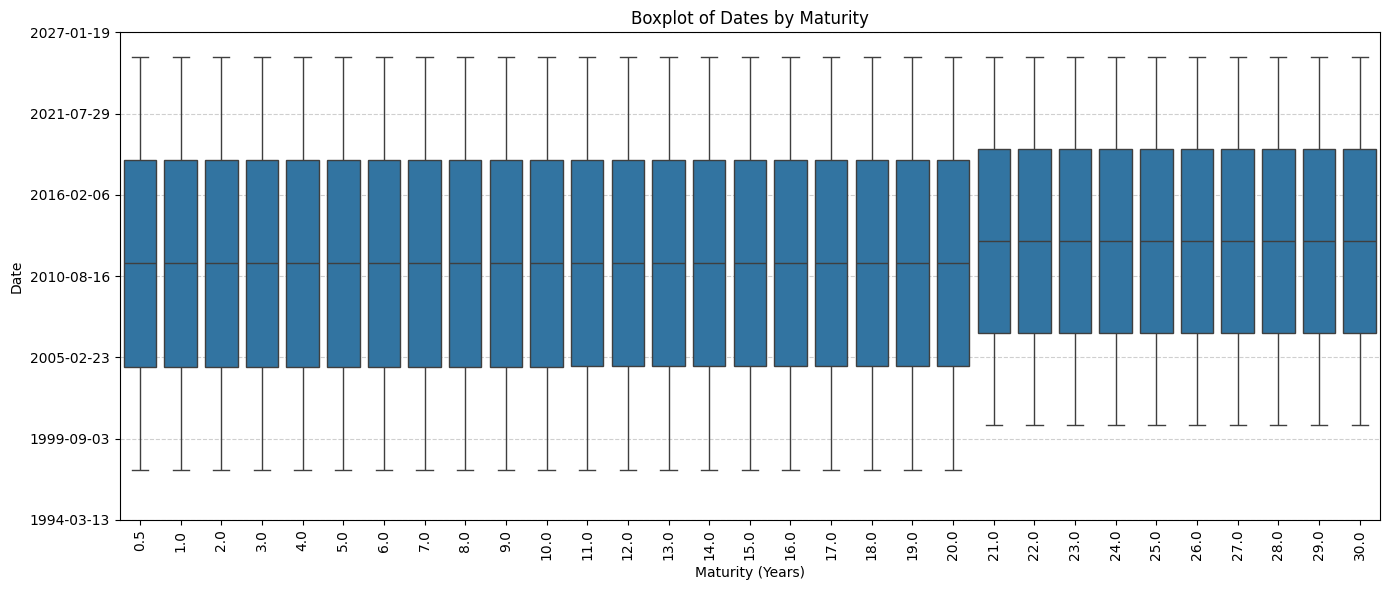

In [17]:
#-------------------------------------   OUTLIER ANALYSIS - Date Column -------------------------------------#

# Prepare long-format date data for seaborn boxplot
date_long_df = []

for df in dataframes:
    maturity = df["Maturity"].iloc[0] if "Maturity" in df.columns else None

    for date in df["Date"].dropna():
        date_long_df.append({"Maturity": maturity, "Date": date})

# Create DataFrame
df_plot_date = pd.DataFrame(date_long_df)

# Convert datetime to ordinal for boxplot
df_plot_date["DateOrdinal"] = df_plot_date["Date"].map(pd.Timestamp.toordinal)

# Create the boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_plot_date, x="Maturity", y="DateOrdinal", showfliers=False)
plt.title("Boxplot of Dates by Maturity")
plt.xlabel("Maturity (Years)")
plt.ylabel("Date")
plt.xticks(rotation=90)
plt.grid(True, axis="y", linestyle="--", alpha=0.6)

# Format y-axis back from ordinal to readable dates
locs, labels = plt.yticks()
plt.yticks(ticks=locs, labels=[pd.Timestamp.fromordinal(int(d)).strftime('%Y-%m-%d') for d in locs])

plt.tight_layout()
plt.show()


#### **Interest Rate Column**

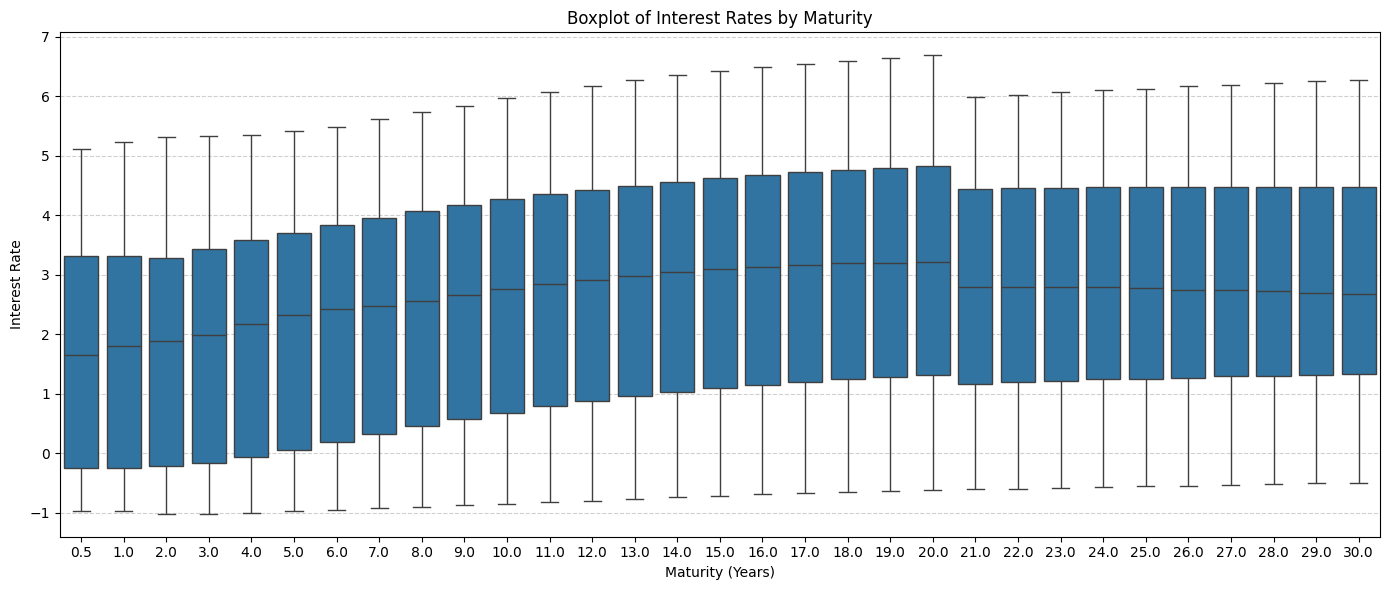

In [18]:
#-------------------------------------- OUTLIER ANALYSIS - Interest Rate Column ---------------------------------------#

from scipy.stats import zscore

# Collect interest rate data
ir_long_df = []
outlier_counts_iqr = {}
outlier_counts_z = {}

for df in dataframes:
    maturity = df["Maturity"].iloc[0] if "Maturity" in df.columns else None
    series = df["Interest Rate"].dropna()

    if len(series) < 10:
        continue

    # Append to long-format DataFrame list
    ir_long_df.extend([{"Maturity": maturity, "Interest Rate": val} for val in series])

    # IQR outliers
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers_iqr = series[(series < lower) | (series > upper)]
    outlier_counts_iqr[maturity] = len(outliers_iqr)

    # Z-score outliers
    z_scores = zscore(series)
    outliers_z = series[(z_scores > 3) | (z_scores < -3)]
    outlier_counts_z[maturity] = len(outliers_z)

# Convert long-format data
df_plot_ir = pd.DataFrame(ir_long_df)

# Create boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_plot_ir, x="Maturity", y="Interest Rate", showfliers=True)
plt.title("Boxplot of Interest Rates by Maturity")
plt.xlabel("Maturity (Years)")
plt.ylabel("Interest Rate")
plt.grid(True, axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# #--------------------- Outlier Summary: IQR & Z-Score ---------------------#
# outlier_summary_df = pd.DataFrame({
#     "Maturity": list(outlier_counts_iqr.keys()),
#     "Total Outliers (IQR)": list(outlier_counts_iqr.values()),
#     "Total Outliers (Z-Score)": [outlier_counts_z.get(k, 0) for k in outlier_counts_iqr.keys()]
# }).sort_values("Maturity").set_index("Maturity")

# print("#--------------------- Outlier Summary: Interest Rate ---------------------#")
# display(outlier_summary_df)

# # Plot histogram of IQR outliers
# plt.figure(figsize=(12, 5))
# sns.barplot(x=outlier_summary_df.index, y=outlier_summary_df["Total Outliers (IQR)"], palette="coolwarm")
# plt.title("Outliers in Interest Rates (IQR Method)")
# plt.xlabel("Maturity")
# plt.ylabel("Outlier Count")
# plt.grid(True, axis='y', linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.show()


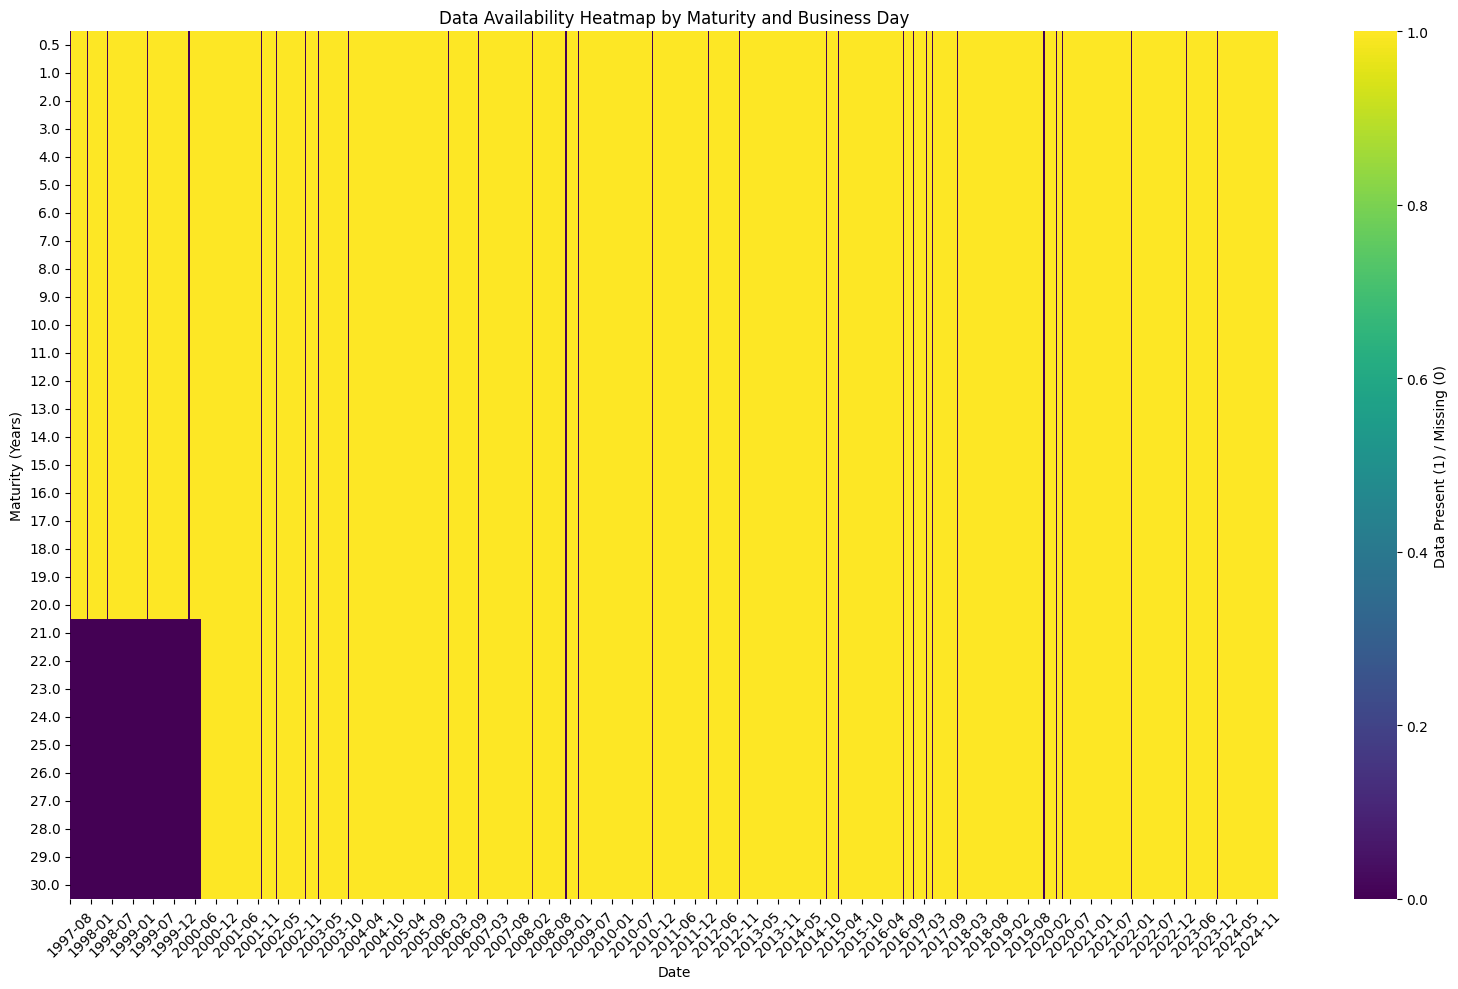

In [19]:
#--------------------- Data Availability Heatmap by Maturity and Month ---------------------#

# Prepare date range covering all files
all_dates = pd.date_range(
    start=min(df['Date'].min() for df in dataframes),
    end=max(df['Date'].max() for df in dataframes),
    freq='B'  # Business days only
)

# Initialize empty DataFrame with dates as index
heatmap_df = pd.DataFrame(index=all_dates)

# Populate matrix with availability per maturity (1 = data present, 0 = missing)
for df in dataframes:
    maturity = df["Maturity"].iloc[0]
    temp = df[['Date', 'Interest Rate']].copy()
    temp['HasData'] = temp['Interest Rate'].notna().astype(int)
    temp.set_index('Date', inplace=True)
    temp = temp.reindex(all_dates, fill_value=0)
    heatmap_df[maturity] = temp['HasData']

# Reorder rows by maturity
heatmap_df = heatmap_df.T.sort_index()

# Format ticks for two per year
xtick_positions = range(0, len(heatmap_df.columns), int(len(heatmap_df.columns) / ((2025 - 1997 + 1) * 2)))
xtick_labels = [heatmap_df.columns[i].strftime('%Y-%m') for i in xtick_positions]

# Plot heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_df, cmap='viridis', cbar_kws={'label': 'Data Present (1) / Missing (0)'})
plt.title('Data Availability Heatmap by Maturity and Business Day')
plt.xlabel('Date')
plt.ylabel('Maturity (Years)')
plt.xticks(ticks=xtick_positions, labels=xtick_labels, rotation=45)
plt.tight_layout()
plt.show()


We can see from the above that for maturities 20-21 until 30 the years 1997-1999 are not present. This will not be analysed now,however will also not be removed as this may represent valuable information for the modeling.

### **<font color='#474747'>*1.2.3 - Data Quality Checks*</font>**

In [20]:
print("----------------------------------------- DATA QUALITY CHECKS - per File  ---------------------------------------")

quality_checks = []

for df in dataframes:
    file_name = df["FileReferenceName"].iloc[0]
    maturity = df["Maturity"].iloc[0]  # Use the actual numeric Maturity column directly

    # Basic checks
    is_sorted = df["Date"].is_monotonic_increasing
    duplicate_rows = df.duplicated().sum()
    duplicate_dates = df["Date"].duplicated().sum()
    missing_counts = df.isnull().sum()
    total_missing = missing_counts.sum()

    # Negative or zero interest rate values
    ir_col = "Interest Rate"
    if ir_col in df.columns:
        negative_or_zero = (df[ir_col] <= 0).sum()
    else:
        negative_or_zero = None

    quality_checks.append({
        "Maturity": maturity,
        "File Name": file_name,
        "Dates Sorted?": is_sorted,
        "Duplicate Rows": duplicate_rows,
        "Duplicate Dates": duplicate_dates,
        "Missing in 'Date'": missing_counts.get("Date", 0),
        "Missing in 'Interest Rate'": missing_counts.get("Interest Rate", 0),
        "Negative/Zero Interest Rates": negative_or_zero
    })

# Create DataFrame
quality_df = pd.DataFrame(quality_checks)
quality_df.set_index("Maturity", inplace=True)
quality_df = quality_df.sort_index()

# Display summary
from IPython.display import display
display(quality_df)

print("\n**Data Quality Check Complete!**\n")


----------------------------------------- DATA QUALITY CHECKS - per File  ---------------------------------------


File Name  Dates Sorted?  \
Maturity                                                                     
0.5       daily-term-structure-spot-interest-rate-R005X.csv           True   
1.0       daily-term-structure-spot-interest-rate-R01XX.csv           True   
2.0       daily-term-structure-spot-interest-rate-R02XX.csv           True   
3.0       daily-term-structure-spot-interest-rate-R03XX.csv           True   
4.0       daily-term-structure-spot-interest-rate-R04XX.csv           True   
5.0       daily-term-structure-spot-interest-rate-R05XX.csv           True   
6.0       daily-term-structure-spot-interest-rate-R06XX.csv           True   
7.0       daily-term-structure-spot-interest-rate-R07XX.csv           True   
8.0       daily-term-structure-spot-interest-rate-R08XX.csv           True   
9.0       daily-term-structure-spot-interest-rate-R09XX.csv           True   
10.0      daily-term-structure-spot-interest-rate-R10XX.csv           True   
11.0      daily-term-structure-spot-interest-rate-R11XX.csv           True   
12.0      daily-term-structure-spot-interest-rate-R12XX.csv           True   
13.0      daily-term-structure-spot-interest-rate-R13XX.csv           True   
14.0      daily-term-structure-spot-interest-rate-R14XX.csv           True   
15.0      daily-term-structure-spot-interest-rate-R15XX.csv           True   
16.0      daily-term-structure-spot-interest-rate-R16XX.csv           True   
17.0      daily-term-structure-spot-interest-rate-R17XX.csv           True   
18.0      daily-term-structure-spot-interest-rate-R18XX.csv           True   
19.0      daily-term-structure-spot-interest-rate-R19XX.csv           True   
20.0      daily-term-structure-spot-interest-rate-R20XX.csv           True   
21.0      daily-term-structure-spot-interest-rate-R21XX.csv           True   
22.0      daily-term-structure-spot-interest-rate-R22XX.csv           True   
23.0      daily-term-structure-spot-interest-rate-R23XX.csv           True   
24.0      daily-term-structure-spot-interest-rate-R24XX.csv           True   
25.0      daily-term-structure-spot-interest-rate-R25XX.csv           True   
26.0      daily-term-structure-spot-interest-rate-R26XX.csv           True   
27.0      daily-term-structure-spot-interest-rate-R27XX.csv           True   
28.0      daily-term-structure-spot-interest-rate-R28XX.csv           True   
29.0      daily-term-structure-spot-interest-rate-R29XX.csv           True   
30.0      daily-term-structure-spot-interest-rate-R30XX.csv           True   

          Duplicate Rows  Duplicate Dates  Missing in 'Date'  \
Maturity                                                       
0.5                    0                0                  0   
1.0                    0                0                  0   
2.0                    0                0                  0   
3.0                    0                0                  0   
4.0                    0                0                  0   
5.0                    0                0                  0   
6.0                    0                0                  0   
7.0                    0                0                  0   
8.0                    0                0                  0   
9.0                    0                0                  0   
10.0                   0                0                  0   
11.0                   0                0                  0   
12.0                   0                0                  0   
13.0                   0                0                  0   
14.0                   0                0                  0   
15.0                   0                0                  0   
16.0                   0                0                  0   
17.0                   0                0                  0   
18.0                   0                0                  0   
19.0                   0                0                  0   
20.0                   0                0                  0   
21.


**Data Quality Check Complete!**



### **<font color='#474747'>*1.2.4 - Missing Values Per XXX*</font>**


##### **1.2.4.1 - Missing Values - Per Day of Week**
* Count
* Percentage

In [21]:
print("#------------------------------   MISSING VALUES - Per Working Day and Weekend ---------------#")

# Dictionaries to hold results
counts = []
percentages = []

for df in dataframes:
    maturity = df["Maturity"].iloc[0] if "Maturity" in df.columns else None

    # Filter valid date rows and create weekday column
    df = df[df["Date"].notnull()].copy()
    df["Weekday"] = df["Date"].dt.strftime("%A")

    # Count total per weekday
    total_counts = df["Weekday"].value_counts()

    # Count missing interest rates per weekday
    missing_counts = df[df["Interest Rate"].isnull()]["Weekday"].value_counts()

    row_counts = {"Maturity": maturity}
    row_percentages = {"Maturity": maturity}

    for day in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]:
        total = total_counts.get(day, 0)
        missing = missing_counts.get(day, 0)
        row_counts[day] = missing
        row_percentages[day] = round((missing / total * 100), 2) if total > 0 else None

    counts.append(row_counts)
    percentages.append(row_percentages)

# Convert to DataFrames
missing_counts_df = pd.DataFrame(counts).set_index("Maturity").sort_index()
missing_percent_df = pd.DataFrame(percentages).set_index("Maturity").sort_index()

# Display both
print("Missing Interest Rate Counts by Weekday:")
display(missing_counts_df)

print("Percentage Missing Interest Rates by Weekday:")
display(missing_percent_df)


#------------------------------   MISSING VALUES - Per Working Day and Weekend ---------------#
Missing Interest Rate Counts by Weekday:


Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
Maturity                                                                
0.5           64       28         26        29      55      1450    1450
1.0           64       28         26        29      55      1450    1450
2.0           64       28         26        29      55      1450    1450
3.0           64       28         26        29      55      1450    1450
4.0           64       28         26        29      55      1450    1450
5.0           64       28         26        29      55      1450    1450
6.0           64       28         26        29      55      1450    1450
7.0           64       28         26        29      55      1450    1450
8.0           64       28         26        29      55      1450    1450
9.0           64       28         26        29      55      1450    1450
10.0          64       28         26        29      55      1450    1450
11.0          64       28         26        29      54      1450    1450
12.0          64       28         26        29      54      1450    1450
13.0          64       28         26        29      54      1450    1450
14.0          64       28         26        29      54      1450    1450
15.0          64       28         26        29      54      1450    1450
16.0          64       28         26        29      54      1450    1450
17.0          64       28         26        29      54      1450    1450
18.0          64       28         26        29      54      1450    1450
19.0          64       28         26        29      54      1450    1450
20.0          64       28         26        29      54      1450    1450
21.0          57       27         23        21      44      1293    1293
22.0          57       27         23        21      44      1293    1293
23.0          57       27         23        21      44      1293    1293
24.0          57       27         23        21      44      1293    1293
25.0          57       27         23        21      44      1293    1293
26.0          57       27         23        21      44      1293    1293
27.0          57       27         23        21      44      1293    1293
28.0          57       27         23        21      44      1293    1293
29.0          57       27         23        21      44      1293    1293
30.0          57       27         23        21      44      1293    1293

Percentage Missing Interest Rates by Weekday:


Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday
Maturity                                                                
0.5         4.41     1.93       1.79      2.00    3.79     100.0   100.0
1.0         4.41     1.93       1.79      2.00    3.79     100.0   100.0
2.0         4.41     1.93       1.79      2.00    3.79     100.0   100.0
3.0         4.41     1.93       1.79      2.00    3.79     100.0   100.0
4.0         4.41     1.93       1.79      2.00    3.79     100.0   100.0
5.0         4.41     1.93       1.79      2.00    3.79     100.0   100.0
6.0         4.41     1.93       1.79      2.00    3.79     100.0   100.0
7.0         4.41     1.93       1.79      2.00    3.79     100.0   100.0
8.0         4.41     1.93       1.79      2.00    3.79     100.0   100.0
9.0         4.41     1.93       1.79      2.00    3.79     100.0   100.0
10.0        4.41     1.93       1.79      2.00    3.79     100.0   100.0
11.0        4.41     1.93       1.79      2.00    3.73     100.0   100.0
12.0        4.41     1.93       1.79      2.00    3.73     100.0   100.0
13.0        4.41     1.93       1.79      2.00    3.73     100.0   100.0
14.0        4.41     1.93       1.79      2.00    3.73     100.0   100.0
15.0        4.41     1.93       1.79      2.00    3.73     100.0   100.0
16.0        4.41     1.93       1.79      2.00    3.73     100.0   100.0
17.0        4.41     1.93       1.79      2.00    3.73     100.0   100.0
18.0        4.41     1.93       1.79      2.00    3.73     100.0   100.0
19.0        4.41     1.93       1.79      2.00    3.73     100.0   100.0
20.0        4.41     1.93       1.79      2.00    3.73     100.0   100.0
21.0        4.41     2.09       1.78      1.62    3.40     100.0   100.0
22.0        4.41     2.09       1.78      1.62    3.40     100.0   100.0
23.0        4.41     2.09       1.78      1.62    3.40     100.0   100.0
24.0        4.41     2.09       1.78      1.62    3.40     100.0   100.0
25.0        4.41     2.09       1.78      1.62    3.40     100.0   100.0
26.0        4.41     2.09       1.78      1.62    3.40     100.0   100.0
27.0        4.41     2.09       1.78      1.62    3.40     100.0   100.0
28.0        4.41     2.09       1.78      1.62    3.40     100.0   100.0
29.0        4.41     2.09       1.78      1.62    3.40     100.0   100.0
30.0        4.41     2.09       1.78      1.62    3.40     100.0   100.0

###### **1.2.4.2.a - Heatmap Missing Values**

#------------------------------   HEATMAP MISSING VALUES - Per Work Day and Weekend  ---------------#


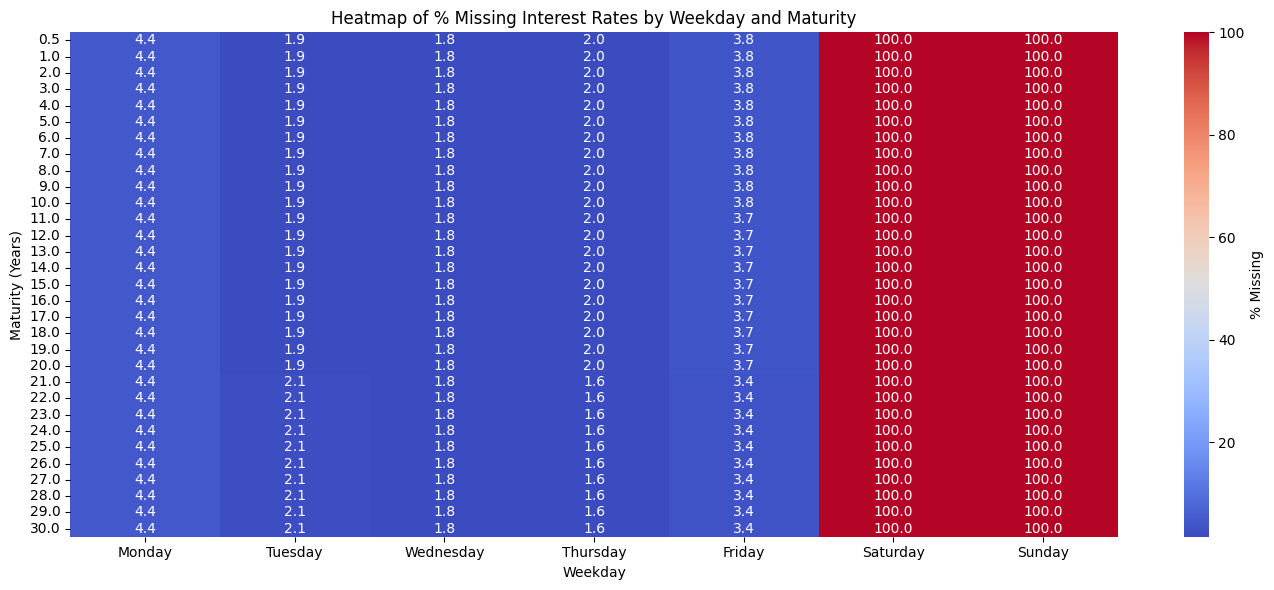

In [22]:
print("#------------------------------   HEATMAP MISSING VALUES - Per Work Day and Weekend  ---------------#")
# Reorder weekday columns for better readability
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heatmap_data = missing_percent_df[weekday_order]

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label": "% Missing"})
plt.title("Heatmap of % Missing Interest Rates by Weekday and Maturity")
plt.xlabel("Weekday")
plt.ylabel("Maturity (Years)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

##### **1.2.4.2 - Missing Values - Per Month**
* Count
* Percentage

In [23]:
#------------------------------   MISSING VALUES - Per Month ---------------#

# Storage for results
monthly_counts = []
monthly_percentages = []

for df in dataframes:
    maturity = df["Maturity"].iloc[0] if "Maturity" in df.columns else None

    # Ensure valid dates
    df = df[df["Date"].notnull()].copy()
    df["Month"] = df["Date"].dt.strftime("%B")

    # Count total and missing interest rates per month
    total_counts = df["Month"].value_counts()
    missing_counts = df[df["Interest Rate"].isnull()]["Month"].value_counts()

    row_counts = {"Maturity": maturity}
    row_percentages = {"Maturity": maturity}

    # Ensure consistent month order
    months = [
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ]

    for month in months:
        total = total_counts.get(month, 0)
        missing = missing_counts.get(month, 0)
        row_counts[month] = missing
        row_percentages[month] = round((missing / total * 100), 2) if total > 0 else None

    monthly_counts.append(row_counts)
    monthly_percentages.append(row_percentages)

# Create DataFrames
missing_month_counts_df = pd.DataFrame(monthly_counts).set_index("Maturity").sort_index()
missing_month_percent_df = pd.DataFrame(monthly_percentages).set_index("Maturity").sort_index()

# Display results
print("Missing Interest Rate Counts by Month:")
display(missing_month_counts_df)

print("Percentage Missing Interest Rates by Month:")
display(missing_month_percent_df)


Missing Interest Rate Counts by Month:


January  February  March  April  May  June  July  August  September  \
Maturity                                                                        
0.5           268       226    258    286  271   237   240     252        240   
1.0           268       226    258    286  271   237   240     252        240   
2.0           268       226    258    286  271   237   240     252        240   
3.0           268       226    258    286  271   237   240     252        240   
4.0           268       226    258    286  271   237   240     252        240   
5.0           268       226    258    286  271   237   240     252        240   
6.0           268       226    258    286  271   237   240     252        240   
7.0           268       226    258    286  271   237   240     252        240   
8.0           268       226    258    286  271   237   240     252        240   
9.0           268       226    258    286  271   237   240     252        240   
10.0          268       226    258    286  271   237   240     252        240   
11.0          268       226    258    286  271   237   240     251        240   
12.0          268       226    258    286  271   237   240     251        240   
13.0          268       226    258    286  271   237   240     251        240   
14.0          268       226    258    286  271   237   240     251        240   
15.0          268       226    258    286  271   237   240     251        240   
16.0          268       226    258    286  271   237   240     251        240   
17.0          268       226    258    286  271   237   240     251        240   
18.0          268       226    258    286  271   237   240     251        240   
19.0          268       226    258    286  271   237   240     251        240   
20.0          268       226    258    286  271   237   240     251        240   
21.0          237       202    233    254  238   210   213     219        216   
22.0          237       202    233    254  238   210   213     219        216   
23.0          237       202    233    254  238   210   213     219        216   
24.0          237       202    233    254  238   210   213     219        216   
25.0          237       202    233    254  238   210   213     219        216   
26.0          237       202    233    254  238   210   213     219        216   
27.0          237       202    233    254  238   210   213     219        216   
28.0          237       202    233    254  238   210   213     219        216   
29.0          237       202    233    254  238   210   213     219        216   
30.0          237       202    233    254  238   210   213     219        216   

          October  November  December  
Maturity                               
0.5           256       240       328  
1.0           256       240       328  
2.0           256       240       328  
3.0           256       240       328  
4.0           256       240       328  
5.0           256       240       328  
6.0           256       240       328  
7.0           256       240       328  
8.0           256       240       328  
9.0           256       240       328  
10.0          256       240       328  
11.0          256       240       328  
12.0          256       240       328  
13.0          256       240       328  
14.0          256       240       328  
15.0          256       240       328  
16.0          256       240       328  
17.0          256       240       328  
18.0          256       240       328  
19.0          256       240       328  
20.0          256       240       328  
21.0          228       213       295  
22.0          228       213       295  
23.0          228       213       295  
24.0          228       213       295  
25.0          228       213       295  
26.0          228       213       295  
27.0          228       213       295  
28.0          228       213       295  
29.0          228       213       295  
30.0          228       213       295

Percentage Missing Interest Rates by Month:


January  February  March  April    May   June   July  August  \
Maturity                                                                 
0.5         30.88     28.57  29.72  34.05  31.81  29.26  28.67   29.03   
1.0         30.88     28.57  29.72  34.05  31.81  29.26  28.67   29.03   
2.0         30.88     28.57  29.72  34.05  31.81  29.26  28.67   29.03   
3.0         30.88     28.57  29.72  34.05  31.81  29.26  28.67   29.03   
4.0         30.88     28.57  29.72  34.05  31.81  29.26  28.67   29.03   
5.0         30.88     28.57  29.72  34.05  31.81  29.26  28.67   29.03   
6.0         30.88     28.57  29.72  34.05  31.81  29.26  28.67   29.03   
7.0         30.88     28.57  29.72  34.05  31.81  29.26  28.67   29.03   
8.0         30.88     28.57  29.72  34.05  31.81  29.26  28.67   29.03   
9.0         30.88     28.57  29.72  34.05  31.81  29.26  28.67   29.03   
10.0        30.88     28.57  29.72  34.05  31.81  29.26  28.67   29.03   
11.0        30.88     28.57  29.72  34.05  31.81  29.26  28.67   28.95   
12.0        30.88     28.57  29.72  34.05  31.81  29.26  28.67   28.95   
13.0        30.88     28.57  29.72  34.05  31.81  29.26  28.67   28.95   
14.0        30.88     28.57  29.72  34.05  31.81  29.26  28.67   28.95   
15.0        30.88     28.57  29.72  34.05  31.81  29.26  28.67   28.95   
16.0        30.88     28.57  29.72  34.05  31.81  29.26  28.67   28.95   
17.0        30.88     28.57  29.72  34.05  31.81  29.26  28.67   28.95   
18.0        30.88     28.57  29.72  34.05  31.81  29.26  28.67   28.95   
19.0        30.88     28.57  29.72  34.05  31.81  29.26  28.67   28.95   
20.0        30.88     28.57  29.72  34.05  31.81  29.26  28.67   28.95   
21.0        30.58     28.61  30.06  33.87  31.36  29.17  28.63   28.29   
22.0        30.58     28.61  30.06  33.87  31.36  29.17  28.63   28.29   
23.0        30.58     28.61  30.06  33.87  31.36  29.17  28.63   28.29   
24.0        30.58     28.61  30.06  33.87  31.36  29.17  28.63   28.29   
25.0        30.58     28.61  30.06  33.87  31.36  29.17  28.63   28.29   
26.0        30.58     28.61  30.06  33.87  31.36  29.17  28.63   28.29   
27.0        30.58     28.61  30.06  33.87  31.36  29.17  28.63   28.29   
28.0        30.58     28.61  30.06  33.87  31.36  29.17  28.63   28.29   
29.0        30.58     28.61  30.06  33.87  31.36  29.17  28.63   28.29   
30.0        30.58     28.61  30.06  33.87  31.36  29.17  28.63   28.29   

          September  October  November  December  
Maturity                                          
0.5           28.57    29.49     28.57     37.79  
1.0           28.57    29.49     28.57     37.79  
2.0           28.57    29.49     28.57     37.79  
3.0           28.57    29.49     28.57     37.79  
4.0           28.57    29.49     28.57     37.79  
5.0           28.57    29.49     28.57     37.79  
6.0           28.57    29.49     28.57     37.79  
7.0           28.57    29.49     28.57     37.79  
8.0           28.57    29.49     28.57     37.79  
9.0           28.57    29.49     28.57     37.79  
10.0          28.57    29.49     28.57     37.79  
11.0          28.57    29.49     28.57     37.79  
12.0          28.57    29.49     28.57     37.79  
13.0          28.57    29.49     28.57     37.79  
14.0          28.57    29.49     28.57     37.79  
15.0          28.57    29.49     28.57     37.79  
16.0          28.57    29.49     28.57     37.79  
17.0          28.57    29.49     28.57     37.79  
18.0          28.57    29.49     28.57     37.79  
19.0          28.57    29.49     28.57     37.79  
20.0          28.57    29.49     28.57     37.79  
21.0          28.80    29.42     28.40     38.06  
22.0          28.80    29.42     28.40     38.06  
23.0          28.80    29.42     28.40     38.06  
24.0          28.80    29.42     28.40     38.06  
25.0          28.80    29.42     28.40     38.06  
26.0          28.80    29.42     28.40     38.06  
27.0          28.80    29.42     28.40     38.06  
28.0          28.80    29.42     28.4

###### **1.2.4.2.a - Heatmap Missing Values**

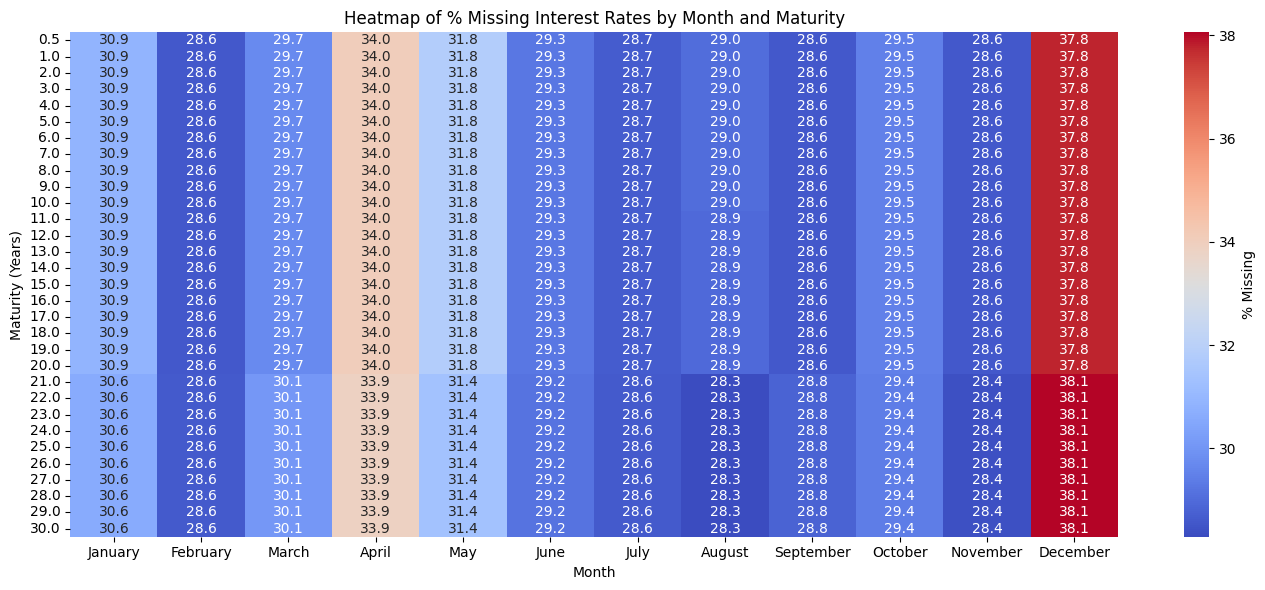

In [24]:

# Reorder month columns for better readability
month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

# Filter and reorder the columns in the percentage DataFrame
heatmap_data_month = missing_month_percent_df[month_order]

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data_month, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label": "% Missing"})
plt.title("Heatmap of % Missing Interest Rates by Month and Maturity")
plt.xlabel("Month")
plt.ylabel("Maturity (Years)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


##### **1.2.4.3 - Missing Values - Per YYYY-MM**
* Count
* Percentage

In [25]:
#------------------------------   MISSING VALUES - Per YYYY-MM ---------------#
# Storage for results
monthly_counts = []
monthly_percentages = []

for df in dataframes:
    maturity = df["Maturity"].iloc[0] if "Maturity" in df.columns else None

    df = df[df["Date"].notnull()].copy()
    df["Month"] = df["Date"].dt.to_period("M").astype(str)  # Format as 'YYYY-MM'

    total_counts = df["Month"].value_counts()
    missing_counts = df[df["Interest Rate"].isnull()]["Month"].value_counts()

    row_counts = {"Maturity": maturity}
    row_percentages = {"Maturity": maturity}

    for month in sorted(total_counts.index):  # Ensure sorted months
        total = total_counts.get(month, 0)
        missing = missing_counts.get(month, 0)
        row_counts[month] = missing
        row_percentages[month] = round((missing / total * 100), 2) if total > 0 else None

    monthly_counts.append(row_counts)
    monthly_percentages.append(row_percentages)

# Create DataFrames
missing_month_counts_df = pd.DataFrame(monthly_counts).set_index("Maturity").sort_index()
missing_month_percent_df = pd.DataFrame(monthly_percentages).set_index("Maturity").sort_index()

# Display results
print("Missing Interest Rate Counts by YYYY-MM:")
display(missing_month_counts_df)

print("Percentage Missing Interest Rates by YYYY-MM:")
display(missing_month_percent_df)


Missing Interest Rate Counts by YYYY-MM:


1997-08  1997-09  1997-10  1997-11  1997-12  1998-01  1998-02  \
Maturity                                                                  
0.5          14.0      8.0      9.0     10.0     12.0     10.0      8.0   
1.0          14.0      8.0      9.0     10.0     12.0     10.0      8.0   
2.0          14.0      8.0      9.0     10.0     12.0     10.0      8.0   
3.0          14.0      8.0      9.0     10.0     12.0     10.0      8.0   
4.0          14.0      8.0      9.0     10.0     12.0     10.0      8.0   
5.0          14.0      8.0      9.0     10.0     12.0     10.0      8.0   
6.0          14.0      8.0      9.0     10.0     12.0     10.0      8.0   
7.0          14.0      8.0      9.0     10.0     12.0     10.0      8.0   
8.0          14.0      8.0      9.0     10.0     12.0     10.0      8.0   
9.0          14.0      8.0      9.0     10.0     12.0     10.0      8.0   
10.0         14.0      8.0      9.0     10.0     12.0     10.0      8.0   
11.0         13.0      8.0      9.0     10.0     12.0     10.0      8.0   
12.0         13.0      8.0      9.0     10.0     12.0     10.0      8.0   
13.0         13.0      8.0      9.0     10.0     12.0     10.0      8.0   
14.0         13.0      8.0      9.0     10.0     12.0     10.0      8.0   
15.0         13.0      8.0      9.0     10.0     12.0     10.0      8.0   
16.0         13.0      8.0      9.0     10.0     12.0     10.0      8.0   
17.0         13.0      8.0      9.0     10.0     12.0     10.0      8.0   
18.0         13.0      8.0      9.0     10.0     12.0     10.0      8.0   
19.0         13.0      8.0      9.0     10.0     12.0     10.0      8.0   
20.0         13.0      8.0      9.0     10.0     12.0     10.0      8.0   
21.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
22.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
23.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
24.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
25.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
26.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
27.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
28.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
29.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
30.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   

          1998-03  1998-04  1998-05  ...  2024-08  2024-09  2024-10  2024-11  \
Maturity                             ...                                       
0.5           9.0     10.0     12.0  ...        9        9        8        9   
1.0           9.0     10.0     12.0  ...        9        9        8        9   
2.0           9.0     10.0     12.0  ...        9        9        8        9   
3.0           9.0     10.0     12.0  ...        9        9        8        9   
4.0           9.0     10.0     12.0  ...        9        9        8        9   
5.0           9.0     10.0     12.0  ...        9        9        8        9   
6.0           9.0     10.0     12.0  ...        9        9        8        9   
7.0           9.0     10.0     12.0  ...        9        9        8        9   
8.0           9.0     10.0     12.0  ...        9        9        8        9   
9.0           9.0     10.0     12.0  ...        9        9        8        9   
10.0          9.0     10.0     12.0  ...        9        9        8        9   
11.0          9.0     10.0     12.0  ...        9        9        8        9   
12.0          9.0     10.0     12.0  ...        9        9        8        9   
13.0          9.0     10.0     12.0  ...        9        9        8        9   
14.0          9.0     10.0     12.0  ...        9        9        8        9   
15.0          9.0     10.0     12.0  ...        9        9        8        9   
16.0          9.0     10.0     12.0  ...        9        9        8        9   
17.0          

Percentage Missing Interest Rates by YYYY-MM:


1997-08  1997-09  1997-10  1997-11  1997-12  1998-01  1998-02  \
Maturity                                                                  
0.5         45.16    26.67    29.03    33.33    38.71    32.26    28.57   
1.0         45.16    26.67    29.03    33.33    38.71    32.26    28.57   
2.0         45.16    26.67    29.03    33.33    38.71    32.26    28.57   
3.0         45.16    26.67    29.03    33.33    38.71    32.26    28.57   
4.0         45.16    26.67    29.03    33.33    38.71    32.26    28.57   
5.0         45.16    26.67    29.03    33.33    38.71    32.26    28.57   
6.0         45.16    26.67    29.03    33.33    38.71    32.26    28.57   
7.0         45.16    26.67    29.03    33.33    38.71    32.26    28.57   
8.0         45.16    26.67    29.03    33.33    38.71    32.26    28.57   
9.0         45.16    26.67    29.03    33.33    38.71    32.26    28.57   
10.0        45.16    26.67    29.03    33.33    38.71    32.26    28.57   
11.0        43.33    26.67    29.03    33.33    38.71    32.26    28.57   
12.0        43.33    26.67    29.03    33.33    38.71    32.26    28.57   
13.0        43.33    26.67    29.03    33.33    38.71    32.26    28.57   
14.0        43.33    26.67    29.03    33.33    38.71    32.26    28.57   
15.0        43.33    26.67    29.03    33.33    38.71    32.26    28.57   
16.0        43.33    26.67    29.03    33.33    38.71    32.26    28.57   
17.0        43.33    26.67    29.03    33.33    38.71    32.26    28.57   
18.0        43.33    26.67    29.03    33.33    38.71    32.26    28.57   
19.0        43.33    26.67    29.03    33.33    38.71    32.26    28.57   
20.0        43.33    26.67    29.03    33.33    38.71    32.26    28.57   
21.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
22.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
23.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
24.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
25.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
26.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
27.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
28.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
29.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   
30.0          NaN      NaN      NaN      NaN      NaN      NaN      NaN   

          1998-03  1998-04  1998-05  ...  2024-08  2024-09  2024-10  2024-11  \
Maturity                             ...                                       
0.5         29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
1.0         29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
2.0         29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
3.0         29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
4.0         29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
5.0         29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
6.0         29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
7.0         29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
8.0         29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
9.0         29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
10.0        29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
11.0        29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
12.0        29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
13.0        29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
14.0        29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
15.0        29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
16.0        29.03    33.33    38.71  ...    29.03     30.0    25.81     30.0   
17.0        29

###### **1.2.4.3.a - Heatmap Missing Values**

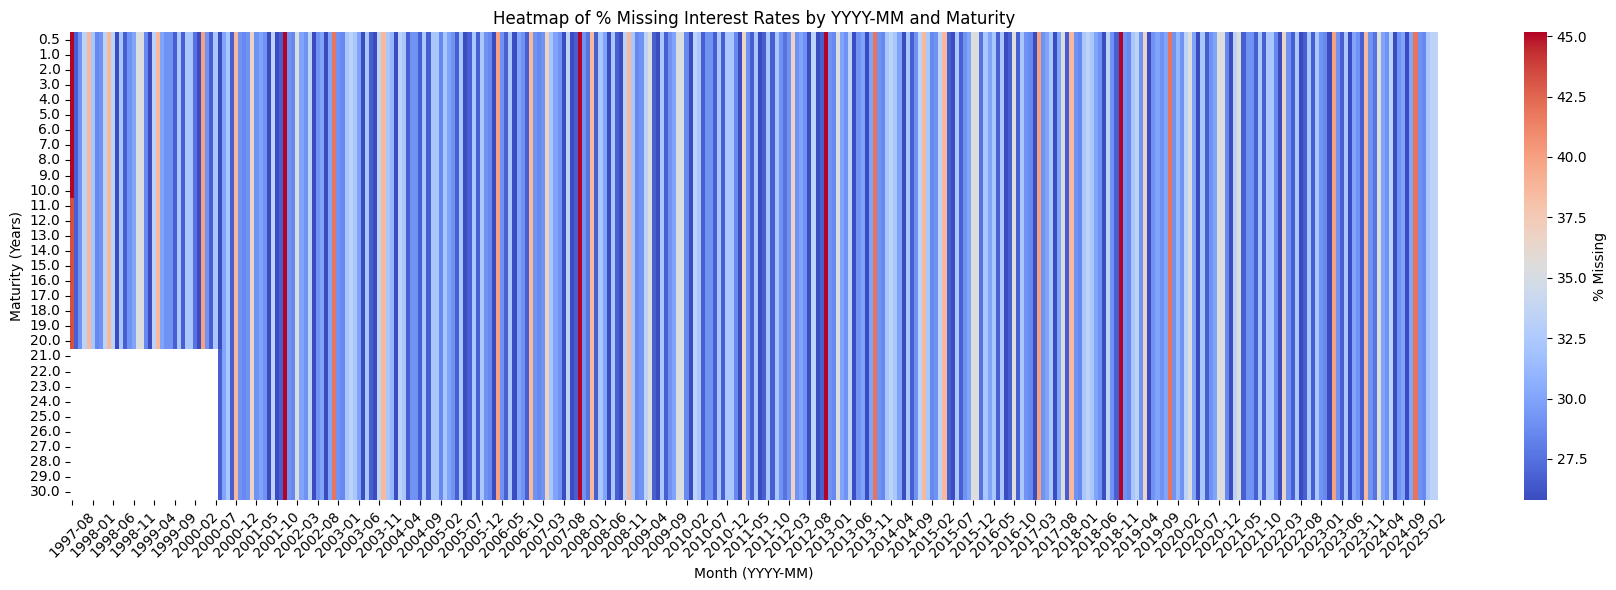

In [26]:
#------------------------------   HEATMAP OF % MISSING - Per YYYY-MM ---------------#
# Ensure columns are sorted chronologically
heatmap_data_ym = missing_month_percent_df.copy()
heatmap_data_ym = heatmap_data_ym[sorted(heatmap_data_ym.columns)]

# Plot heatmap without annotations
plt.figure(figsize=(18, 6))
sns.heatmap(
    heatmap_data_ym,
    annot=False,  # <-- Remove annotations inside cells
    fmt=".1f",
    cmap="coolwarm",
    cbar_kws={"label": "% Missing"}
)
plt.title("Heatmap of % Missing Interest Rates by YYYY-MM and Maturity")
plt.xlabel("Month (YYYY-MM)")
plt.ylabel("Maturity (Years)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### **<font color='#474747'>*1.2.5 - Missing Values Per day of Week (Excluding Public Holidays)*</font>**
* Count
* Percentage

In [27]:
#------------------------------   MISSING DATA - Per Weekday (Excluding Public Holidays and Weekends) ---------------#
from datetime import date as dt_date, timedelta
from dateutil.easter import easter

# ------------------------- Build Dynamic Public Holiday Calendar ----------------------- #
def get_excel_holidays(year):
    # Explicitly import date within the function to avoid shadowing
    from datetime import date
    e = easter(year)
    return set([
        date(year, 1, 1),           # New Year's Day
        e - timedelta(days=2),      # Good Friday
        e + timedelta(days=1),      # Easter Monday
        date(year, 5, 1),           # Labour Day
        date(year, 12, 24),         # Christmas Eve
        date(year, 12, 25),         # Christmas Day
        date(year, 12, 26),         # Boxing Day
        date(year, 12, 31),         # New Year's Eve
    ])

# Get date range across all files
all_dates = pd.concat([df["Date"] for df in dataframes if "Date" in df.columns]).dropna()
min_year, max_year = all_dates.min().year, all_dates.max().year

all_holidays = set()
for y in range(min_year, max_year + 1):
    all_holidays.update(get_excel_holidays(y))
holiday_dates = pd.to_datetime(list(all_holidays))

# ------------------------- Count Missing by Weekday (Excl. Holidays & Weekends) ----------------------- #
counts = []
percentages = []

for df in dataframes:
    maturity = df["Maturity"].iloc[0] if "Maturity" in df.columns else None

    df = df[df["Date"].notnull()].copy()

    # Exclude weekends
    df = df[~df["Date"].dt.weekday.isin([5, 6])].copy()

    # Exclude public holidays
    df = df[~df["Date"].isin(holiday_dates)].copy()

    # Add weekday label
    df["Weekday"] = df["Date"].dt.strftime("%A")

    total_counts = df["Weekday"].value_counts()
    missing_counts = df[df["Interest Rate"].isnull()]["Weekday"].value_counts()

    row_counts = {"Maturity": maturity}
    row_percentages = {"Maturity": maturity}

    for day in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]:
        total = total_counts.get(day, 0)
        missing = missing_counts.get(day, 0)
        row_counts[day] = missing
        row_percentages[day] = round((missing / total * 100), 2) if total > 0 else None

    counts.append(row_counts)
    percentages.append(row_percentages)

# Create and display DataFrames
missing_counts_df = pd.DataFrame(counts).set_index("Maturity").sort_index()
missing_percent_df = pd.DataFrame(percentages).set_index("Maturity").sort_index()

print("Missing Interest Rate Counts by Weekday (Excl. Public Holidays and Weekends):")
display(missing_counts_df)

print("Percentage Missing Interest Rates by Weekday (Excl. Public Holidays and Weekends):")
display(missing_percent_df)

Missing Interest Rate Counts by Weekday (Excl. Public Holidays and Weekends):


Monday  Tuesday  Wednesday  Thursday  Friday
Maturity                                              
0.5           12        4          2         5       3
1.0           12        4          2         5       3
2.0           12        4          2         5       3
3.0           12        4          2         5       3
4.0           12        4          2         5       3
5.0           12        4          2         5       3
6.0           12        4          2         5       3
7.0           12        4          2         5       3
8.0           12        4          2         5       3
9.0           12        4          2         5       3
10.0          12        4          2         5       3
11.0          12        4          2         5       2
12.0          12        4          2         5       2
13.0          12        4          2         5       2
14.0          12        4          2         5       2
15.0          12        4          2         5       2
16.0          12        4          2         5       2
17.0          12        4          2         5       2
18.0          12        4          2         5       2
19.0          12        4          2         5       2
20.0          12        4          2         5       2
21.0           9        3          1         1       1
22.0           9        3          1         1       1
23.0           9        3          1         1       1
24.0           9        3          1         1       1
25.0           9        3          1         1       1
26.0           9        3          1         1       1
27.0           9        3          1         1       1
28.0           9        3          1         1       1
29.0           9        3          1         1       1
30.0           9        3          1         1       1

Percentage Missing Interest Rates by Weekday (Excl. Public Holidays and Weekends):


Monday  Tuesday  Wednesday  Thursday  Friday
Maturity                                              
0.5         0.86     0.28       0.14      0.35    0.21
1.0         0.86     0.28       0.14      0.35    0.21
2.0         0.86     0.28       0.14      0.35    0.21
3.0         0.86     0.28       0.14      0.35    0.21
4.0         0.86     0.28       0.14      0.35    0.21
5.0         0.86     0.28       0.14      0.35    0.21
6.0         0.86     0.28       0.14      0.35    0.21
7.0         0.86     0.28       0.14      0.35    0.21
8.0         0.86     0.28       0.14      0.35    0.21
9.0         0.86     0.28       0.14      0.35    0.21
10.0        0.86     0.28       0.14      0.35    0.21
11.0        0.86     0.28       0.14      0.35    0.14
12.0        0.86     0.28       0.14      0.35    0.14
13.0        0.86     0.28       0.14      0.35    0.14
14.0        0.86     0.28       0.14      0.35    0.14
15.0        0.86     0.28       0.14      0.35    0.14
16.0        0.86     0.28       0.14      0.35    0.14
17.0        0.86     0.28       0.14      0.35    0.14
18.0        0.86     0.28       0.14      0.35    0.14
19.0        0.86     0.28       0.14      0.35    0.14
20.0        0.86     0.28       0.14      0.35    0.14
21.0        0.72     0.24       0.08      0.08    0.08
22.0        0.72     0.24       0.08      0.08    0.08
23.0        0.72     0.24       0.08      0.08    0.08
24.0        0.72     0.24       0.08      0.08    0.08
25.0        0.72     0.24       0.08      0.08    0.08
26.0        0.72     0.24       0.08      0.08    0.08
27.0        0.72     0.24       0.08      0.08    0.08
28.0        0.72     0.24       0.08      0.08    0.08
29.0        0.72     0.24       0.08      0.08    0.08
30.0        0.72     0.24       0.08      0.08    0.08

* Saturday & Sunday are always 100% missing
→ No rates published on weekends (normal).

* Weekday missingness is low (mostly ~1.6–4.4%)
→ These are likely holidays, system outages, or publication lags.





###### **1.2.5.1 - Count of Missing Values per Maturity (Excl Weekends & Public Holidays)**


In [28]:
#------------------------------   MISSING INTEREST RATE COUNT - Per File (Excl. Weekends and Holidays) ---------------#
from datetime import date as dt_date, timedelta
from dateutil.easter import easter

# ----------- Generate Public Holiday Set (Easter-based logic) -----------
def get_excel_holidays(year):
    from datetime import date
    e = easter(year)
    return set([
        date(year, 1, 1),           # New Year's Day
        e - timedelta(days=2),      # Good Friday
        e + timedelta(days=1),      # Easter Monday
        date(year, 5, 1),           # Labour Day
        date(year, 12, 24),         # Christmas Eve
        date(year, 12, 25),         # Christmas Day
        date(year, 12, 26),         # Boxing Day
        date(year, 12, 31),         # New Year's Eve
    ])

# ----------- Collect global date range from all files -----------
all_dates = pd.concat([df["Date"] for df in dataframes if "Date" in df.columns]).dropna()
min_year, max_year = all_dates.min().year, all_dates.max().year

# Build full set of holiday dates
all_holidays = set()
for y in range(min_year, max_year + 1):
    all_holidays.update(get_excel_holidays(y))
holiday_dates = pd.to_datetime(list(all_holidays))

# ----------- Run missing value analysis excluding holidays/weekends -----------
summary_stats = []

for df in dataframes:
    maturity = df["Maturity"].iloc[0] if "Maturity" in df.columns else None

    df = df[df["Date"].notnull()].copy()

    # Remove weekends
    df = df[~df["Date"].dt.weekday.isin([5, 6])].copy()

    # Remove public holidays
    df = df[~df["Date"].isin(holiday_dates)].copy()

    total_days = len(df)
    missing_ir = df["Interest Rate"].isnull().sum()
    missing_pct = (missing_ir / total_days) * 100 if total_days > 0 else 0

    summary_stats.append({
        "Maturity": maturity,
        "Filtered Business Days": total_days,
        "Missing Interest Rate Values": missing_ir,
        "% Missing (Excl. Holidays/Weekends)": round(missing_pct, 2)
    })

# Create and display results
missing_summary_df = pd.DataFrame(summary_stats).set_index("Maturity").sort_index()

print("Missing Interest Rate Values by File (Excl. Weekends and Public Holidays):")
display(missing_summary_df)


Missing Interest Rate Values by File (Excl. Weekends and Public Holidays):


Filtered Business Days  Missing Interest Rate Values  \
Maturity                                                         
0.5                         7074                            26   
1.0                         7074                            26   
2.0                         7074                            26   
3.0                         7074                            26   
4.0                         7074                            26   
5.0                         7074                            26   
6.0                         7074                            26   
7.0                         7074                            26   
8.0                         7074                            26   
9.0                         7074                            26   
10.0                        7074                            26   
11.0                        7073                            25   
12.0                        7073                            25   
13.0                        7073                            25   
14.0                        7073                            25   
15.0                        7073                            25   
16.0                        7073                            25   
17.0                        7073                            25   
18.0                        7073                            25   
19.0                        7073                            25   
20.0                        7073                            25   
21.0                        6310                            15   
22.0                        6310                            15   
23.0                        6310                            15   
24.0                        6310                            15   
25.0                        6310                            15   
26.0                        6310                            15   
27.0                        6310                            15   
28.0                        6310                            15   
29.0                        6310                            15   
30.0                        6310                            15   

          % Missing (Excl. Holidays/Weekends)  
Maturity                                       
0.5                                      0.37  
1.0                                      0.37  
2.0                                      0.37  
3.0                                      0.37  
4.0                                      0.37  
5.0                                      0.37  
6.0                                      0.37  
7.0                                      0.37  
8.0                                      0.37  
9.0                                      0.37  
10.0                                     0.37  
11.0                                     0.35  
12.0                                     0.35  
13.0                                     0.35  
14.0                                     0.35  
15.0                                     0.35  
16.0                                     0.35  
17.0                                     0.35  
18.0                                     0.35  
19.0                                     0.35  
20.0                                     0.35  
21.0                                     0.24  
22.0                                     0.24  
23.0                                     0.24  
24.0                                     0.24  
25.0                                     0.24  
26.0                                     0.24  
27.0                                     0.24  
28.0                                     0.24  
29.0                                     0.24  
30.0                                     0.24

###### **1.2.5.2 - Heatmap & Table True Missing Values**

<ipython-input-29-2f5eb3e1a061>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Month"] = df["Date"].dt.month_name()


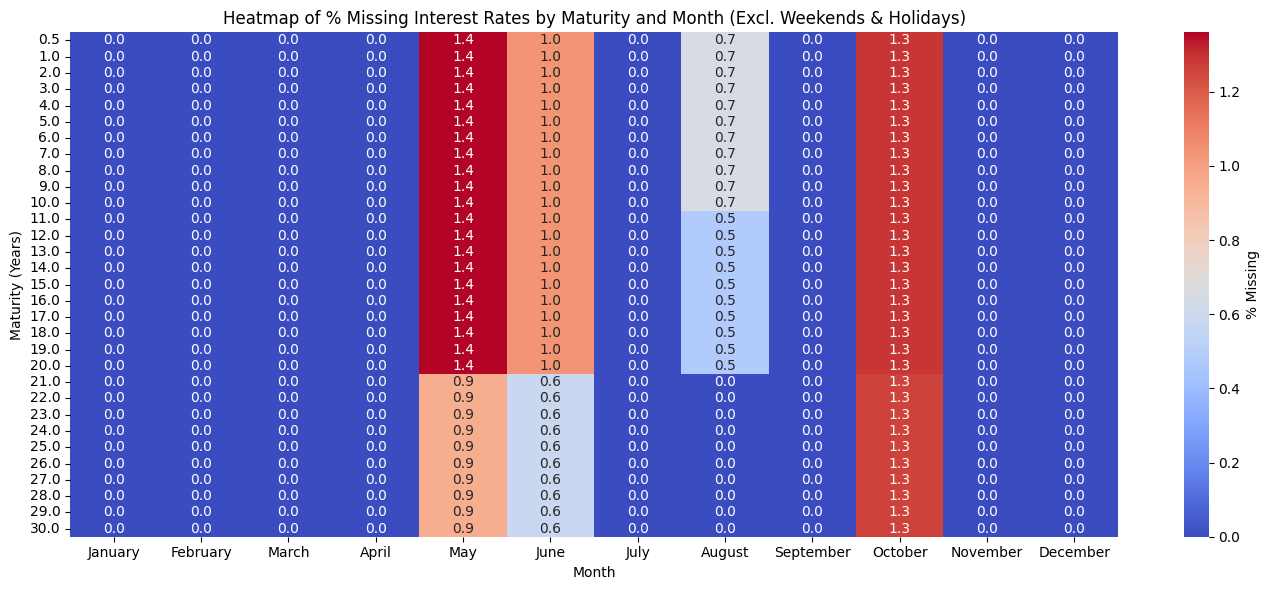

Total Missing Rows (Excl. Weekends & Holidays): 686


Date  Interest Rate   Information No IR  \
0  1997-08-01            NaN  No value available   
1  1997-08-04            NaN  No value available   
2  1997-08-05            NaN  No value available   
3  1997-08-06            NaN  No value available   
4  1997-10-03            NaN  No value available   
5  1998-05-21            NaN  No value available   
6  1998-06-01            NaN  No value available   
7  1998-06-11            NaN  No value available   
8  1999-05-13            NaN  No value available   
9  1999-05-24            NaN  No value available   
10 1999-06-03            NaN  No value available   
11 2000-10-03            NaN  No value available   
12 2007-05-28            NaN  No value available   
13 2014-10-03            NaN  No value available   
14 2015-05-25            NaN  No value available   
15 2016-05-16            NaN  No value available   
16 2016-10-03            NaN  No value available   
17 2017-06-05            NaN  No value available   
18 2017-10-03            NaN  No value available   
19 2017-10-31            NaN  No value available   

                                    FileReferenceName  Maturity  
0   daily-term-structure-spot-interest-rate-R005X.csv       0.5  
1   daily-term-structure-spot-interest-rate-R005X.csv       0.5  
2   daily-term-structure-spot-interest-rate-R005X.csv       0.5  
3   daily-term-structure-spot-interest-rate-R005X.csv       0.5  
4   daily-term-structure-spot-interest-rate-R005X.csv       0.5  
5   daily-term-structure-spot-interest-rate-R005X.csv       0.5  
6   daily-term-structure-spot-interest-rate-R005X.csv       0.5  
7   daily-term-structure-spot-interest-rate-R005X.csv       0.5  
8   daily-term-structure-spot-interest-rate-R005X.csv       0.5  
9   daily-term-structure-spot-interest-rate-R005X.csv       0.5  
10  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
11  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
12  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
13  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
14  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
15  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
16  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
17  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
18  daily-term-structure-spot-interest-rate-R005X.csv       0.5  
19  daily-term-structure-spot-interest-rate-R005X.csv       0.5

In [29]:
#------------------------------   HEATMAP OF MISSING VALUES - Per File per Month (Excl. Weekends & Holidays) ---------------#
from datetime import date as dt_date, timedelta
from dateutil.easter import easter

# -------- Generate public holiday calendar -------- #
def get_excel_holidays(year):
    from datetime import date
    e = easter(year)
    return set([
        date(year, 1, 1),
        e - timedelta(days=2),
        e + timedelta(days=1),
        date(year, 5, 1),
        date(year, 12, 24),
        date(year, 12, 25),
        date(year, 12, 26),
        date(year, 12, 31),
    ])

# Build holiday list
all_dates = pd.concat([df["Date"] for df in dataframes if "Date" in df.columns]).dropna()
min_year, max_year = all_dates.min().year, all_dates.max().year
all_holidays = set()
for y in range(min_year, max_year + 1):
    all_holidays.update(get_excel_holidays(y))
holiday_dates = pd.to_datetime(list(all_holidays))

# -------- Collect missing values per MONTH (aggregated across years) and maturity -------- #
heatmap_records = []

months = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

for df in dataframes:
    df = df[df["Date"].notnull()].copy()
    df = df[~df["Date"].dt.weekday.isin([5, 6])]
    df = df[~df["Date"].isin(holiday_dates)]

    maturity = df["Maturity"].iloc[0]
    df["Month"] = df["Date"].dt.month_name()

    total_counts = df["Month"].value_counts()
    missing_counts = df[df["Interest Rate"].isnull()]["Month"].value_counts()

    for month in months:
        total = total_counts.get(month, 0)
        missing = missing_counts.get(month, 0)
        pct = round((missing / total) * 100, 2) if total > 0 else 0
        heatmap_records.append({"Maturity": maturity, "Month": month, "% Missing": pct})

# -------- Pivot and plot heatmap -------- #
missing_month_df = pd.DataFrame(heatmap_records)
pivot_df = missing_month_df.pivot(index="Maturity", columns="Month", values="% Missing")[months]

# Plot
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_df, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label": "% Missing"})
plt.title("Heatmap of % Missing Interest Rates by Maturity and Month (Excl. Weekends & Holidays)")
plt.xlabel("Month")
plt.ylabel("Maturity (Years)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#------------------------------   APPENDED TABLE OF MISSING INTEREST RATE ROWS (Excl. Weekends & Holidays) ---------------#
missing_rows = []

for df in dataframes:
    df = df[df["Date"].notnull()].copy()

    # Exclude weekends
    df = df[~df["Date"].dt.weekday.isin([5, 6])]

    # Exclude public holidays
    df = df[~df["Date"].isin(holiday_dates)]

    # Filter rows where interest rate is missing
    df_missing = df[df["Interest Rate"].isnull()].copy()

    # Append to list
    missing_rows.append(df_missing)

# Combine all into one DataFrame
missing_data_df = pd.concat(missing_rows, ignore_index=True)

# Optional: Display first few rows
print(f"Total Missing Rows (Excl. Weekends & Holidays): {len(missing_data_df)}")
display(missing_data_df.head(20))  # Change or remove .head(20) to display more



###### **1.2.5.3 - Interpolation Use Case**

In [30]:
# --------------------- MISSING BLOCK SUMMARY (All Gaps for Selected File) ---------------------
import pandas as pd
import numpy as np
from datetime import date, timedelta
from dateutil.easter import easter

# --- Reuse the holiday function from earlier ---
def get_excel_holidays(year):
    from datetime import date
    e = easter(year)
    return set([
        date(year, 1, 1),
        e - timedelta(days=2),
        e + timedelta(days=1),
        date(year, 5, 1),
        date(year, 12, 24),
        date(year, 12, 25),
        date(year, 12, 26),
        date(year, 12, 31),
    ])

# Recompute holiday list
all_dates = pd.concat([df["Date"] for df in dataframes if "Date" in df.columns]).dropna()
min_year, max_year = all_dates.min().year, all_dates.max().year
all_holidays = set()
for y in range(min_year, max_year + 1):
    all_holidays.update(get_excel_holidays(y))
holiday_dates = pd.to_datetime(list(all_holidays))


# ------------------------------------------------------------- CHANGE THIS TO SELECT A DIFFERENT FILE ------------------------------------------#
# --- Select which dataframe to use ---
selected_df_index = 13  # CHANGE THIS TO SELECT A DIFFERENT FILE
# -----------------------------------------------------------------------------------------------------------------------------------------------#
df = dataframes[selected_df_index].copy()

# Filter
df = df[df["Date"].notnull()].copy()
df = df[~df["Date"].dt.weekday.isin([5, 6])]
df = df[~df["Date"].isin(holiday_dates)]

# Build full business date range and reindex
full_dates = pd.date_range(start=df["Date"].min(), end=df["Date"].max(), freq="B")
full_dates = full_dates[~full_dates.isin(holiday_dates)]
df = df.set_index("Date").sort_index()
df = df.reindex(full_dates)
df.reset_index(inplace=True)
df.rename(columns={"index": "Date"}, inplace=True)

# Identify missing blocks
df["Missing"] = df["Interest Rate"].isna().astype(int)
df["Gap_ID"] = (df["Missing"].diff(1) == 1).cumsum() * df["Missing"]

# Group and summarize missing blocks
block_summary = []

missing_blocks = df[df["Missing"] == 1].groupby("Gap_ID")

for gid, group in missing_blocks:
    start_date = group["Date"].iloc[0]
    end_date = group["Date"].iloc[-1]

    # Only count valid business days excluding holidays
    expected_range = pd.date_range(start=start_date, end=end_date, freq="B")
    expected_range = expected_range[~expected_range.isin(holiday_dates)]
    missing_days = len(expected_range)

    idx_before = df[df["Date"] < start_date]["Interest Rate"].last_valid_index()
    value_before = df.loc[idx_before, "Interest Rate"] if idx_before is not None else None
    date_before = df.loc[idx_before, "Date"] if idx_before is not None else None

    idx_after = df[df["Date"] > end_date]["Interest Rate"].first_valid_index()
    value_after = df.loc[idx_after, "Interest Rate"] if idx_after is not None else None
    date_after = df.loc[idx_after, "Date"] if idx_after is not None else None

    block_summary.append({
        "Gap Start": start_date.date(),
        "Gap End": end_date.date(),
        "Missing Business Days": missing_days,
        "Last Known Date": date_before.date() if pd.notnull(date_before) else None,
        "Last Known Value": round(value_before, 4) if pd.notnull(value_before) else None,
        "Next Known Date": date_after.date() if pd.notnull(date_after) else None,
        "Next Known Value": round(value_after, 4) if pd.notnull(value_after) else None
    })


# Create and show table
gap_df = pd.DataFrame(block_summary)
print(f"Missing Gaps for File Index {selected_df_index} (Maturity = {df['Maturity'].dropna().iloc[0]}):")
display(gap_df)


Missing Gaps for File Index 13 (Maturity = 13):


Gap Start     Gap End  Missing Business Days Last Known Date  \
0   1997-08-04  1997-08-06                      3            None   
1   1997-10-03  1997-10-03                      1      1997-10-02   
2   1998-05-21  1998-05-21                      1      1998-05-20   
3   1998-06-01  1998-06-01                      1      1998-05-29   
4   1998-06-11  1998-06-11                      1      1998-06-10   
5   1999-05-13  1999-05-13                      1      1999-05-12   
6   1999-05-24  1999-05-24                      1      1999-05-21   
7   1999-06-03  1999-06-03                      1      1999-06-02   
8   2000-10-03  2000-10-03                      1      2000-10-02   
9   2007-05-28  2007-05-28                      1      2007-05-25   
10  2014-10-03  2014-10-03                      1      2014-10-02   
11  2015-05-25  2015-05-25                      1      2015-05-22   
12  2016-05-16  2016-05-16                      1      2016-05-13   
13  2016-10-03  2016-10-03                      1      2016-09-30   
14  2017-06-05  2017-06-05                      1      2017-06-02   
15  2017-10-03  2017-10-03                      1      2017-10-02   
16  2017-10-31  2017-10-31                      1      2017-10-30   
17  2018-05-21  2018-05-21                      1      2018-05-18   
18  2018-10-03  2018-10-03                      1      2018-10-02   
19  2019-06-10  2019-06-10                      1      2019-06-07   
20  2019-10-03  2019-10-03                      1      2019-10-02   
21  2020-06-01  2020-06-01                      1      2020-05-29   
22  2021-05-24  2021-05-24                      1      2021-05-21   

    Last Known Value Next Known Date  Next Known Value  
0                NaN      1997-08-07              6.25  
1               5.91      1997-10-06              5.84  
2               5.36      1998-05-22              5.23  
3               5.24      1998-06-02              5.13  
4               5.13      1998-06-12              5.09  
5               4.69      1999-05-14              4.58  
6               4.62      1999-05-25              4.58  
7               4.84      1999-06-04              4.86  
8               5.39      2000-10-04              5.43  
9               4.47      2007-05-29              4.48  
10              1.34      2014-10-06              1.33  
11              0.91      2015-05-26              0.85  
12              0.38      2016-05-17              0.42  
13              0.00      2016-10-04              0.06  
14              0.63      2017-06-06              0.61  
15              0.76      2017-10-04              0.74  
16              0.73      2017-11-01              0.71  
17              0.90      2018-05-22              0.85  
18              0.64      2018-10-04              0.76  
19             -0.04      2019-06-11             -0.03  
20             -0.43      2019-10-04             -0.48  
21             -0.28      2020-06-02             -0.26  
22              0.04      2021-05-25              0.01

## **<font color='#474747'>1.3 - Data Cleaning** - check
* Check:
- Public holidays
- Rules

### **<font color='#474747'>*1.3.1 - Apply Data Cleaning*</font>**
* Remove weekends completely
*  Forward-fill missing values (only on weekdays)
* Interpoalte remaning gaps because for yield curve modeling (e.g., Nelson-Siegel) - continuity is needed.

In [31]:
print("#-------------------------------------   DATA CLEANING - Apply Filling  -------------------------------------#")
#--------------------- STEP 1: REMOVE WEEKENDS AND PUBLIC HOLIDAYS ---------------------#
from datetime import date, timedelta
from dateutil.easter import easter

# Define Excel-style public holiday function
def get_excel_holidays(year):
    e = easter(year)
    return set([
        date(year, 1, 1),           # New Year's Day
        e - timedelta(days=2),      # Good Friday
        e + timedelta(days=1),      # Easter Monday
        date(year, 5, 1),           # Labour Day
        date(year, 12, 24),         # Christmas Eve
        date(year, 12, 25),         # Christmas Day
        date(year, 12, 26),         # Boxing Day
        date(year, 12, 31),         # New Year's Eve
    ])

# Compute full holiday list across all years in the dataset
all_dates = pd.concat([df["Date"] for df in dataframes if "Date" in df.columns]).dropna()
min_year, max_year = all_dates.min().year, all_dates.max().year

holiday_set = set()
for y in range(min_year, max_year + 1):
    holiday_set.update(get_excel_holidays(y))

holiday_dates = pd.to_datetime(list(holiday_set))

# Clean each DataFrame: remove weekends and public holidays
for i in range(len(dataframes)):
    df = dataframes[i]

    # Remove invalid or null dates
    df = df[df["Date"].notnull()].copy()

    # Exclude weekends
    df = df[~df["Date"].dt.weekday.isin([5, 6])]

    # Exclude public holidays
    df = df[~df["Date"].isin(holiday_dates)]

    # Update in list
    dataframes[i] = df

print(f"Step 1 Complete: Removed weekends and public holidays from all {len(dataframes)} files.")

#--------------------- STEP 2: INTERPOLATE REMAINING GAPS USING LINEAR METHOD ---------------------#

for i in range(len(dataframes)):
    df = dataframes[i].copy()

    # Interpolate missing Interest Rate values using time-indexed linear interpolation
    df["Interest Rate"] = df["Interest Rate"].interpolate(method="linear")

    # Save back to list
    dataframes[i] = df

print("Step 3 Complete: Remaining missing values interpolated using linear method.")


#-------------------------------------   DATA CLEANING - Apply Filling  -------------------------------------#
Step 1 Complete: Removed weekends and public holidays from all 31 files.
Step 3 Complete: Remaining missing values interpolated using linear method.


We observe systematic missing data in the first six business days of several interest rate time series. As this may be due to initialization lag in the source system, and not true market absence, we exclude these initial values from model calibration. This ensures our estimation of the short end of the yield curve is not biased by interpolated artefacts. The cleaned dataset starts from the first valid observation per maturity.

* Solvency II compliance requires transparency and justification of data treatments, especially interpolation or imputation steps.

* Long horizons (up to 80 years) and model sensitivity to initial values means early missingness can meaningfully affect model calibration


### **<font color='#474747'>*1.3.2 - Heatmap Missing Values*</font>**

#-------------------------------------   DATA CLEANING - Heatmap Check On Misisng Data -------------------------------------#


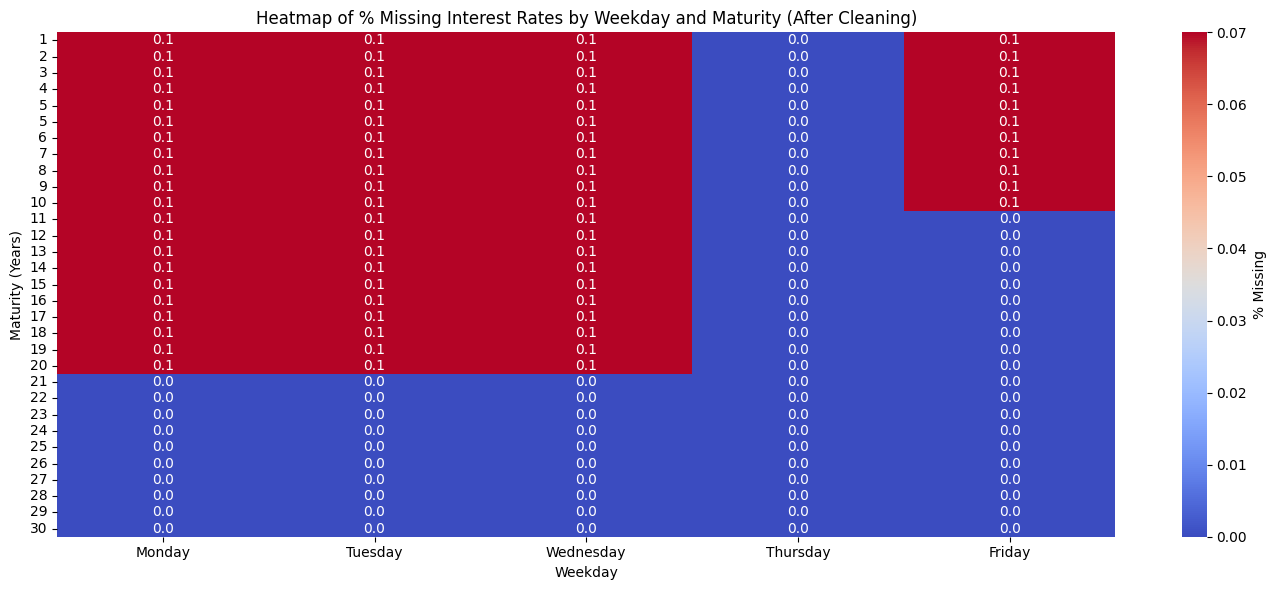


⚠ There are still missing values present — review needed.


In [32]:
print("#-------------------------------------   DATA CLEANING - Heatmap Check On Misisng Data -------------------------------------#")

# Recompute missing values by weekday after cleaning
counts = []
percentages = []

for df in dataframes:
    file_name = df["FileReferenceName"].iloc[0]
    match = re.search(r"R(\d+)X", file_name)
    maturity = int(match.group(1)) if match else file_name

    df = df[df["Date"].notnull()].copy()
    df["Weekday"] = df["Date"].dt.strftime("%A")
    df = df[~df["Weekday"].isin(["Saturday", "Sunday"])]

    total_counts = df["Weekday"].value_counts()
    missing_counts = df[df["Interest Rate"].isnull()]["Weekday"].value_counts()

    row_percentages = {"Maturity": maturity}
    for day in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]:
        total = total_counts.get(day, 0)
        missing = missing_counts.get(day, 0)
        row_percentages[day] = round((missing / total * 100), 2) if total > 0 else 0

    percentages.append(row_percentages)

# Create DataFrame
missing_percent_cleaned_df = pd.DataFrame(percentages).set_index("Maturity").sort_index()

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(missing_percent_cleaned_df, annot=True, fmt=".1f", cmap="coolwarm", cbar_kws={"label": "% Missing"})
plt.title("Heatmap of % Missing Interest Rates by Weekday and Maturity (After Cleaning)")
plt.xlabel("Weekday")
plt.ylabel("Maturity (Years)")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#  Print status message
if (missing_percent_cleaned_df.values == 0).all():
    print("\n Data is ready for exploration — no missing values remain.")
else:
    print("\n⚠ There are still missing values present — review needed.")


---
---
<br><br>
# **<font color='#000058'>Chapter 2: Data Exploration</font>**


### Next steps:

2. Data exploration: For each DataFrame, explore the data to understand its structure, including the number of rows and columns, data types of each column, descriptive statistics (mean, median, standard deviation, min, max) for numerical columns, and the presence of missing values. Also check for the date range covered in each file.

3. Data analysis: Analyze the relationships between different interest rates within each dataset and across datasets. Calculate correlations between different maturity rates. Look for trends and patterns in interest rate movements over time.

4. Data visualization: Create visualizations to represent the key findings. Visualize the time series of interest rates for different maturities. Show the correlation matrix between interest rates. Visualize any significant trends or patterns.

5. Finish task: Summarize the key characteristics of each dataset, highlighting any commonalities or differences across datasets. Present findings from the data exploration and analysis sections in a clear and concise manner, including the visualizations.

### **<font color='#474747'>*2.1.1 - Summary Statistics*</font>**

In [33]:
# Assumes `dataframes` contains the cleaned datasets with columns:
# ['Date', 'Interest Rate', 'Information No IR', 'FileReferenceName', 'Maturity']

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ------------------ Summary Statistics ------------------
summary_stats = []

for df in dataframes:
    maturity = df["Maturity"].iloc[0]
    clean_df = df.dropna(subset=["Interest Rate"])
    summary_stats.append({
        "Maturity": maturity,
        "Count": clean_df["Interest Rate"].count(),
        "Mean": clean_df["Interest Rate"].mean(),
        "Median": clean_df["Interest Rate"].median(),
        "Std": clean_df["Interest Rate"].std(),
        "Min": clean_df["Interest Rate"].min(),
        "Max": clean_df["Interest Rate"].max()
    })

stats_df = pd.DataFrame(summary_stats).set_index("Maturity").sort_index()
display(stats_df)


Count      Mean  Median       Std   Min   Max
Maturity                                               
0.5        7070  1.518844   1.640  1.834552 -0.98  5.12
1.0        7070  1.562951   1.790  1.843166 -0.97  5.23
2.0        7070  1.659748   1.880  1.865036 -1.02  5.32
3.0        7070  1.780074   1.990  1.886711 -1.02  5.33
4.0        7070  1.913233   2.170  1.901725 -1.00  5.35
5.0        7070  2.049522   2.320  1.909483 -0.98  5.42
6.0        7070  2.182456   2.430  1.911582 -0.95  5.48
7.0        7070  2.308267   2.480  1.910174 -0.93  5.61
8.0        7070  2.424786   2.550  1.907133 -0.91  5.73
9.0        7070  2.531220   2.660  1.903685 -0.88  5.84
10.0       7070  2.627331   2.755  1.900212 -0.85  5.97
11.0       7070  2.713419   2.835  1.897518 -0.82  6.08
12.0       7070  2.790133   2.910  1.895548 -0.80  6.18
13.0       7070  2.857983   2.975  1.894309 -0.77  6.28
14.0       7070  2.917746   3.040  1.893836 -0.74  6.36
15.0       7070  2.970178   3.090  1.894181 -0.72  6.43
16.0       7070  3.015972   3.125  1.894994 -0.69  6.50
17.0       7070  3.055724   3.160  1.896485 -0.67  6.55
18.0       7070  3.090136   3.180  1.898286 -0.65  6.60
19.0       7070  3.119757   3.200  1.900529 -0.64  6.65
20.0       7070  3.145089   3.210  1.903166 -0.62  6.69
21.0       6310  2.872873   2.800  1.800684 -0.61  5.98
22.0       6310  2.888792   2.800  1.801197 -0.60  6.03
23.0       6310  2.901715   2.790  1.801848 -0.58  6.07
24.0       6310  2.911838   2.780  1.802577 -0.57  6.10
25.0       6310  2.919583   2.765  1.803316 -0.56  6.13
26.0       6310  2.925162   2.750  1.804180 -0.55  6.17
27.0       6310  2.928929   2.730  1.805219 -0.54  6.19
28.0       6310  2.931231   2.710  1.806282 -0.52  6.22
29.0       6310  2.932036   2.690  1.807581 -0.51  6.25
30.0       6310  2.931625   2.670  1.808937 -0.50  6.27

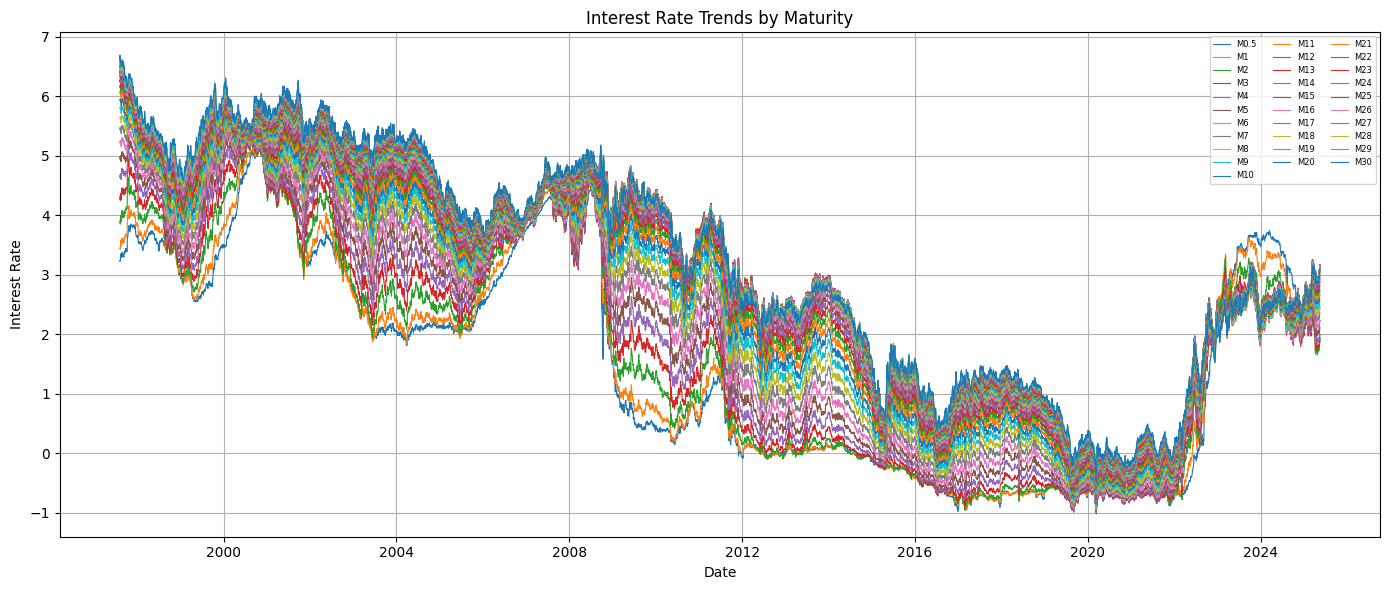

In [34]:
plt.figure(figsize=(14, 6))
for df in dataframes:
    plt.plot(df["Date"], df["Interest Rate"], label=f'M{df["Maturity"].iloc[0]}', linewidth=0.8)

plt.title('Interest Rate Trends by Maturity')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.legend(loc='upper right', fontsize=6, ncol=3)
plt.grid(True)
plt.tight_layout()
plt.show()


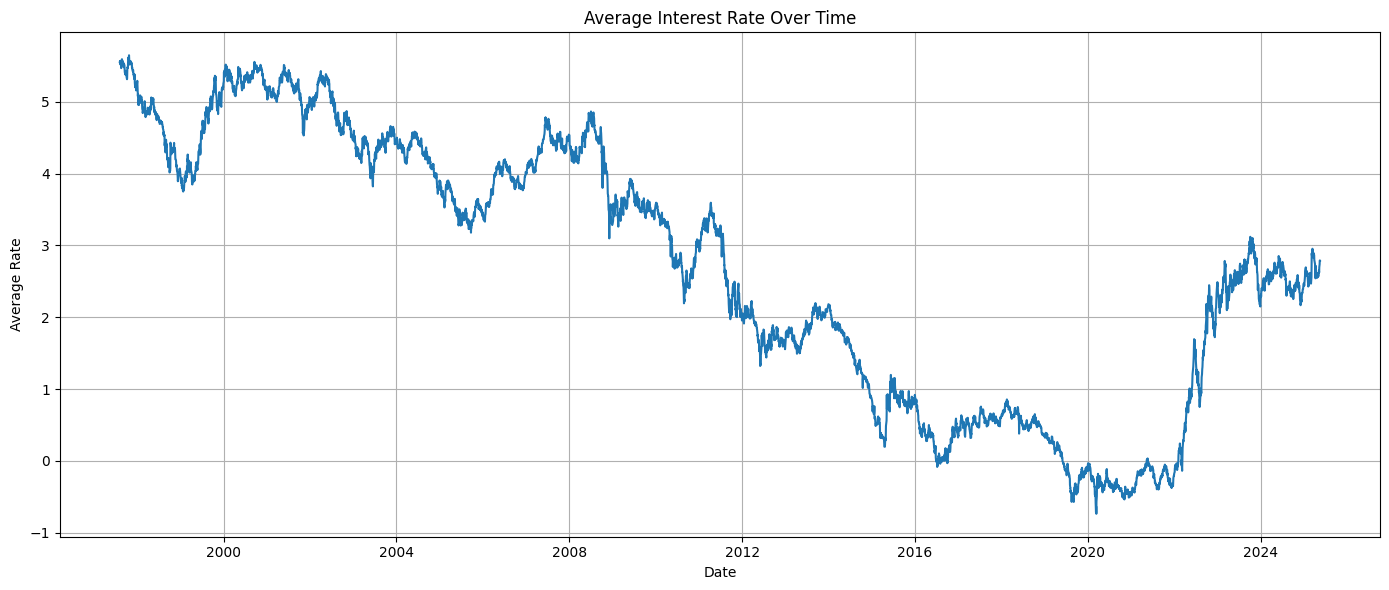

In [35]:
combined_df = pd.concat([df.dropna(subset=["Interest Rate"]) for df in dataframes], ignore_index=True)
daily_avg = combined_df.groupby("Date")["Interest Rate"].mean().reset_index()

plt.figure(figsize=(14, 6))
plt.plot(daily_avg["Date"], daily_avg["Interest Rate"], label="Average Rate")
plt.title("Average Interest Rate Over Time")
plt.xlabel("Date")
plt.ylabel("Average Rate")
plt.grid(True)
plt.tight_layout()
plt.show()


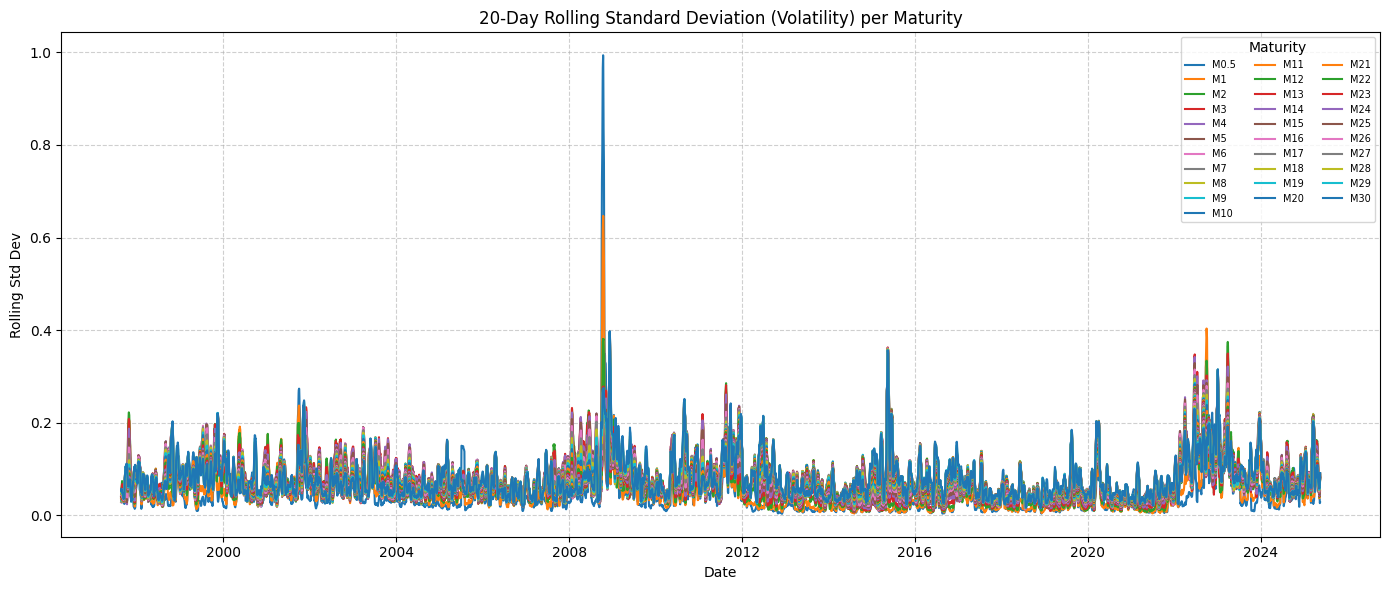

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# ----------------- Merge Cleaned DataFrames into Wide Format -----------------

# Start with an empty DataFrame
merged_df = pd.DataFrame()

# Create wide-format merged dataframe: one column per maturity
for df in dataframes:
    maturity = df["Maturity"].iloc[0]
    temp = df[["Date", "Interest Rate"]].copy()
    temp = temp.rename(columns={"Interest Rate": f"M{maturity}"})
    if merged_df.empty:
        merged_df = temp
    else:
        merged_df = pd.merge(merged_df, temp, on="Date", how="outer")

# ----------------- 20-Day Rolling Std Dev Plot -----------------

plt.figure(figsize=(14, 6))

# Plot the rolling volatility for each maturity
for col in merged_df.columns:
    if col == 'Date':
        continue
    rolling_std = merged_df[col].rolling(window=20, min_periods=10).std()
    plt.plot(merged_df['Date'], rolling_std, label=col)

plt.title("20-Day Rolling Standard Deviation (Volatility) per Maturity")
plt.xlabel("Date")
plt.ylabel("Rolling Std Dev")
plt.legend(title="Maturity", fontsize=7, ncol=3)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

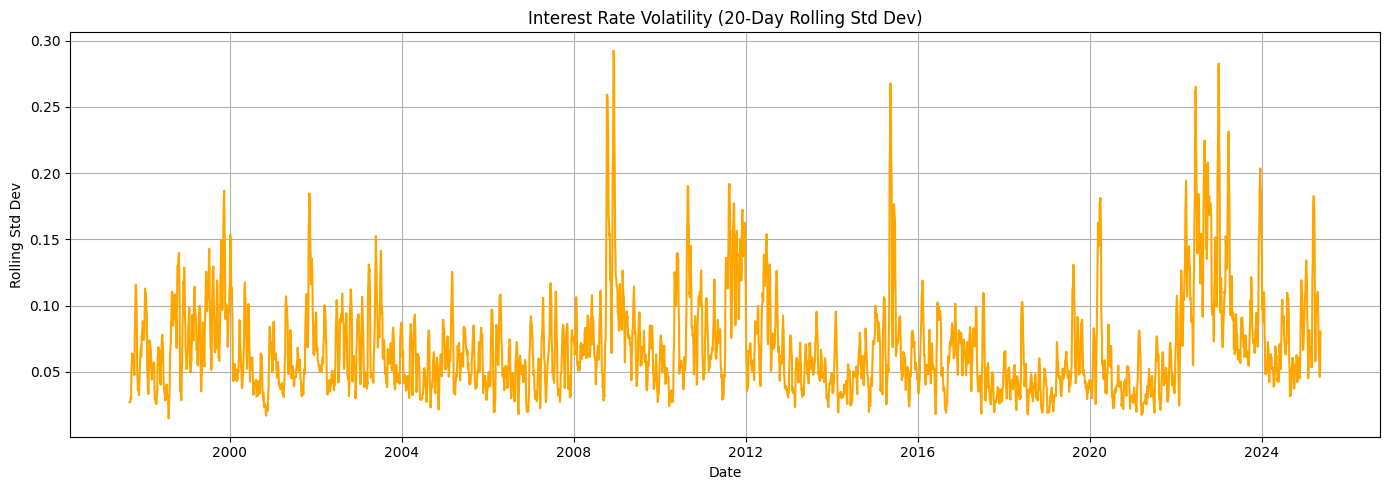

In [37]:
daily_avg["RollingStd"] = daily_avg["Interest Rate"].rolling(window=20).std()

plt.figure(figsize=(14, 5))
plt.plot(daily_avg["Date"], daily_avg["RollingStd"], color='orange')
plt.title("Interest Rate Volatility (20-Day Rolling Std Dev)")
plt.xlabel("Date")
plt.ylabel("Rolling Std Dev")
plt.grid(True)
plt.tight_layout()
plt.show()


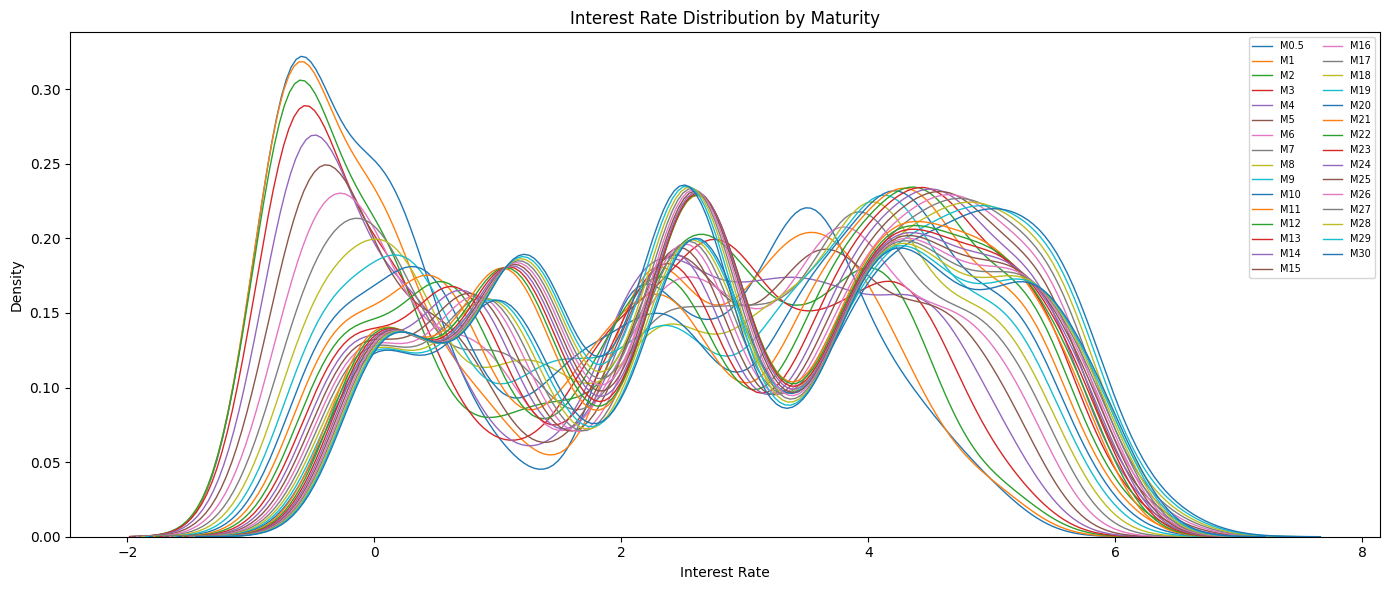

In [38]:
plt.figure(figsize=(14, 6))
for col in merged_df.columns[1:]:
    sns.kdeplot(data=merged_df[col], label=col, linewidth=1)

plt.title("Interest Rate Distribution by Maturity")
plt.xlabel("Interest Rate")
plt.legend(fontsize=7, ncol=2)
plt.tight_layout()
plt.show()


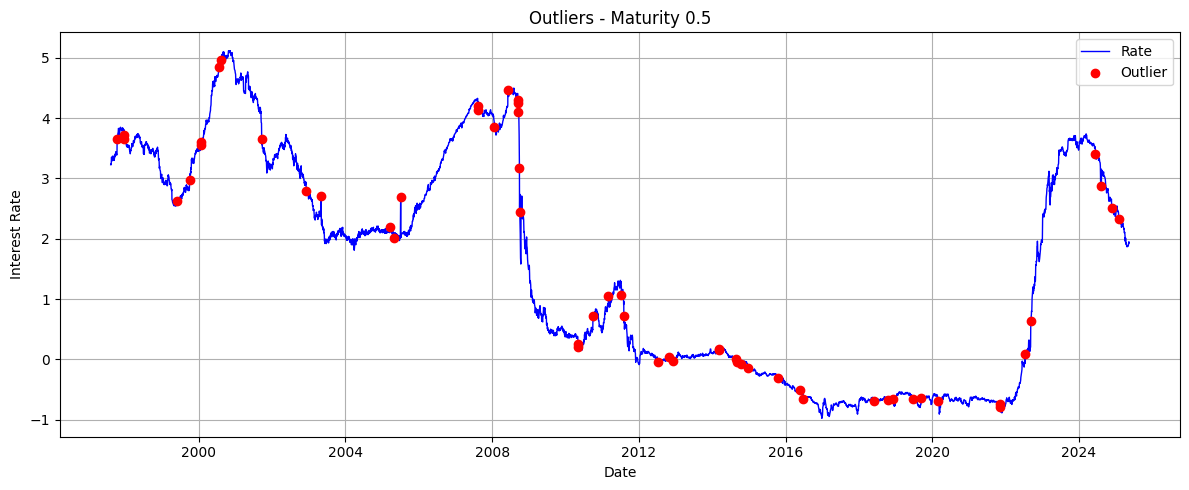

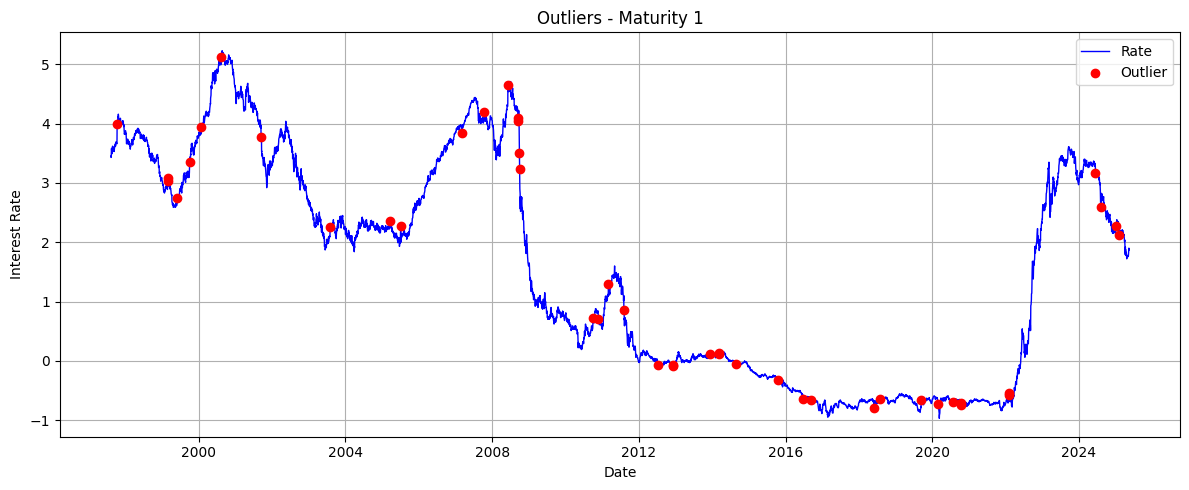

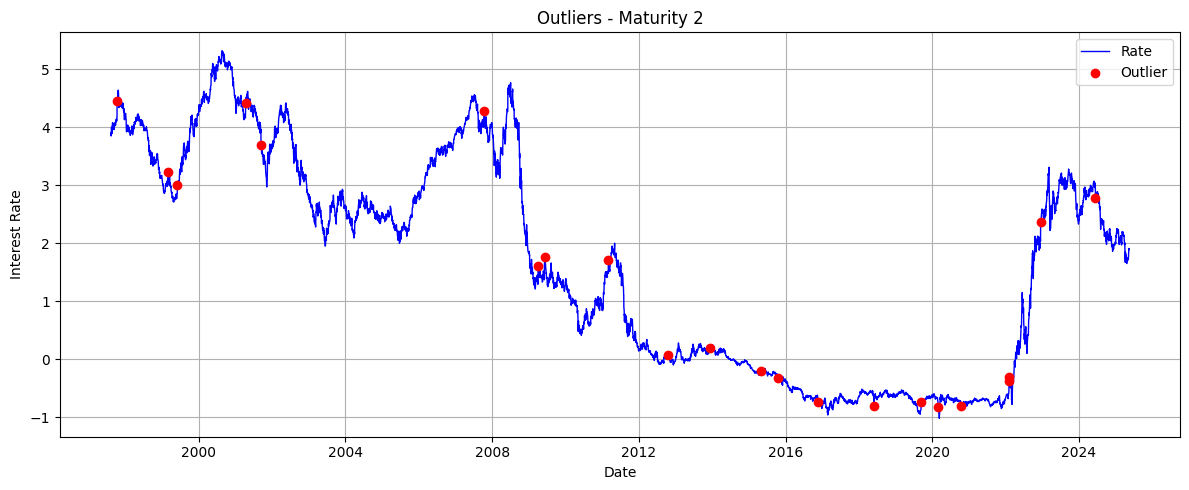

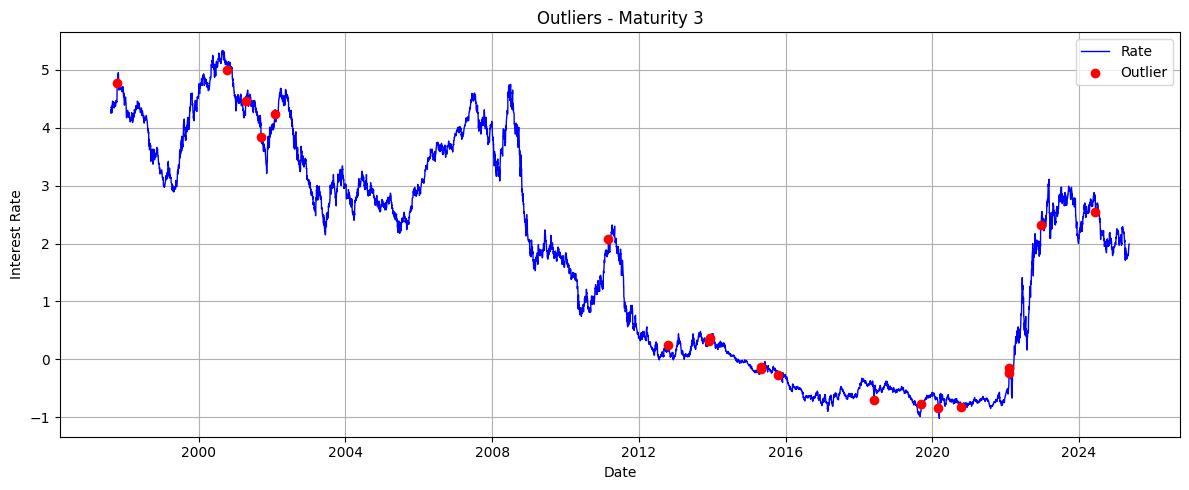

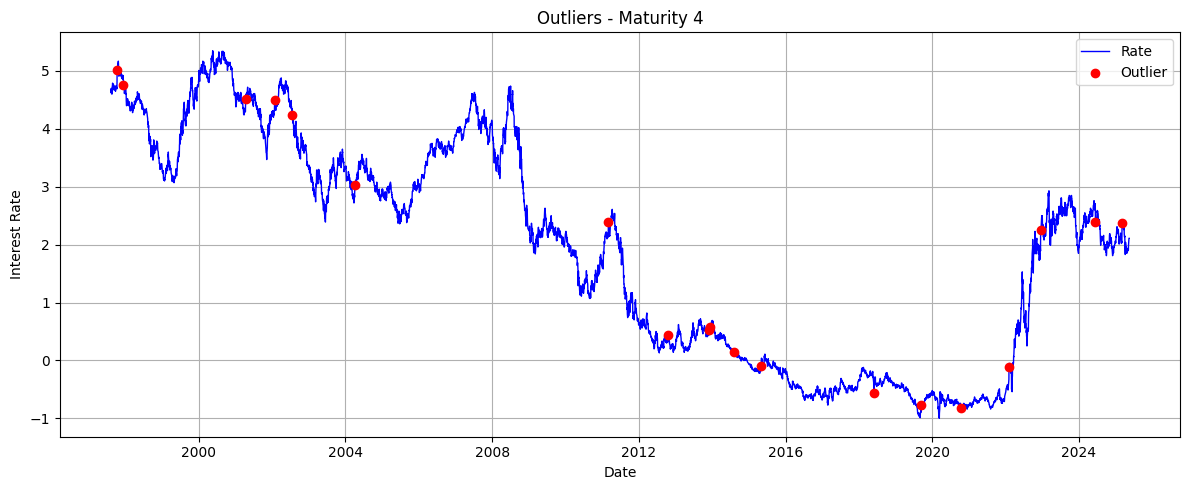

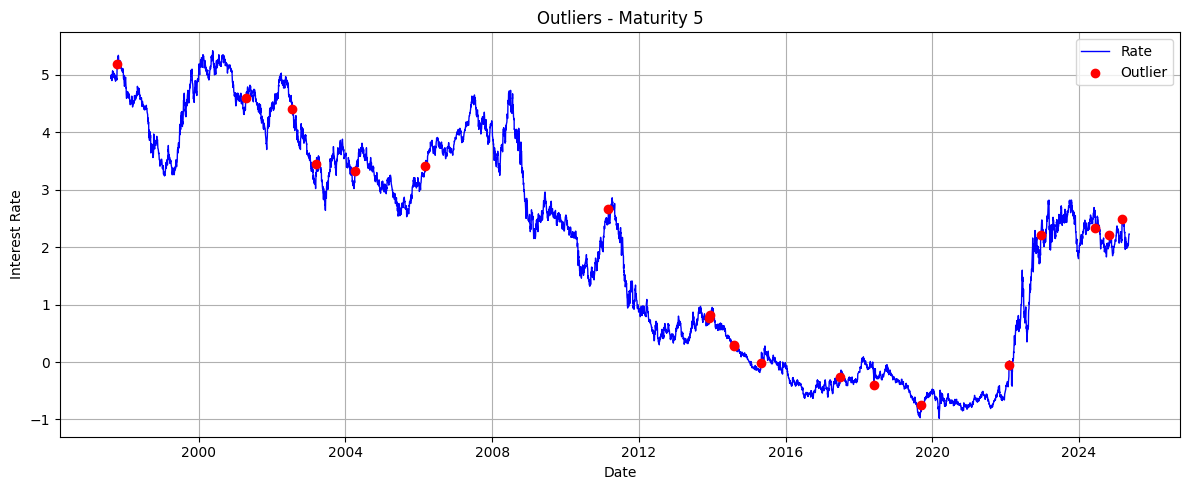

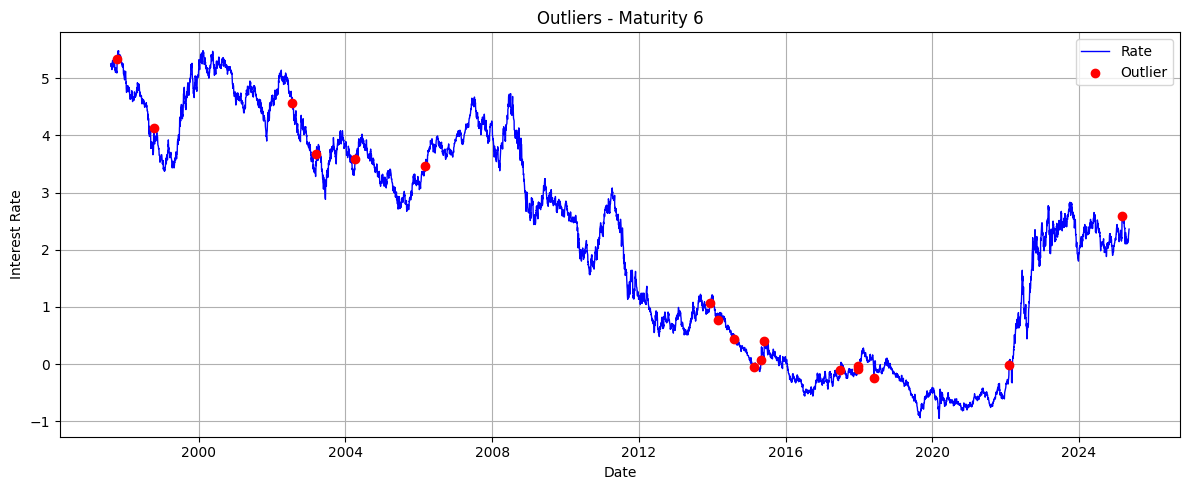

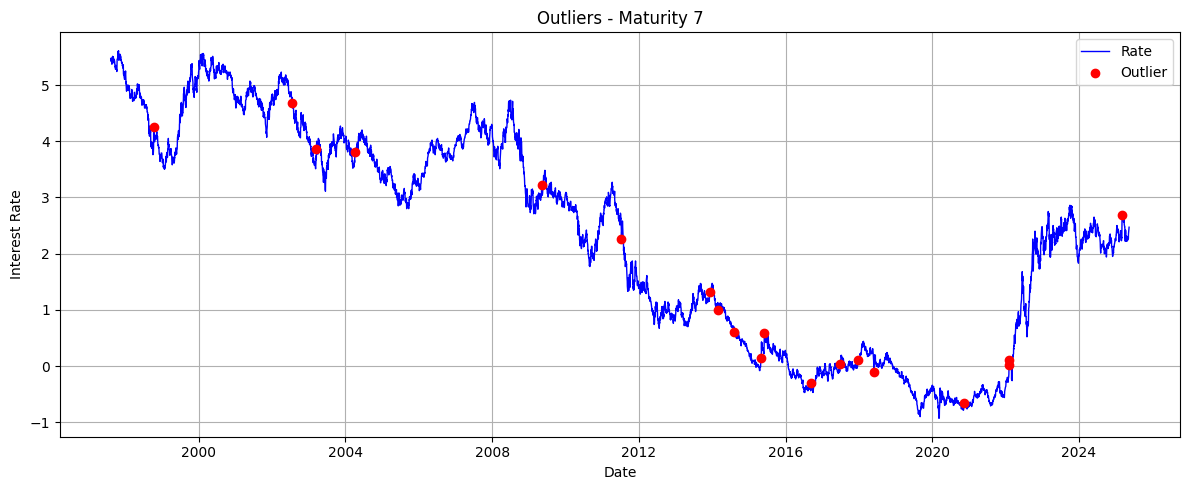

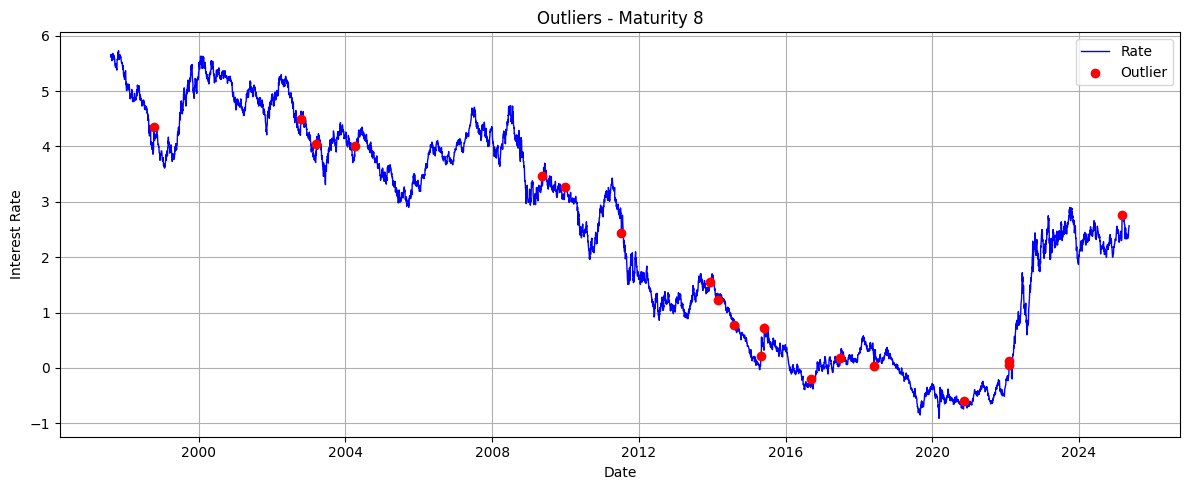

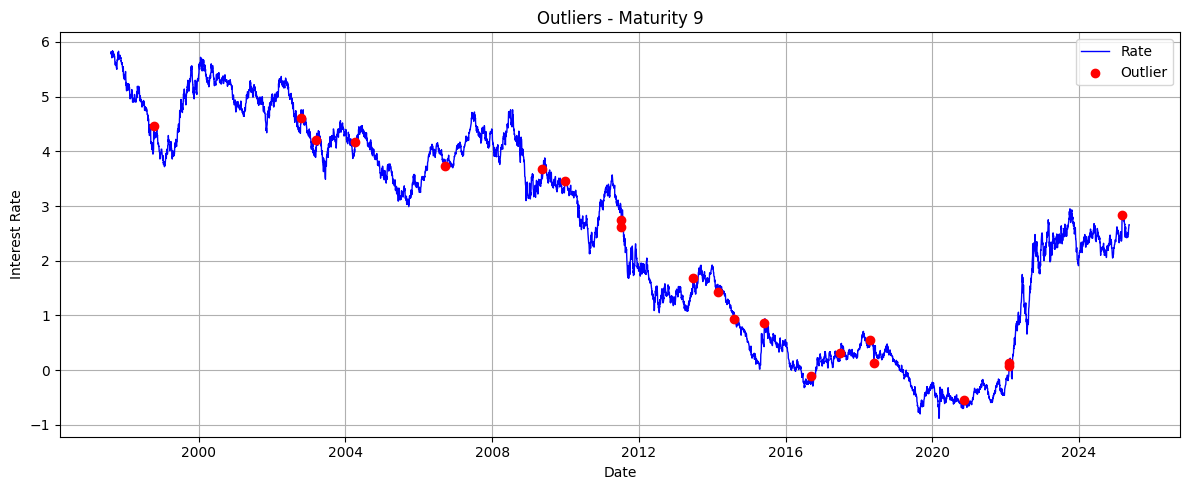

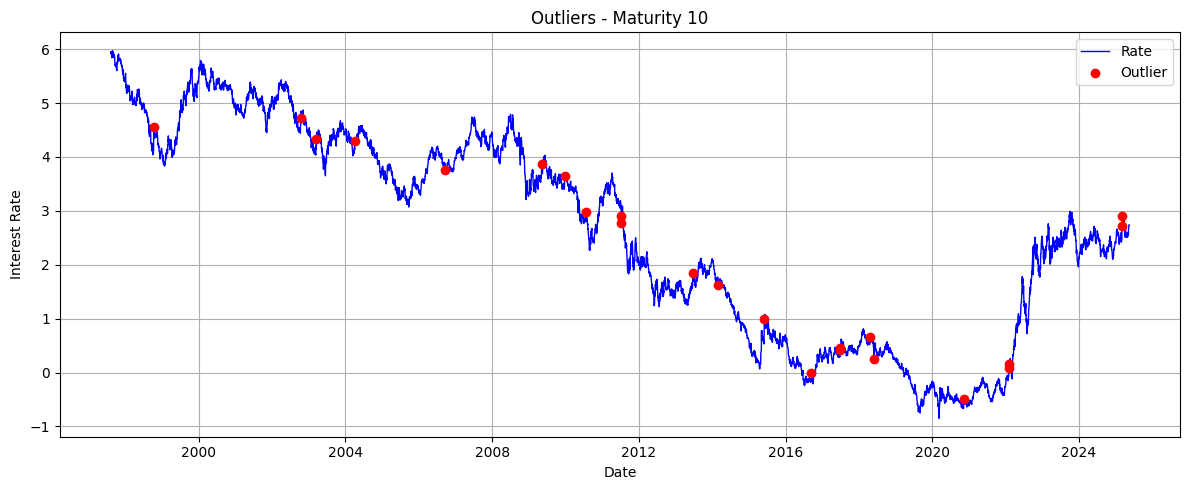

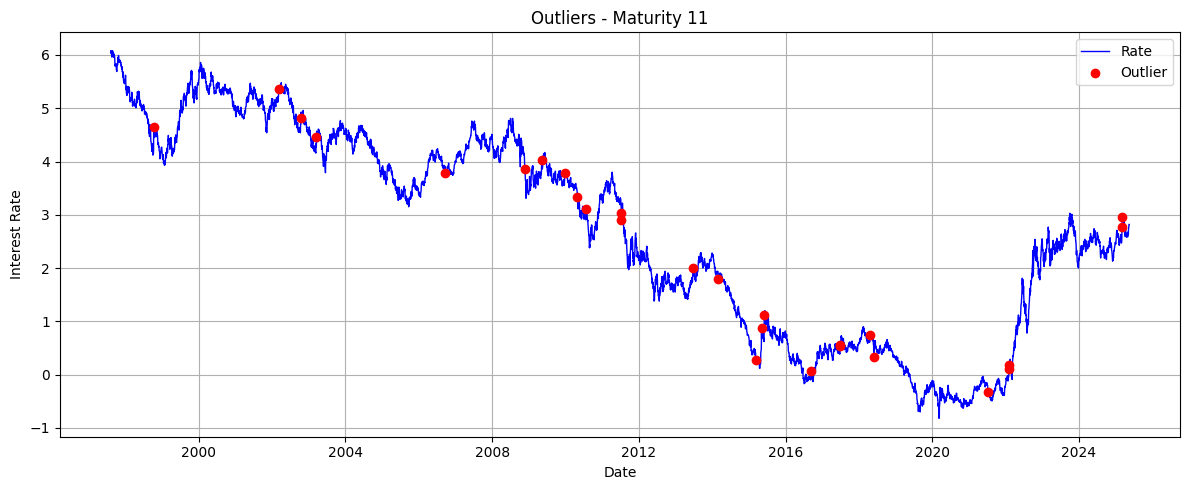

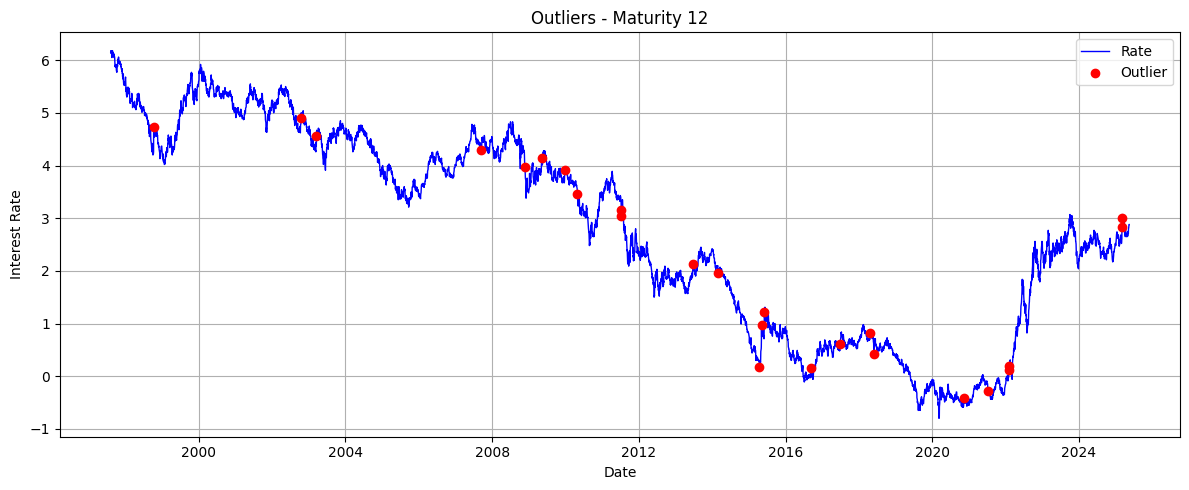

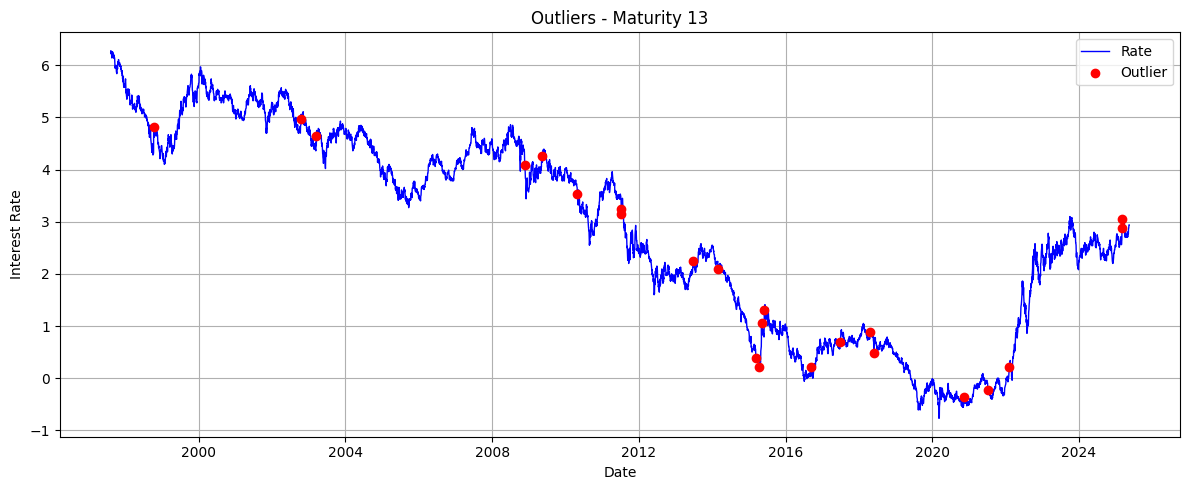

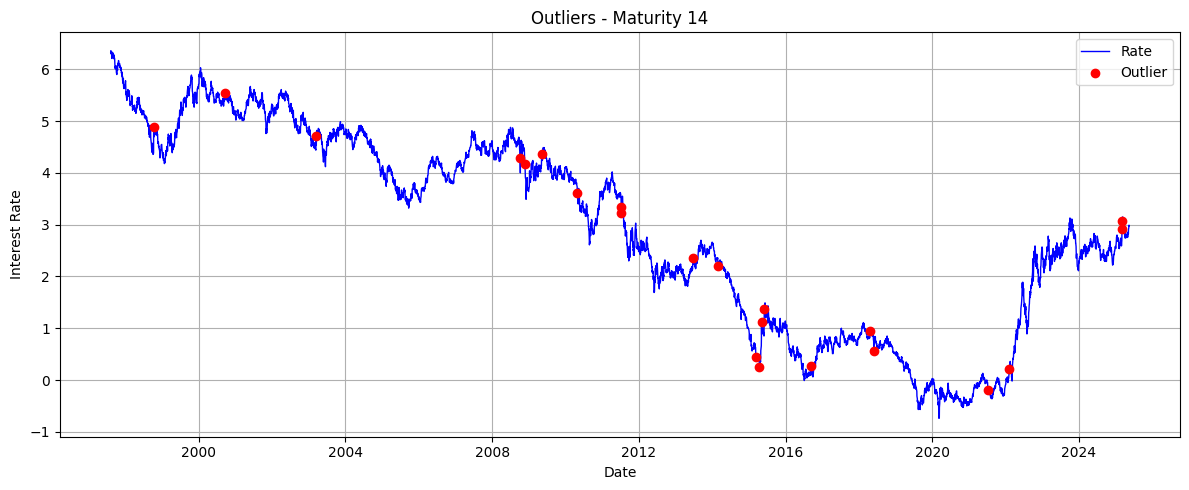

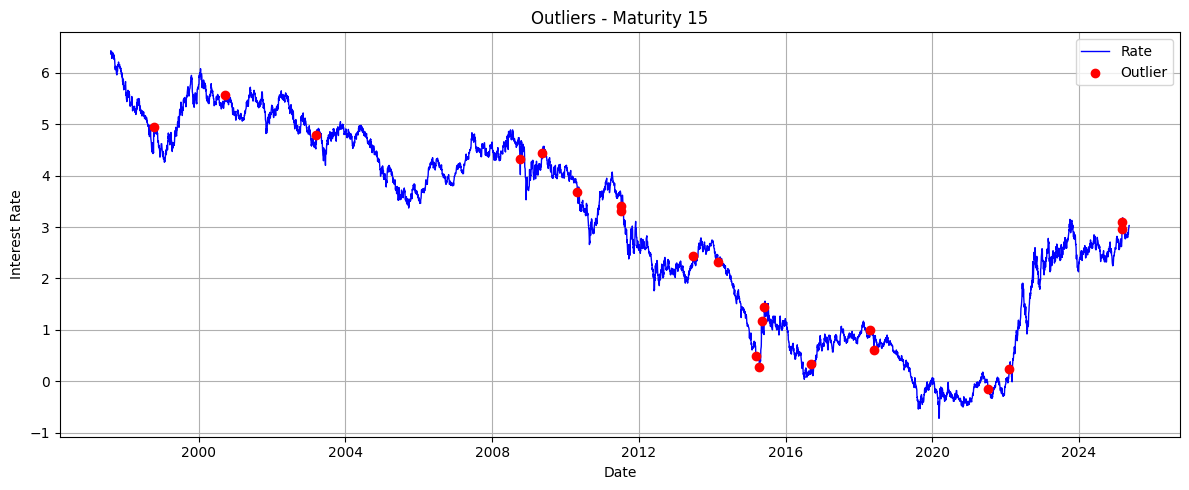

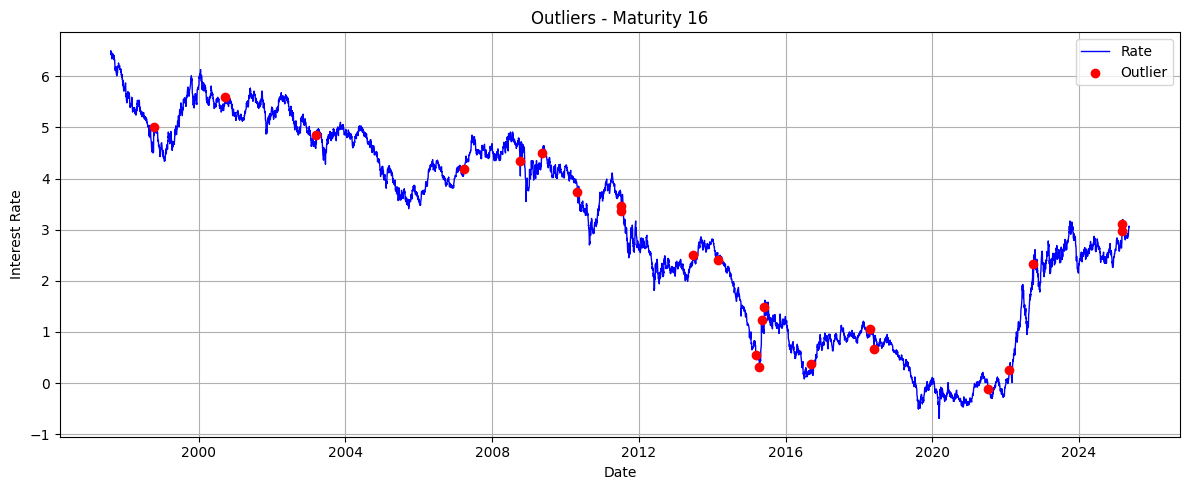

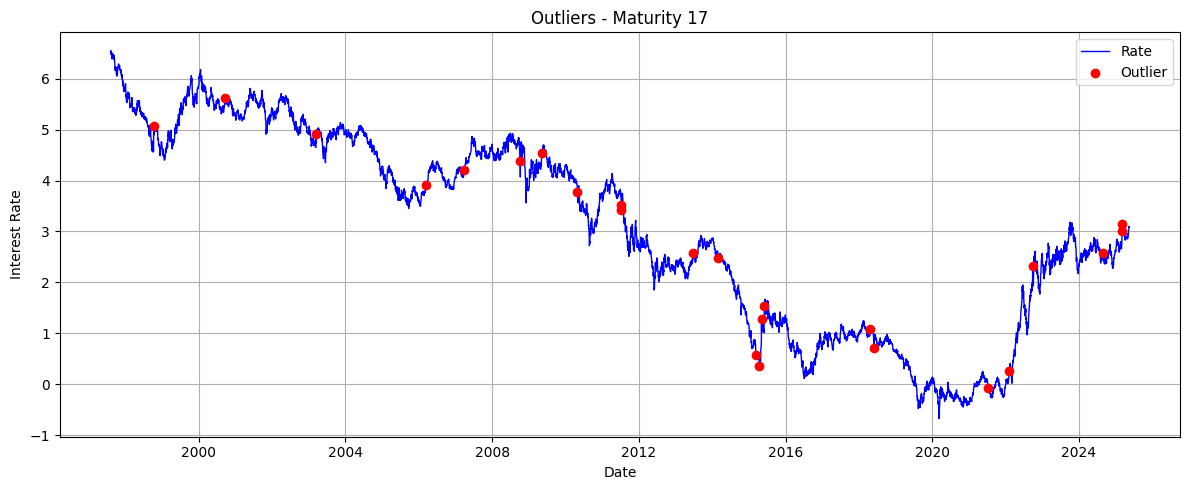

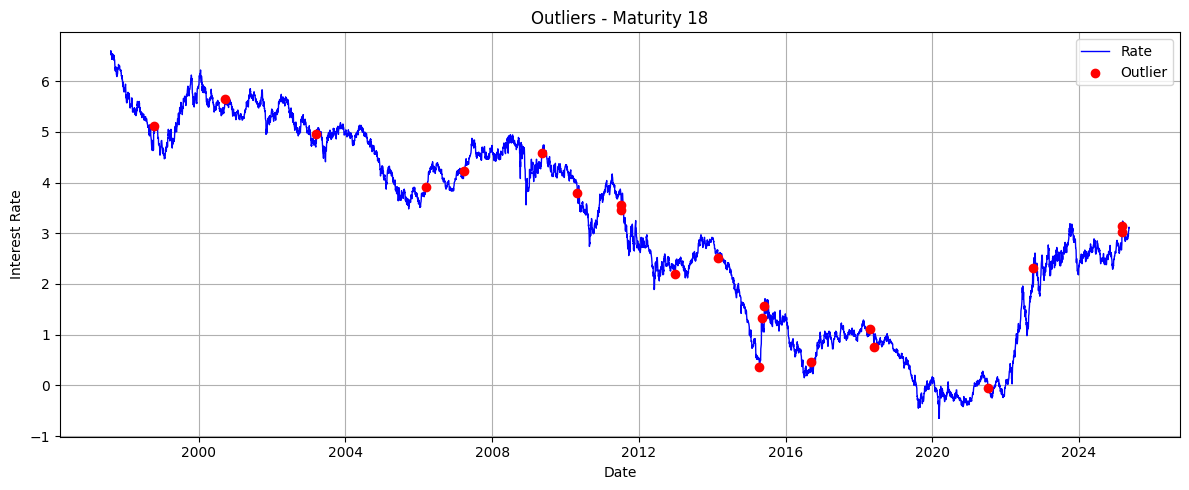

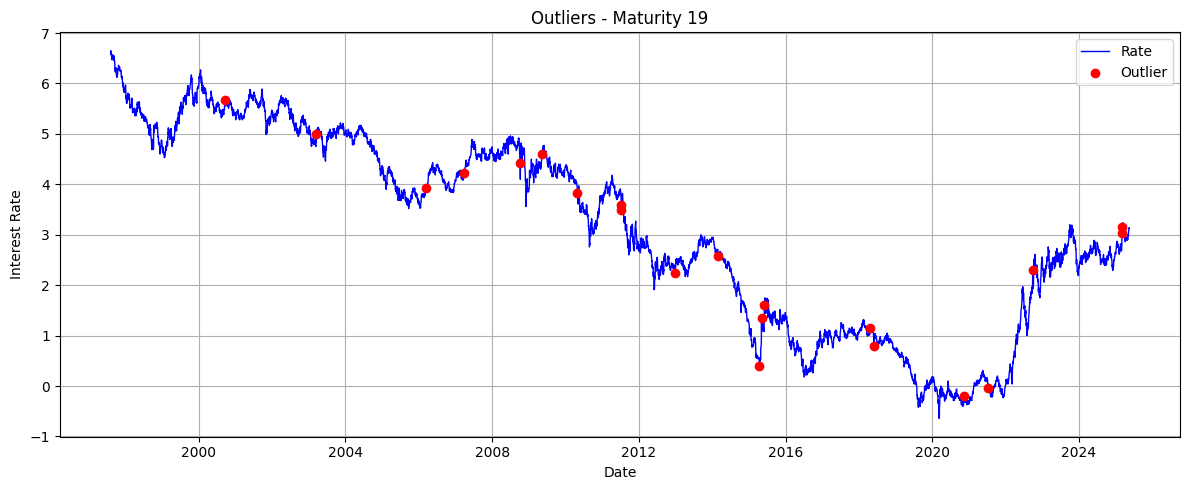

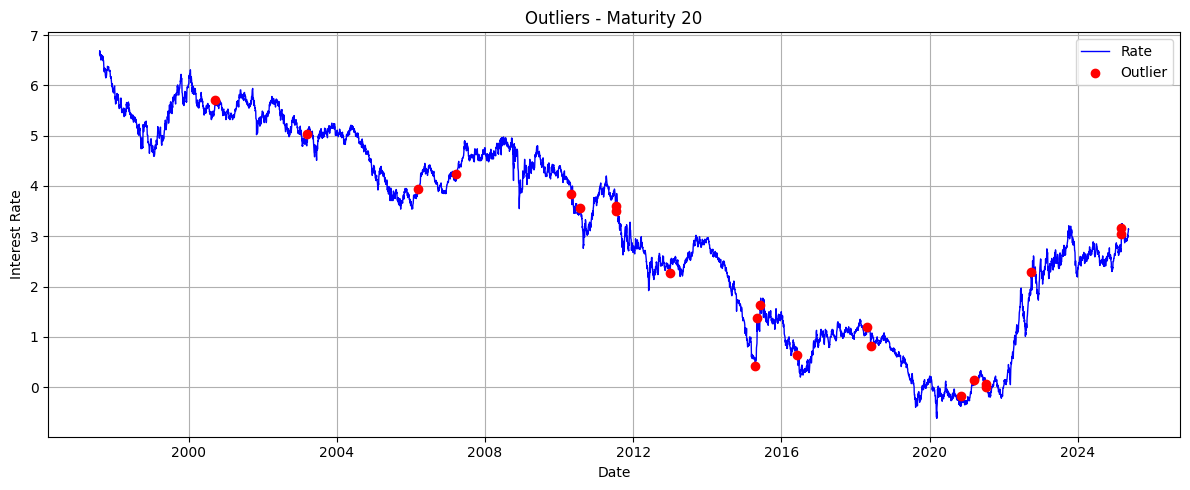

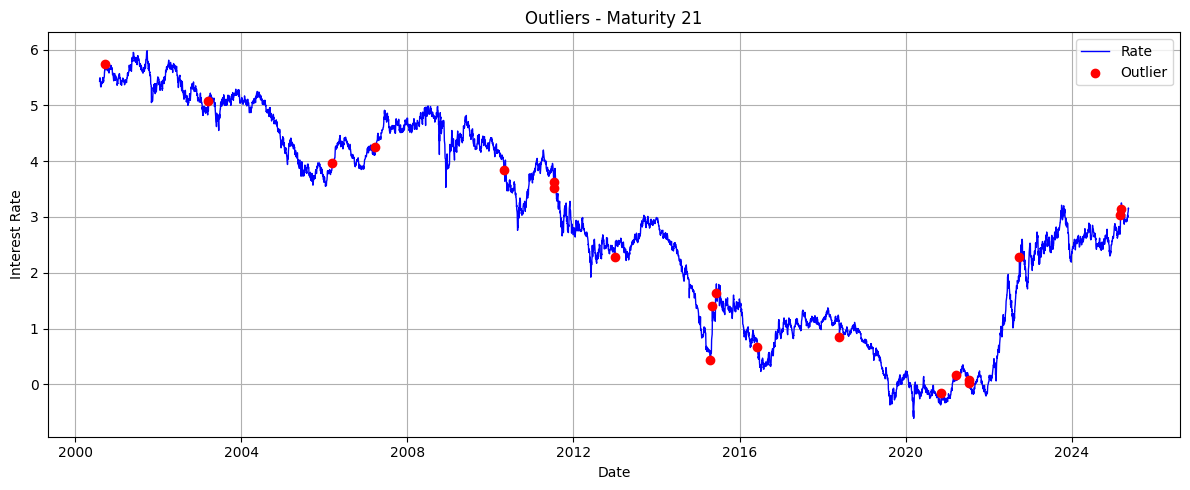

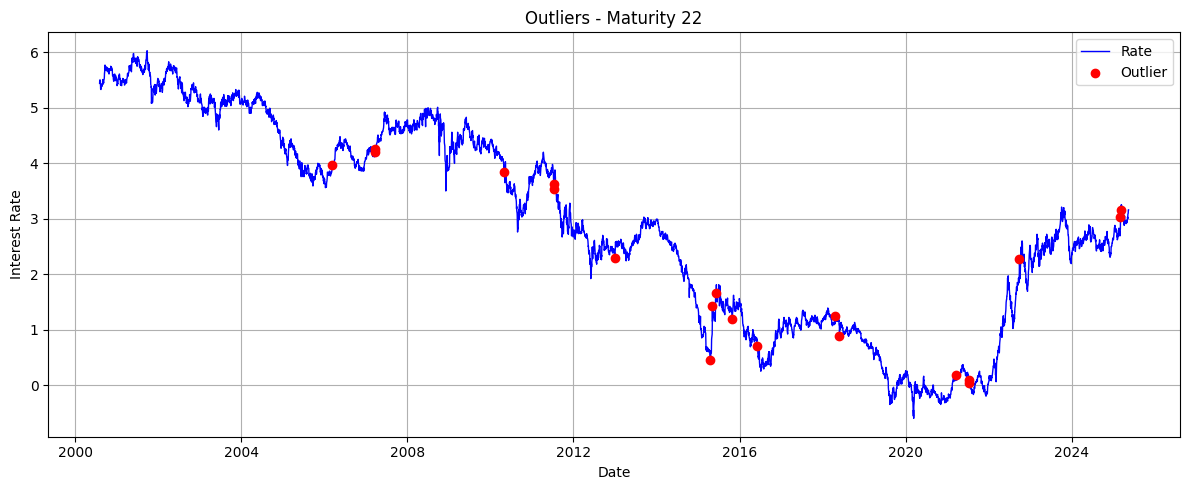

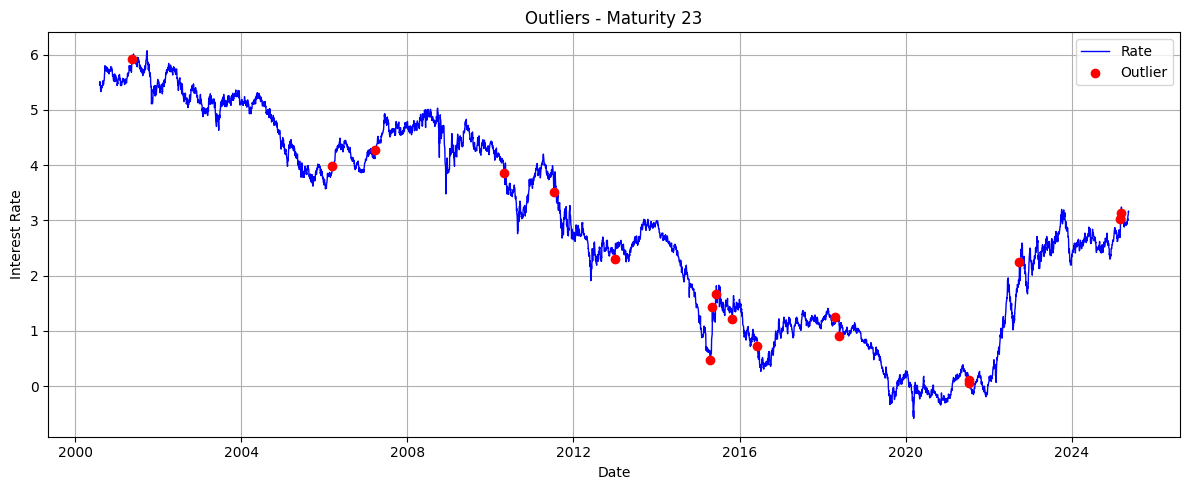

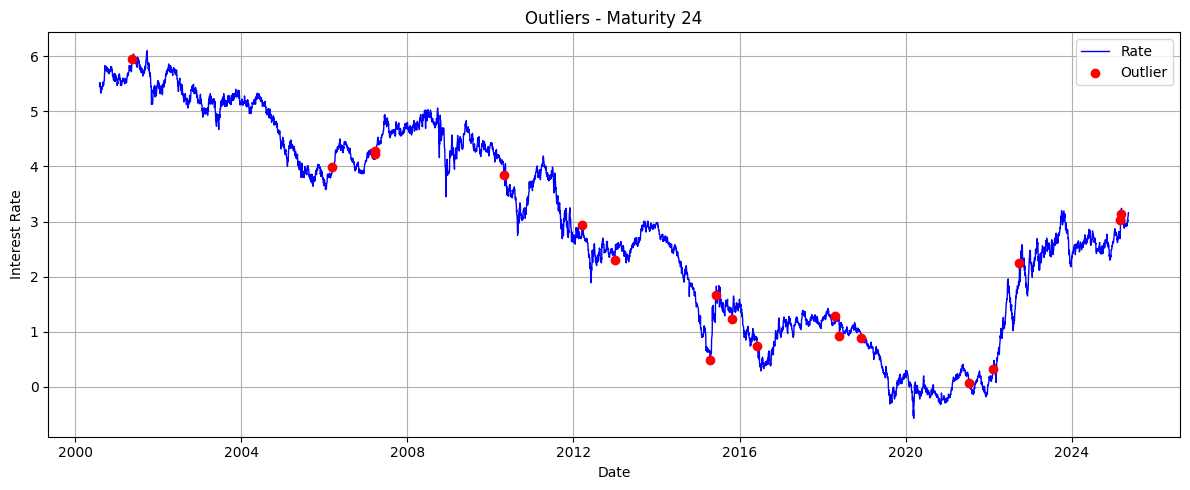

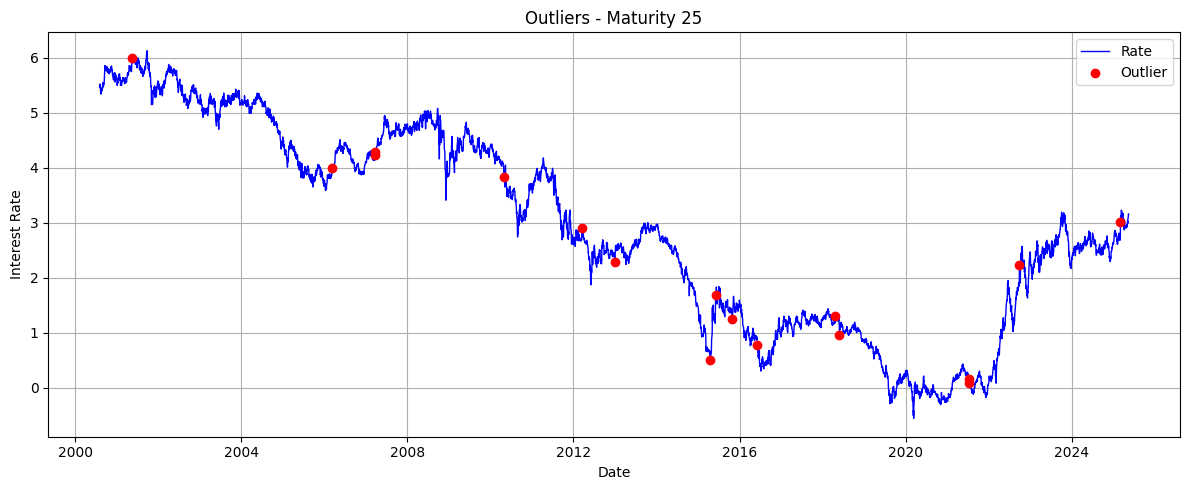

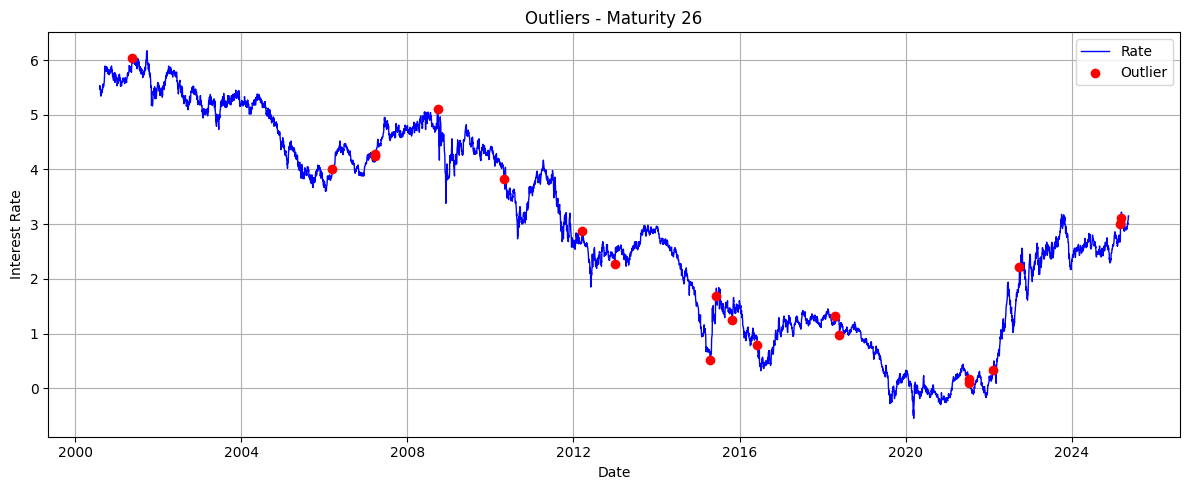

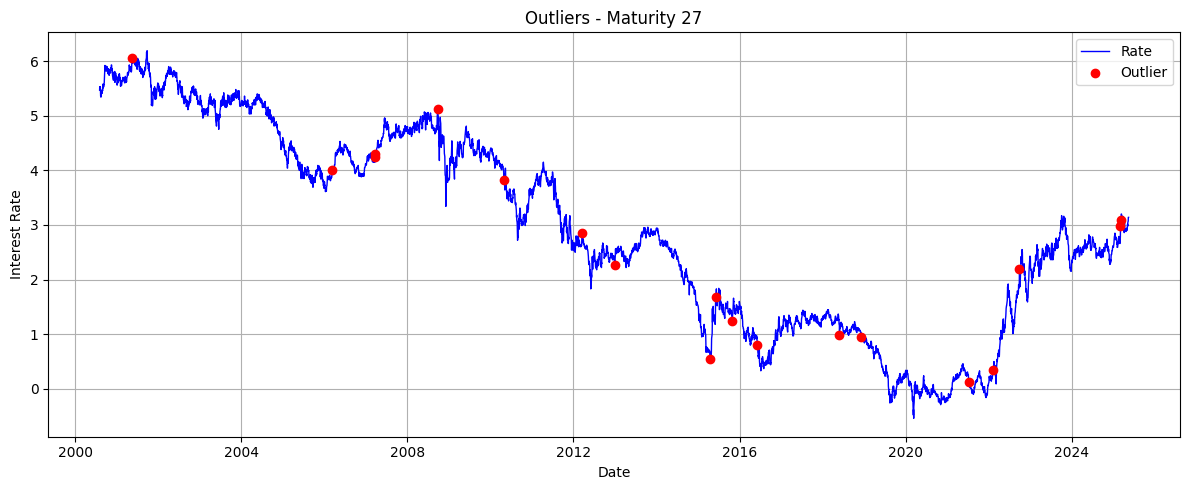

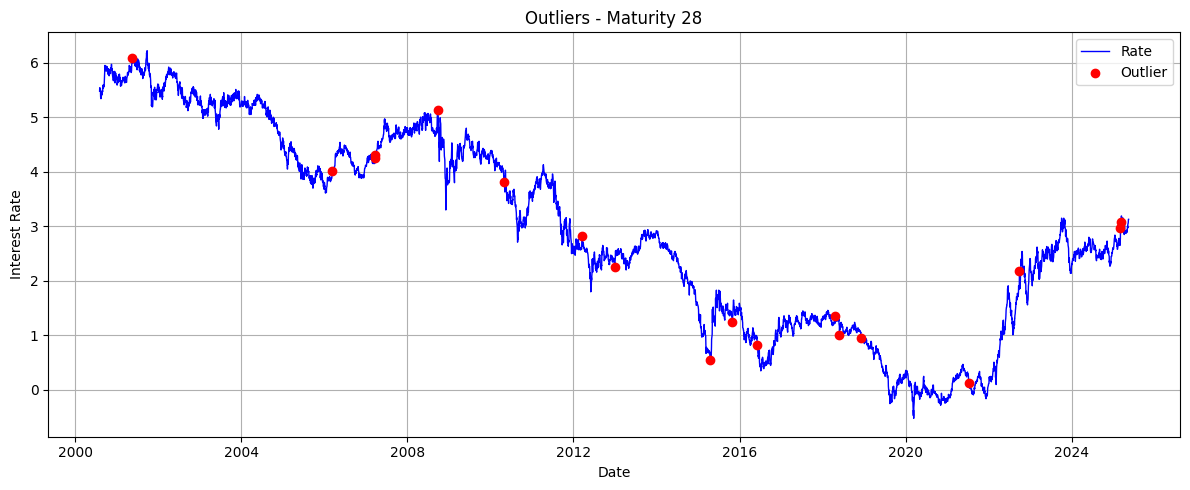

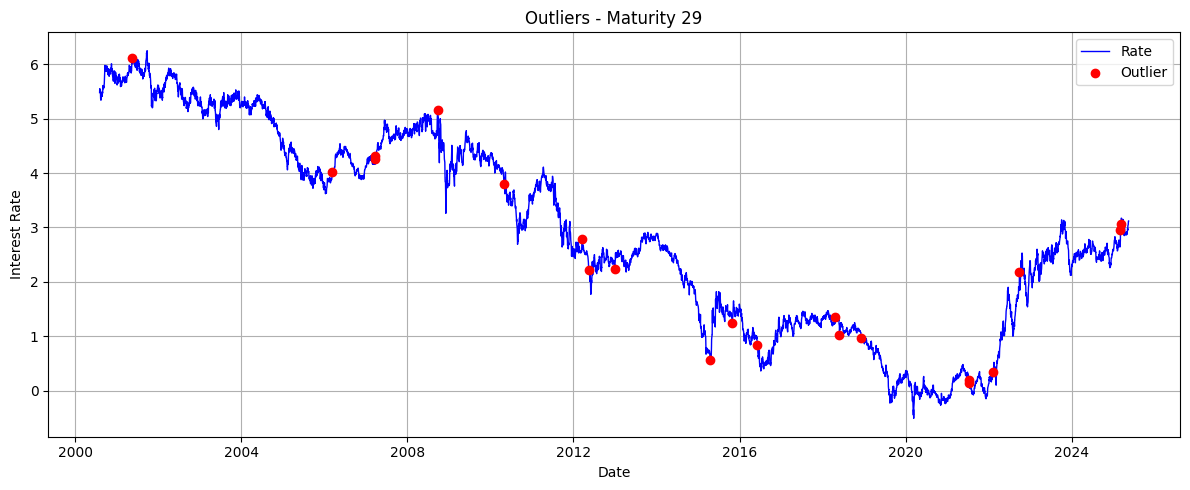

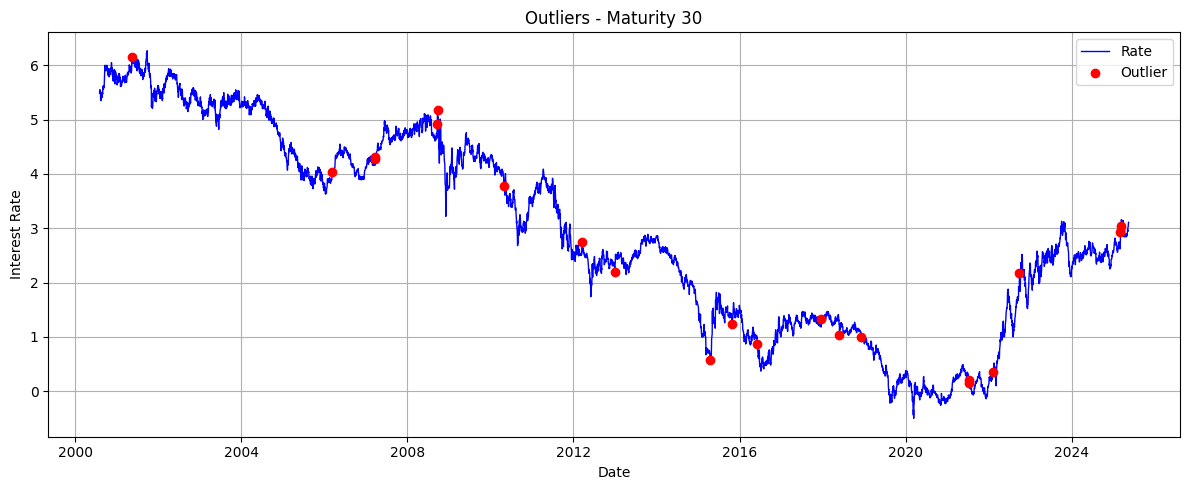

Outlier Count  Max Outlier  Min Outlier
Maturity                                         
0.5                  56         4.97        -0.79
1.0                  45         5.13        -0.80
2.0                  22         4.45        -0.82
3.0                  20         4.99        -0.84
4.0                  19         5.01        -0.83
5.0                  20         5.19        -0.75
6.0                  18         5.34        -0.24
7.0                  19         4.68        -0.65
8.0                  19         4.49        -0.60
9.0                  21         4.61        -0.55
10.0                 23         4.72        -0.50
11.0                 27         5.36        -0.33
12.0                 25         4.90        -0.41
13.0                 23         4.97        -0.37
14.0                 22         5.54        -0.19
15.0                 21         5.57        -0.15
16.0                 23         5.59        -0.11
17.0                 24         5.62        -0.08
18.0                 21         5.65        -0.05
19.0                 21         5.68        -0.20
20.0                 22         5.71        -0.18
21.0                 20         5.74        -0.16
22.0                 20         4.26         0.04
23.0                 18         5.92         0.06
24.0                 19         5.95         0.07
25.0                 17         5.99         0.09
26.0                 20         6.03         0.10
27.0                 19         6.06         0.12
28.0                 18         6.09         0.13
29.0                 21         6.12         0.14
30.0                 21         6.15         0.15

In [39]:
window_size = 20
z_threshold = 3
outlier_summary = []

for df in dataframes:
    df = df.copy().sort_values("Date")
    maturity = df["Maturity"].iloc[0]

    df["RollingMean"] = df["Interest Rate"].rolling(window=window_size, min_periods=10).mean()
    df["RollingStd"] = df["Interest Rate"].rolling(window=window_size, min_periods=10).std()
    df["ZScore"] = (df["Interest Rate"] - df["RollingMean"]) / df["RollingStd"]
    df["Outlier"] = df["ZScore"].abs() > z_threshold

    outliers = df[df["Outlier"]]

    plt.figure(figsize=(12, 5))
    plt.plot(df["Date"], df["Interest Rate"], label="Rate", color="blue", linewidth=1)
    plt.scatter(outliers["Date"], outliers["Interest Rate"], color="red", label="Outlier", zorder=5)
    plt.title(f'Outliers - Maturity {maturity}')
    plt.xlabel("Date")
    plt.ylabel("Interest Rate")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    outlier_summary.append({
        "Maturity": maturity,
        "Outlier Count": len(outliers),
        "Max Outlier": outliers["Interest Rate"].max(),
        "Min Outlier": outliers["Interest Rate"].min()
    })

outlier_df = pd.DataFrame(outlier_summary).set_index("Maturity").sort_index()
display(outlier_df)



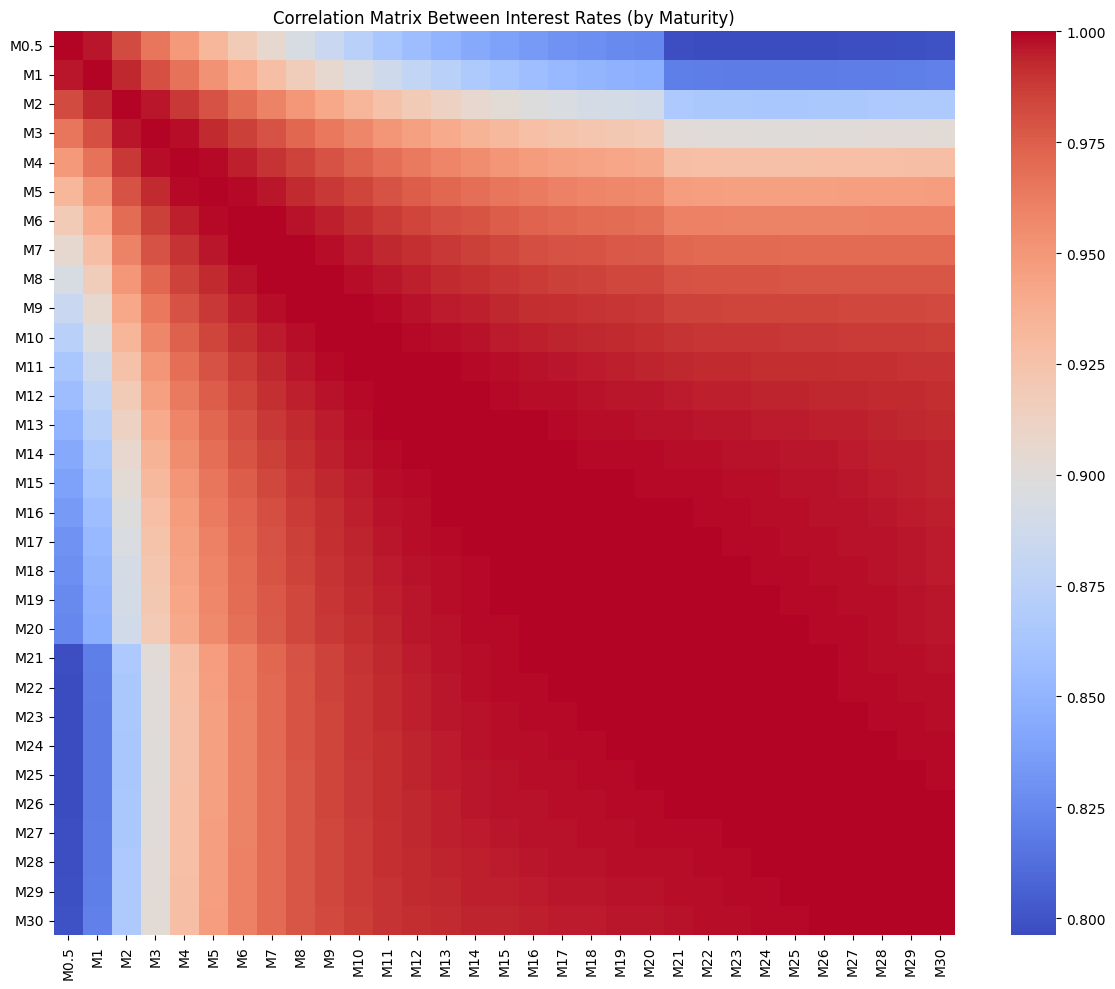

In [40]:
# Create merged wide format DataFrame
merged_df = pd.DataFrame()
for df in dataframes:
    maturity = df["Maturity"].iloc[0]
    temp = df[["Date", "Interest Rate"]].rename(columns={"Interest Rate": f"M{maturity}"})
    merged_df = temp if merged_df.empty else pd.merge(merged_df, temp, on="Date", how="outer")

# Drop date for correlation matrix
correlation_matrix = merged_df.drop(columns="Date").corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False)
plt.title("Correlation Matrix Between Interest Rates (by Maturity)")
plt.tight_layout()
plt.show()


# EGON DRAFT TESTS

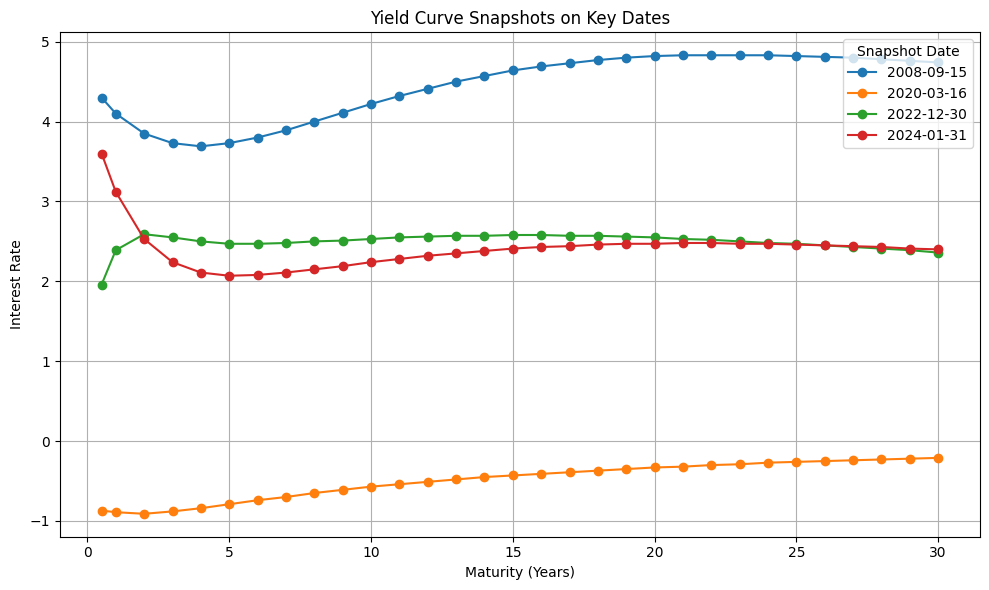

In [41]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Select snapshot dates
snapshot_dates = ['2008-09-15', '2020-03-16', '2022-12-30', '2024-01-31']
snapshot_dates = pd.to_datetime(snapshot_dates)

# 2. Extract yield curves for each date
curve_data = {}

for date in snapshot_dates:
    row = merged_df[merged_df['Date'] == date]
    if not row.empty:
        rates = row.drop(columns='Date').iloc[0]
        maturities = [float(col[1:]) for col in rates.index]  # strip 'M' and convert to float
        curve_data[date.strftime('%Y-%m-%d')] = pd.Series(rates.values, index=maturities)

# 3. Plot yield curves
plt.figure(figsize=(10, 6))
for label, series in curve_data.items():
    plt.plot(series.index, series.values, marker='o', label=label)

plt.title("Yield Curve Snapshots on Key Dates")
plt.xlabel("Maturity (Years)")
plt.ylabel("Interest Rate")
plt.legend(title="Snapshot Date")
plt.grid(True)
plt.tight_layout()
plt.show()

2008-09-15: Likely steep yield curve (low short rates, higher long rates).

2020-03-16: Extremely low rates across maturities (flight to safety).

2022-12-30: Curve may flatten or invert due to ECB hikes.

2024-12-31: Most recent economic sentiment — potentially reflation or normalization.

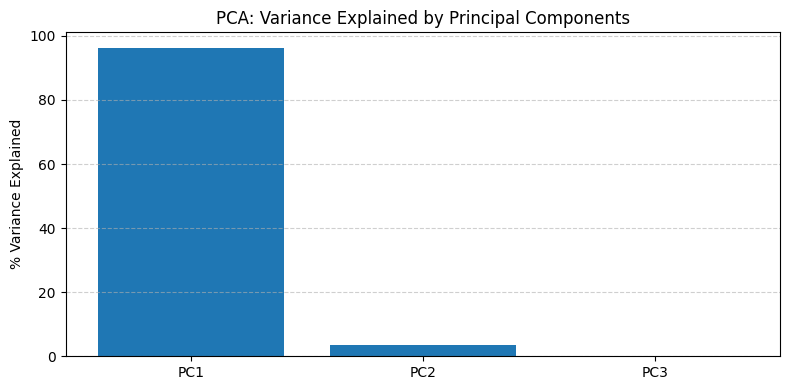

In [42]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare PCA-ready data (drop missing rows)
pca_df = merged_df.dropna().copy()

# 2. Extract only the maturity columns
maturity_cols = [col for col in pca_df.columns if col != 'Date']
X = pca_df[maturity_cols].values

# 3. Standardize (mean 0, std 1)
X_scaled = StandardScaler().fit_transform(X)

# 4. Run PCA
pca = PCA(n_components=3)
principal_components = pca.fit_transform(X_scaled)

# 5. Plot explained variance
plt.figure(figsize=(8, 4))
explained = pca.explained_variance_ratio_ * 100
plt.bar(range(1, 4), explained, tick_label=["PC1", "PC2", "PC3"])
plt.title("PCA: Variance Explained by Principal Components")
plt.ylabel("% Variance Explained")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


What You Should See

- PC1 usually explains >90% — it's the parallel shift in the curve (level).

- PC2 adds 5–8% — interpretable as steepening/flattening.

- PC3 is smaller — often curvature effects.

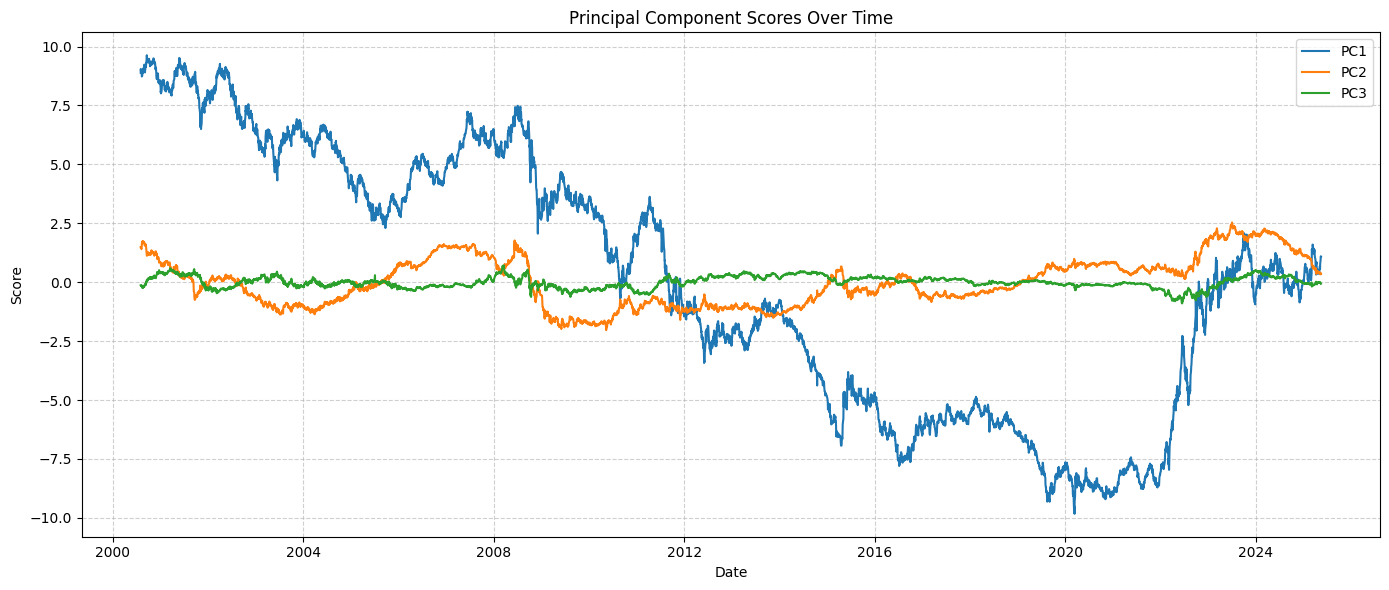

In [43]:
# Create DataFrame with component scores and dates
pca_scores_df = pd.DataFrame(principal_components, columns=["PC1", "PC2", "PC3"])
pca_scores_df["Date"] = pca_df["Date"].values

# Plot PC1 (level), PC2 (slope), PC3 (curvature) over time
plt.figure(figsize=(14, 6))
for i, pc in enumerate(["PC1", "PC2", "PC3"], 1):
    plt.plot(pca_scores_df["Date"], pca_scores_df[pc], label=pc)

plt.title("Principal Component Scores Over Time")
plt.xlabel("Date")
plt.ylabel("Score")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


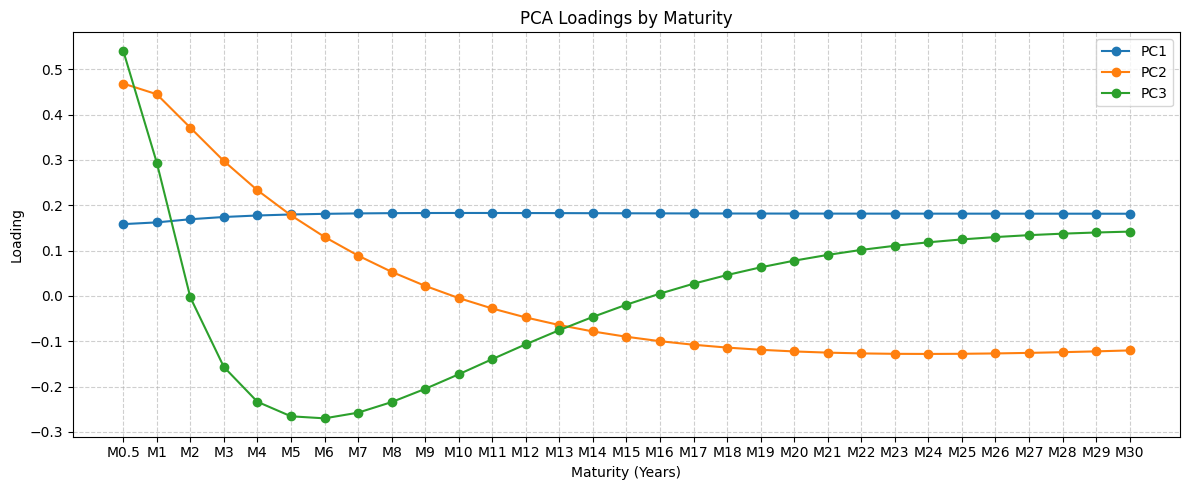

In [44]:
# Loadings: influence of each maturity on each component
loadings = pd.DataFrame(pca.components_.T, index=maturity_cols, columns=["PC1", "PC2", "PC3"])

# Plot each component
plt.figure(figsize=(12, 5))
for i, pc in enumerate(["PC1", "PC2", "PC3"], 1):
    plt.plot(loadings.index, loadings[pc], marker='o', label=pc)

plt.title("PCA Loadings by Maturity")
plt.xlabel("Maturity (Years)")
plt.ylabel("Loading")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


PC1 loadings all same sign → parallel shift

PC2 loadings change sign → slope (short vs. long)

PC3 has 3 sign changes → curvature (hump/dip)

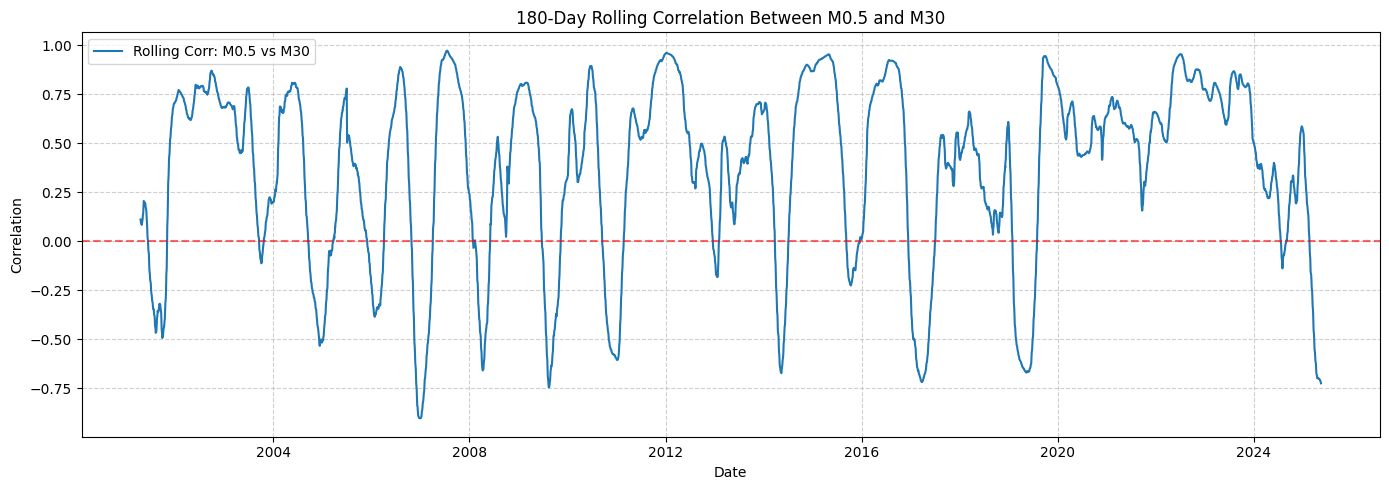

In [45]:
# Pick two maturities to compare
short_col = "M0.5"
long_col = "M30"  # Change to M30.0 if preferred

# Drop rows where either is missing
pair_df = merged_df[["Date", short_col, long_col]].dropna().copy()

# Set rolling window size
window = 180  # roughly 6 months

# Calculate rolling correlation
rolling_corr = pair_df[short_col].rolling(window).corr(pair_df[long_col])

# Plot
plt.figure(figsize=(14, 5))
plt.plot(pair_df["Date"], rolling_corr, label=f"Rolling Corr: {short_col} vs {long_col}")
plt.axhline(0, color='red', linestyle='--', alpha=0.6)
plt.title(f"{window}-Day Rolling Correlation Between {short_col} and {long_col}")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend()
plt.show()

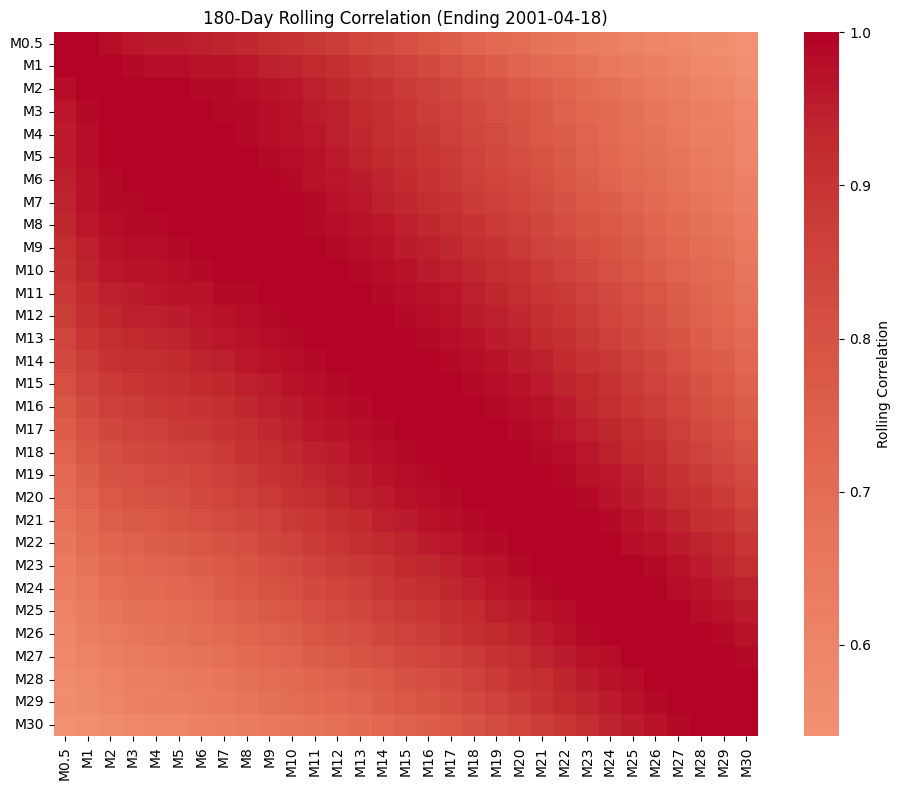

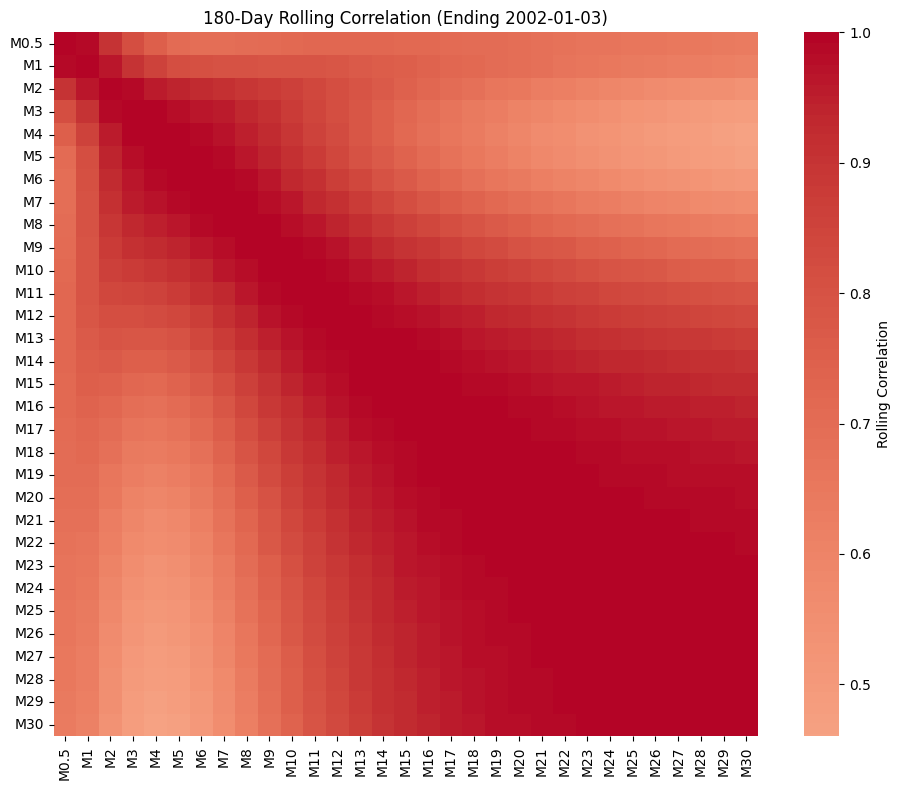

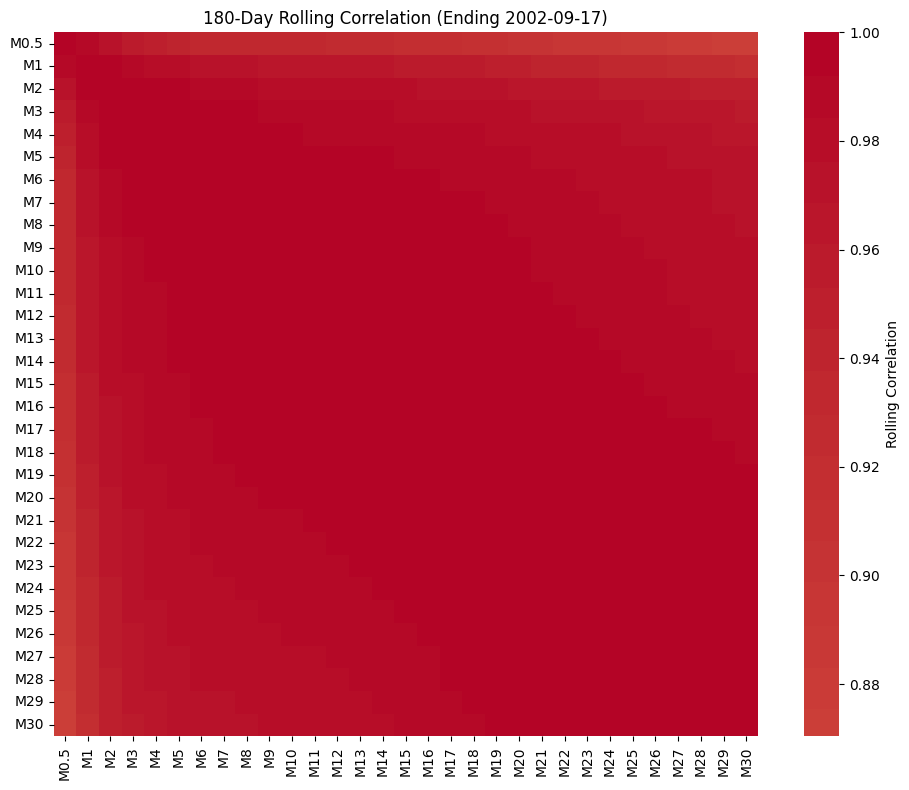

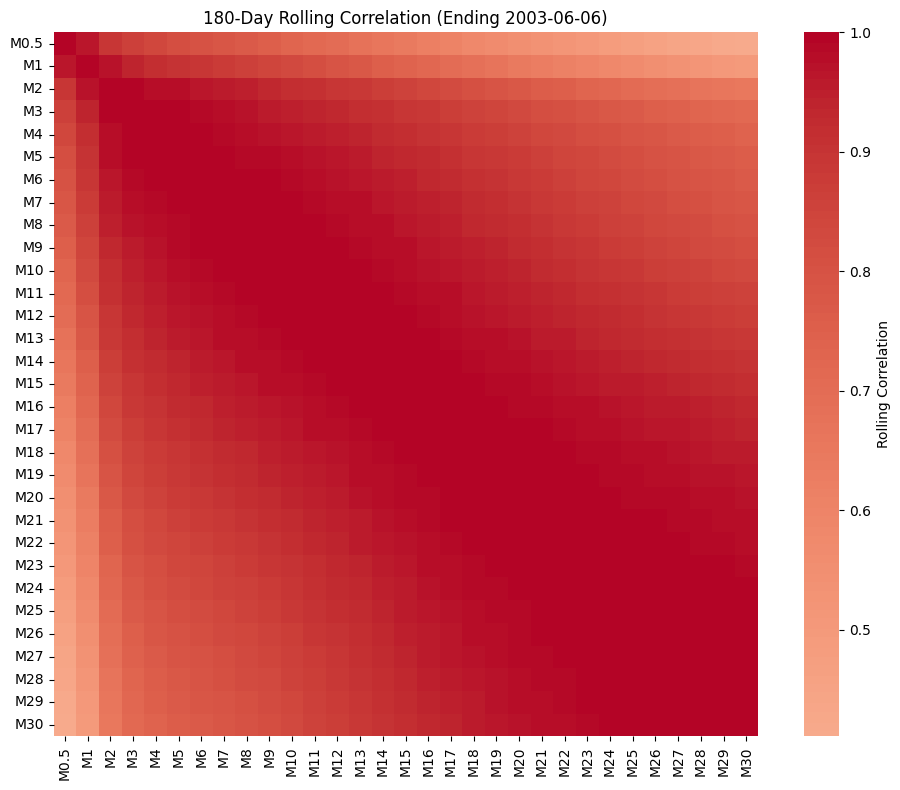

In [46]:
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Ensure consistent maturity column names (e.g., 'M0.5', 'M10.0')
merged_df = merged_df.rename(columns={
    col: f"{col}" if col.startswith("M") and "." not in col else col
    for col in merged_df.columns if col != 'Date'
})

# Step 2: Filter usable maturity columns
maturity_cols = [col for col in merged_df.columns if col.startswith('M')]
rolling_corr_window = 180  # ~6 months

# Step 3: Prepare rolling correlation matrix storage
rolling_corr_matrices = []

# Step 4: Drop rows with any missing values in maturity columns
rolling_df = merged_df[['Date'] + maturity_cols].dropna().copy()
rolling_df.set_index('Date', inplace=True)

# Step 5: Compute rolling correlations at fixed intervals (e.g., yearly snapshots)
date_index = rolling_df.index
snapshots = date_index[::180]  # every 180th day (approx yearly)

for snap_date in snapshots:
    end_date = snap_date
    start_date = end_date - pd.Timedelta(days=rolling_corr_window)

    window_df = rolling_df.loc[start_date:end_date]
    if len(window_df) < 30:  # Skip if too few data points
        continue

    corr_matrix = window_df.corr()
    rolling_corr_matrices.append((end_date.strftime("%Y-%m-%d"), corr_matrix))

# Step 6: Plot a few key rolling correlation heatmaps
for date_label, matrix in rolling_corr_matrices[:4]:  # plot first 4
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, cmap="coolwarm", center=0, annot=False, square=True,
                cbar_kws={"label": "Rolling Correlation"})
    plt.title(f"{rolling_corr_window}-Day Rolling Correlation (Ending {date_label})")
    plt.tight_layout()
    plt.show()


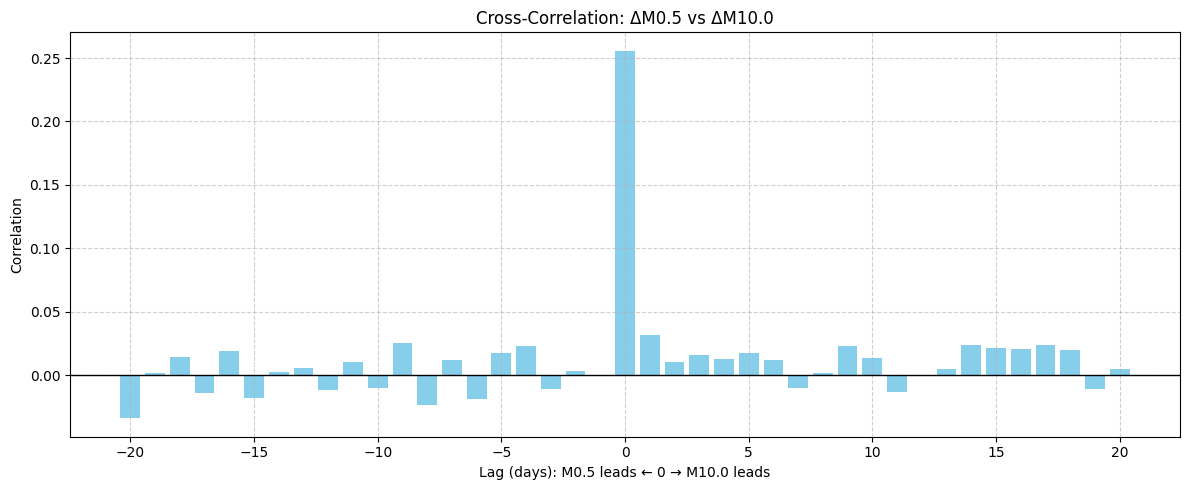

In [47]:
from statsmodels.tsa.stattools import ccf
import numpy as np

# Prepare time-aligned and detrended data
lead_lag_df = merged_df[["Date", "M0.5", "M10"]].dropna().copy()
short_rates = lead_lag_df["M0.5"].diff().dropna()
long_rates = lead_lag_df["M10"].diff().dropna()

# Align lengths
min_len = min(len(short_rates), len(long_rates))
short_rates = short_rates[-min_len:]
long_rates = long_rates[-min_len:]

# Compute cross-correlation (lags from -20 to +20)
max_lag = 20
lags = np.arange(-max_lag, max_lag + 1)
cc_values = [short_rates.shift(-lag).corr(long_rates) for lag in lags]

# Plot
plt.figure(figsize=(12, 5))
plt.bar(lags, cc_values, width=0.8, color='skyblue')
plt.axhline(0, color='black', linewidth=1)
plt.title("Cross-Correlation: ΔM0.5 vs ΔM10.0")
plt.xlabel("Lag (days): M0.5 leads ← 0 → M10.0 leads")
plt.ylabel("Correlation")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [48]:
from statsmodels.tsa.stattools import grangercausalitytests

# Prepare the same differenced data
gc_df = lead_lag_df[["M0.5", "M10"]].dropna().diff().dropna()

# Test if M0.5 helps predict M10.0
print("M0.5 → M10.0")
grangercausalitytests(gc_df[["M10", "M0.5"]], maxlag=5, verbose=True)

# Test if M10.0 helps predict M0.5
print("\nM10.0 → M0.5")
grangercausalitytests(gc_df[["M0.5", "M10"]], maxlag=5, verbose=True)

M0.5 → M10.0

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2768  , p=0.2585  , df_denom=7065, df_num=1
ssr based chi2 test:   chi2=1.2773  , p=0.2584  , df=1
likelihood ratio test: chi2=1.2772  , p=0.2584  , df=1
parameter F test:         F=1.2768  , p=0.2585  , df_denom=7065, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6457  , p=0.5243  , df_denom=7062, df_num=2
ssr based chi2 test:   chi2=1.2924  , p=0.5240  , df=2
likelihood ratio test: chi2=1.2923  , p=0.5241  , df=2
parameter F test:         F=0.6457  , p=0.5243  , df_denom=7062, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6166  , p=0.6042  , df_denom=7059, df_num=3
ssr based chi2 test:   chi2=1.8517  , p=0.6038  , df=3
likelihood ratio test: chi2=1.8515  , p=0.6038  , df=3
parameter F test:         F=0.6166  , p=0.6042  , df_denom=7059, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{np.int64(1): ({'ssr_ftest': (np.float64(14.134079599542712),
    np.float64(0.00017160523289051646),
    np.float64(7065.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(14.140081331856745),
    np.float64(0.0001696893932059326),
    np.int64(1)),
   'lrtest': (np.float64(14.125956004078034),
    np.float64(0.00017096832141846744),
    np.int64(1)),
   'params_ftest': (np.float64(14.134079599539488),
    np.float64(0.0001716052328908707),
    np.float64(7065.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(6.9979493716163015),
    np.float64(0.0009201038255155292),
    np.float64(7062.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(14.005808045656302),
    np.float64(0.0009092376808998147),
    np.int64(2)),
   'lrtest': (np.float64(13.991947576876555),
    np.float64(0.0009155607961727402),
    np.int64(2)),
   'params_ftest': (np.float64(6.997949371611716),
    np.float64(0.0009201038255195131),
    np.float64(7062.0),
    2.0)},
   array(

In [49]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, label):
    result = adfuller(series.dropna())
    print(f"ADF Test for {label}")
    print(f"  Test Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    print(f"  Stationary? {'Yes' if result[1] < 0.05 else 'No'}\n")

# Run for selected maturities
for maturity in ["M0.5", "M5", "M10", "M30"]:
    series = merged_df[maturity]
    adf_test(series, maturity)

ADF Test for M0.5
  Test Statistic: -1.5393
  p-value: 0.5140
  Stationary? No

ADF Test for M5
  Test Statistic: -1.5865
  p-value: 0.4904
  Stationary? No

ADF Test for M10
  Test Statistic: -1.7659
  p-value: 0.3975
  Stationary? No

ADF Test for M30
  Test Statistic: -1.4591
  p-value: 0.5536
  Stationary? No



In [50]:
def hurst_exponent(ts):
    lags = range(2, 100)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    hurst, _ = np.polyfit(np.log(lags), np.log(tau), 1)
    return hurst

print("Hurst Exponent:")
for maturity in ["M0.5", "M5", "M10", "M30"]:
    h = hurst_exponent(merged_df[maturity].dropna().values)
    desc = (
        "Mean-Reverting (<0.5)" if h < 0.5 else
        "Random Walk (~0.5)" if np.isclose(h, 0.5, atol=0.05) else
        "Trending (>0.5)"
    )
    print(f"  {maturity}: H = {h:.4f} → {desc}")

Hurst Exponent:
  M0.5: H = 0.3295 → Mean-Reverting (<0.5)
  M5: H = 0.2630 → Mean-Reverting (<0.5)
  M10: H = 0.2472 → Mean-Reverting (<0.5)
  M30: H = 0.2244 → Mean-Reverting (<0.5)


In [51]:
import statsmodels.api as sm

print("\nAR(1) Coefficients:")
for maturity in ["M0.5", "M5", "M10", "M30"]:
    ts = merged_df[maturity].dropna()
    ts_diff = ts.diff().dropna()
    ts_lag = ts.shift(1).dropna().reindex(ts_diff.index)
    model = sm.OLS(ts_diff, sm.add_constant(ts_lag)).fit()
    coef = model.params[1]
    print(f"  {maturity}: AR(1) coef = {coef:.4f} {'← stronger mean reversion' if coef < 0 else ''}")


AR(1) Coefficients:
  M0.5: AR(1) coef = -0.0002 ← stronger mean reversion
  M5: AR(1) coef = -0.0005 ← stronger mean reversion
  M10: AR(1) coef = -0.0005 ← stronger mean reversion
  M30: AR(1) coef = -0.0006 ← stronger mean reversion


<ipython-input-51-edd2e50ba9b1>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = model.params[1]
<ipython-input-51-edd2e50ba9b1>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = model.params[1]
<ipython-input-51-edd2e50ba9b1>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = model.params[1]
<ipython-input-51-edd2e50ba9b1>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future v

| Metric           | What to Look For             |
| ---------------- | ---------------------------- |
| **ADF p < 0.05** | Stationary (mean-reverting)  |
| **Hurst < 0.5**  | Mean-reverting               |
| **AR(1) < 0**    | Pull back toward equilibrium |

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 13.1 MB/s eta 0:00:00
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   M0.5   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -16328.0
Distribution:                  Normal   AIC:                           32664.0
Method:            Maximum Likelihood   BIC:                           32691.4
                                        No. Observations:                 7069
Date:                Thu, May 29 2025   Df Residuals:                     7068
Time:                        12:31:12   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
----------------------------------------------------

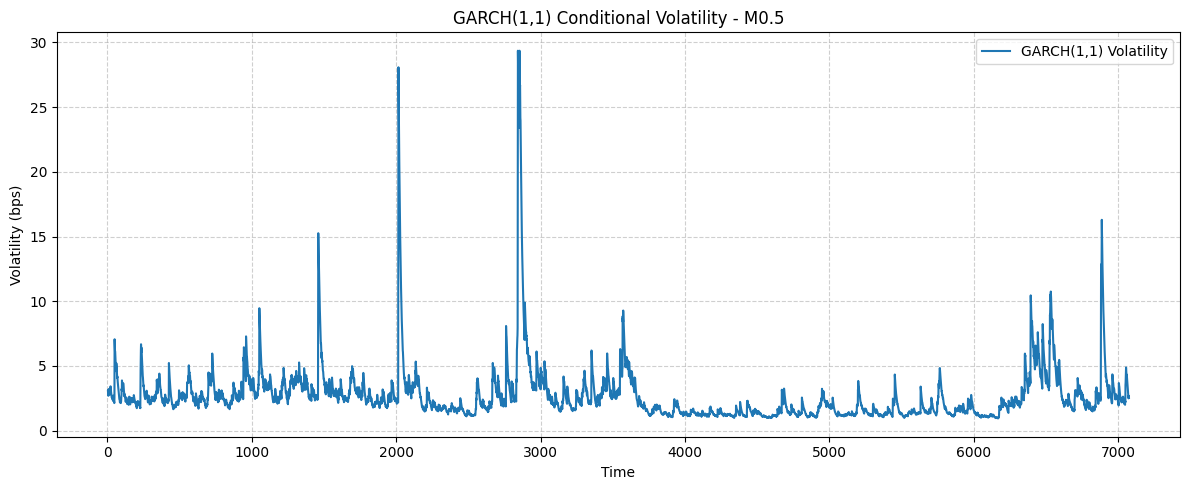

In [52]:
!pip install arch

from arch import arch_model
import matplotlib.pyplot as plt

# Use short-end rates as an example
maturity = "M0.5"
series = merged_df[maturity].dropna()
returns = series.diff().dropna() * 100  # convert to basis points for stability

# Fit GARCH(1,1)
model = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = model.fit(disp='off')

# Summary
print(garch_fit.summary())

# Plot conditional volatility
plt.figure(figsize=(12, 5))
plt.plot(garch_fit.conditional_volatility, label='GARCH(1,1) Volatility')
plt.title(f"GARCH(1,1) Conditional Volatility - {maturity}")
plt.xlabel("Time")
plt.ylabel("Volatility (bps)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend()
plt.show()

Interpretation:
Significant α (ARCH) → short-term shocks affect volatility.

Significant β (GARCH) → volatility persistence (clustering).

High α + β (close to 1) → long memory in volatility.


====== GARCH(1,1) Analysis for M10 ======
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    M10   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -20600.2
Distribution:                  Normal   AIC:                           41208.4
Method:            Maximum Likelihood   BIC:                           41235.8
                                        No. Observations:                 7069
Date:                Thu, May 29 2025   Df Residuals:                     7068
Time:                        12:33:23   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.0652

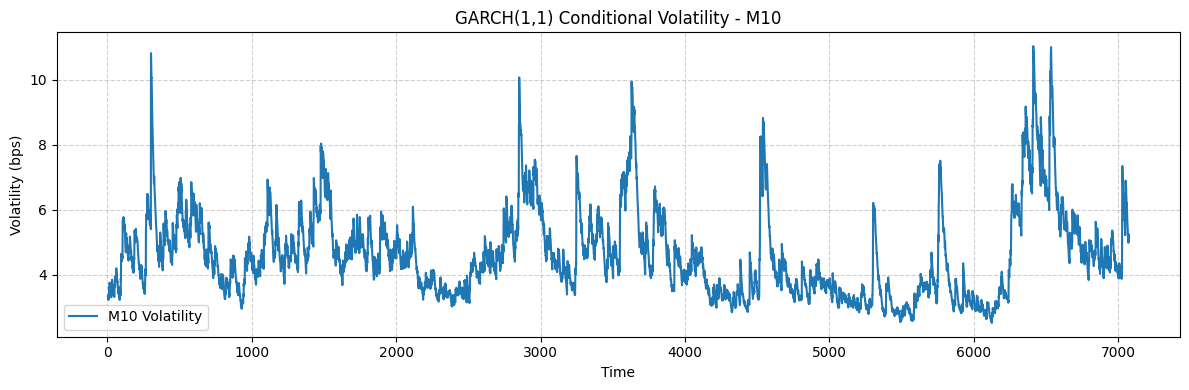


====== GARCH(1,1) Analysis for M30 ======
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    M30   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -18904.0
Distribution:                  Normal   AIC:                           37816.0
Method:            Maximum Likelihood   BIC:                           37843.0
                                        No. Observations:                 6309
Date:                Thu, May 29 2025   Df Residuals:                     6308
Time:                        12:33:24   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.0356

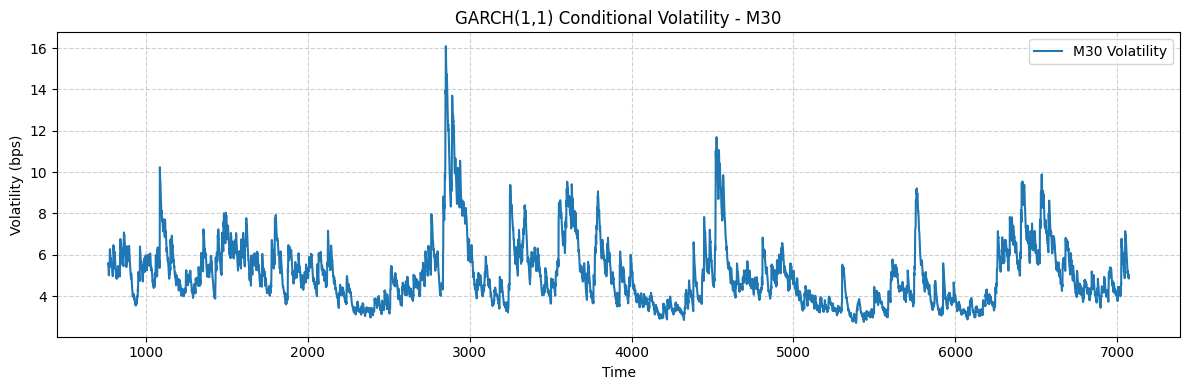

In [57]:
from arch import arch_model
import matplotlib.pyplot as plt

# Define maturities to test
for maturity in ["M10", "M30"]:
    print(f"\n====== GARCH(1,1) Analysis for {maturity} ======")

    # Get cleaned returns in basis points
    series = merged_df[maturity].dropna()
    returns = series.diff().dropna() * 100  # use bps for stability

    # Fit GARCH(1,1)
    model = arch_model(returns, vol='Garch', p=1, q=1)
    garch_fit = model.fit(disp='off')

    # Summary of results
    print(garch_fit.summary())

    # Plot conditional volatility
    plt.figure(figsize=(12, 4))
    plt.plot(garch_fit.conditional_volatility, label=f'{maturity} Volatility')
    plt.title(f"GARCH(1,1) Conditional Volatility - {maturity}")
    plt.xlabel("Time")
    plt.ylabel("Volatility (bps)")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


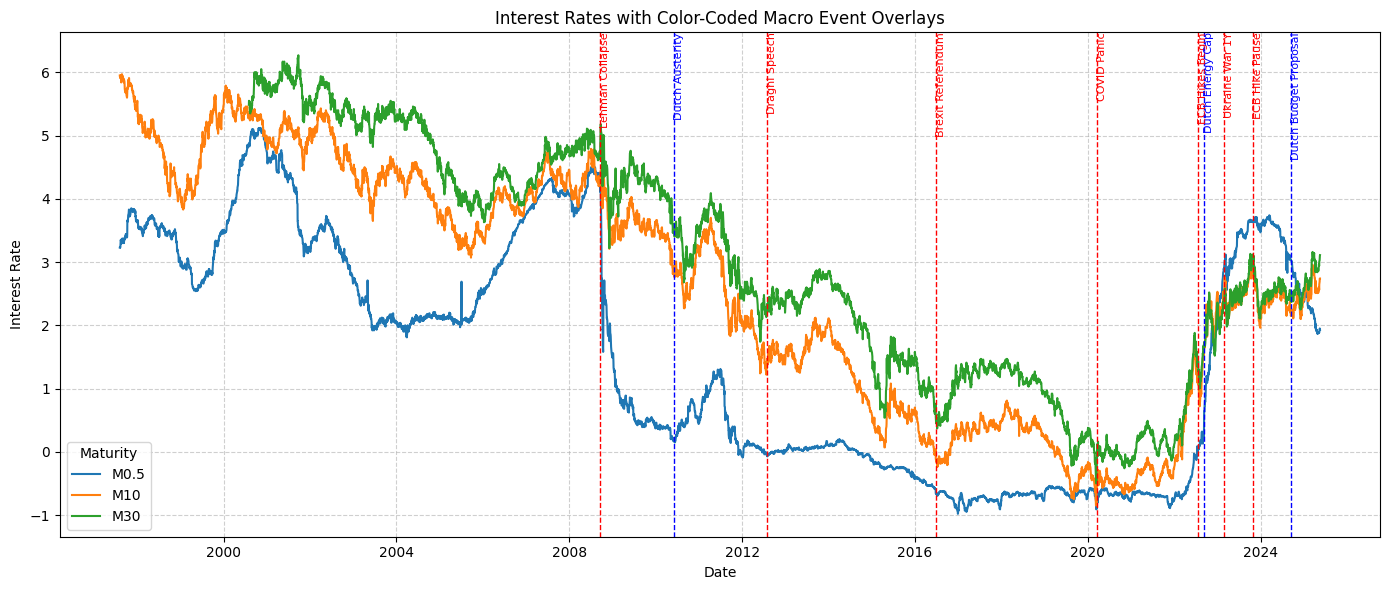

In [54]:
# Define categorized events
event_dict = {
    "global": {
        "Lehman Collapse": "2008-09-15",
        "Draghi Speech": "2012-07-26",
        "Brexit Referendum": "2016-06-24",
        "COVID Panic": "2020-03-16",
        "ECB Hikes Begin": "2022-07-21",
        "Ukraine War 1Y": "2023-02-24",
        "ECB Hike Pause": "2023-10-26"
    },
    "dutch": {
        "Dutch Austerity": "2010-06-01",
        "Dutch Energy Cap": "2022-09-06",
        "Dutch Budget Proposal": "2024-09-15"
    }
}

# Plot selected maturities
plt.figure(figsize=(14, 6))
for mat in ["M0.5", "M10", "M30"]:
    plt.plot(merged_df["Date"], merged_df[mat], label=mat)

# Plot global events (red)
for label, date in event_dict["global"].items():
    date_obj = pd.to_datetime(date)
    plt.axvline(date_obj, color='red', linestyle='--', linewidth=1)
    plt.text(date_obj, plt.ylim()[1], label, rotation=90,
             verticalalignment='top', fontsize=8, color='red')

# Plot Dutch events (blue)
for label, date in event_dict["dutch"].items():
    date_obj = pd.to_datetime(date)
    plt.axvline(date_obj, color='blue', linestyle='--', linewidth=1)
    plt.text(date_obj, plt.ylim()[1], label, rotation=90,
             verticalalignment='top', fontsize=8, color='blue')

plt.title("Interest Rates with Color-Coded Macro Event Overlays")
plt.xlabel("Date")
plt.ylabel("Interest Rate")
plt.legend(title="Maturity")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

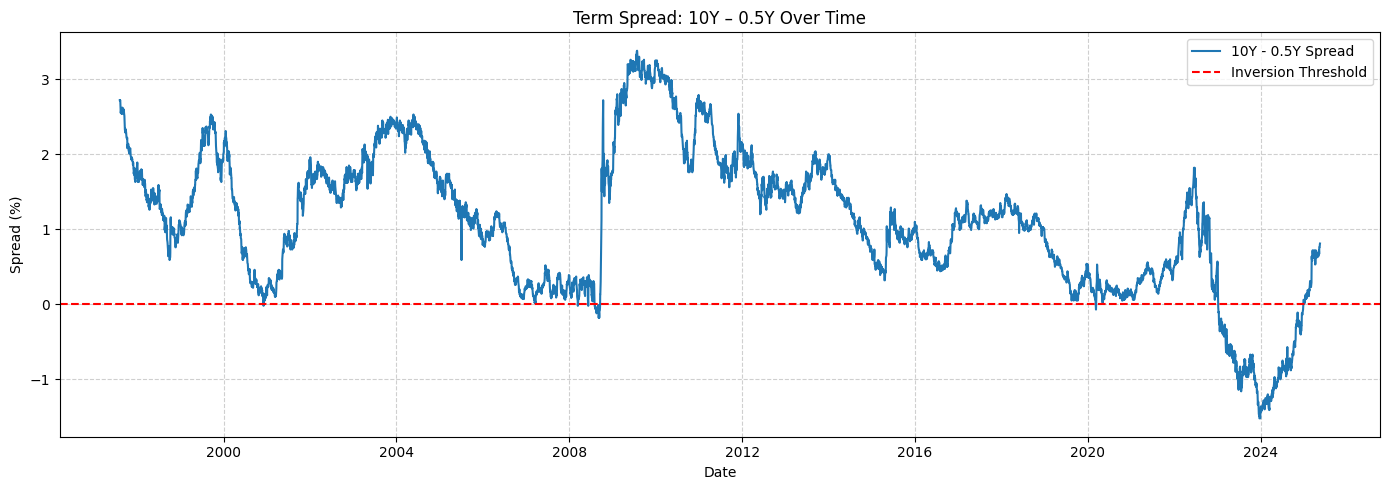

In [55]:
# Compute 10Y – 0.5Y spread
merged_df["TermSpread_10Y_0.5Y"] = merged_df["M10"] - merged_df["M0.5"]

# Plot the spread
plt.figure(figsize=(14, 5))
plt.plot(merged_df["Date"], merged_df["TermSpread_10Y_0.5Y"], label="10Y - 0.5Y Spread")
plt.axhline(0, color='red', linestyle='--', label="Inversion Threshold")
plt.title("Term Spread: 10Y – 0.5Y Over Time")
plt.xlabel("Date")
plt.ylabel("Spread (%)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [56]:
# Compare mean and std for selected maturities
summary = []
for mat in ["M0.5", "M5", "M10"]:
    raw_mean = merged_df[mat].mean()
    interp_mean = interpolated_df[mat].mean()
    raw_std = merged_df[mat].std()
    interp_std = interpolated_df[mat].std()
    summary.append((mat, raw_mean, interp_mean, raw_std, interp_std))

# Create DataFrame
summary_df = pd.DataFrame(summary, columns=[
    "Maturity", "Raw Mean", "Interpolated Mean", "Raw Std", "Interpolated Std"
])

# Display results
print("\n📊 Missing Data Impact Summary:\n")
print(summary_df.round(4))

NameError: name 'interpolated_df' is not defined

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Drop missing data
clustering_df = merged_df[maturity_cols].dropna()

# Standardize data
scaler = StandardScaler()
X = scaler.fit_transform(clustering_df)

# Fit k-means with fewer clusters
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(X)

# Add labels to DataFrame
clustering_df = clustering_df.copy()
clustering_df["Date"] = merged_df["Date"].loc[clustering_df.index]
clustering_df["Cluster"] = labels

# Plot cluster membership over time
plt.figure(figsize=(14, 4))
plt.scatter(clustering_df["Date"], clustering_df["Cluster"], c=labels, cmap='Accent', s=10)
plt.title(f"Yield Curve Regimes Over Time ({n_clusters} Clusters)")
plt.xlabel("Date")
plt.ylabel("Cluster")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Plot cluster centroids as yield curves
centroids = kmeans.cluster_centers_
centroids_unscaled = scaler.inverse_transform(centroids)

plt.figure(figsize=(10, 6))
for i, curve in enumerate(centroids_unscaled):
    plt.plot(maturity_cols, curve, label=f"Cluster {i}")
plt.title("Typical Yield Curve Shapes (Cluster Centroids)")
plt.xlabel("Maturity")
plt.ylabel("Interest Rate (%)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [ ]:
# After inspecting the centroid curves visually:
cluster_labels = {
    0: "Inverted",
    1: "Flat",
    2: "Normal Upward",
    3: "Steep",
    4: "Humped",
    5: "Tight Mid-Curve"
}

# Add named labels
clustering_df["Cluster Label"] = clustering_df["Cluster"].map(cluster_labels)

In [ ]:
# Filter all inverted yield curve dates
inverted_dates = clustering_df[clustering_df["Cluster Label"] == "Inverted"][["Date"]]
print("\n🗓️ Inverted Yield Curve Dates:\n")
print(inverted_dates.head(10))  # show first 10

# Count by year for frequency
clustering_df["Year"] = pd.to_datetime(clustering_df["Date"]).dt.year
regime_counts = clustering_df.groupby(["Year", "Cluster Label"]).size().unstack().fillna(0)
print("\n📊 Cluster Frequencies Per Year:\n")
print(regime_counts)

Inversion Regimes are Detectable and Rare:

- Use this to justify stress scenario selection based on empirical frequency.

Regime Transitions Are Periodic and Interpretable:

- Could use clusters to calibrate multi-regime models or regime-switching VaR.

Cluster Labels Provide a Risk-Based Narrative:

- “Flat in 2020–2021” tells a different story than “Inverted in 2009”.

In [ ]:
clustering_df.groupby("Cluster Label")[maturity_cols].std()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Set up
fig, ax = plt.subplots(figsize=(16, 6))

# Plot the 10Y rate
ax.plot(clustering_df["Date"], clustering_df["M10"], label="10Y Interest Rate", color="black", linewidth=1.5)

# Define cluster color map manually (adjust if needed)
regime_colors = {
    "Inverted": "#e74c3c",         # Red
    "Flat": "#f39c12",             # Orange
    "Normal Upward": "#27ae60",    # Green
    "Steep": "#2980b9",            # Blue
    "Humped": "#8e44ad",           # Purple
    "Tight Mid-Curve": "#7f8c8d"   # Gray
}

# Plot background color for each regime
for label, color in regime_colors.items():
    mask = clustering_df["Cluster Label"] == label
    ax.fill_between(clustering_df["Date"], clustering_df["M10"].min(), clustering_df["M10"].max(),
                    where=mask, color=color, alpha=0.15, label=label)

# Final plot tweaks
ax.set_title("10Y Interest Rate with Yield Curve Regime Backgrounds")
ax.set_xlabel("Date")
ax.set_ylabel("Interest Rate (%)")
ax.grid(True, linestyle='--', alpha=0.5)

# Legend (just one label per color)
handles = [mpatches.Patch(color=color, label=label) for label, color in regime_colors.items()]
ax.legend(handles=handles, title="Yield Curve Regimes", loc="upper right")

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Define macro events
event_dict = {
    "global": {
        "Lehman Collapse": "2008-09-15",
        "Draghi Speech": "2012-07-26",
        "Brexit Referendum": "2016-06-24",
        "COVID Panic": "2020-03-16",
        "ECB Hikes Begin": "2022-07-21",
        "Ukraine War 1Y": "2023-02-24",
        "ECB Hike Pause": "2023-10-26"
    },
    "dutch": {
        "Dutch Austerity": "2010-06-01",
        "Dutch Energy Cap": "2022-09-06",
        "Dutch Budget Proposal": "2024-09-15"
    }
}

# Define regime colors
regime_colors = {
    "Inverted": "#e74c3c",         # Red
    "Flat": "#f39c12",             # Orange
    "Normal Upward": "#27ae60",    # Green
    "Steep": "#2980b9",            # Blue
    "Humped": "#8e44ad",           # Purple
    "Tight Mid-Curve": "#7f8c8d"   # Gray
}

# Set up plot
fig, ax = plt.subplots(figsize=(16, 6))

# Plot 10Y interest rate
ax.plot(clustering_df["Date"], clustering_df["M10"], label="10Y Interest Rate", color="black", linewidth=1.5)

# Plot regime background colors
for label, color in regime_colors.items():
    mask = clustering_df["Cluster Label"] == label
    ax.fill_between(clustering_df["Date"], clustering_df["M10"].min(), clustering_df["M10"].max(),
                    where=mask, color=color, alpha=0.15)

# Overlay macro events (global - red, dutch - blue)
for label, date in event_dict["global"].items():
    date_obj = pd.to_datetime(date)
    ax.axvline(date_obj, color='red', linestyle='--', linewidth=1)
    ax.text(date_obj, clustering_df["M10"].max(), label, rotation=90,
            verticalalignment='top', fontsize=8, color='red')

for label, date in event_dict["dutch"].items():
    date_obj = pd.to_datetime(date)
    ax.axvline(date_obj, color='blue', linestyle='--', linewidth=1)
    ax.text(date_obj, clustering_df["M10"].max(), label, rotation=90,
            verticalalignment='top', fontsize=8, color='blue')

# Final formatting
ax.set_title("10Y Interest Rate with Yield Curve Regimes and Macro Events")
ax.set_xlabel("Date")
ax.set_ylabel("Interest Rate (%)")
ax.grid(True, linestyle='--', alpha=0.5)

# Add custom legend
regime_handles = [mpatches.Patch(color=color, label=label) for label, color in regime_colors.items()]
macro_handles = [
    mpatches.Patch(color="red", label="Global Event"),
    mpatches.Patch(color="blue", label="Dutch Event")
]
ax.legend(handles=regime_handles + macro_handles, loc="upper right", title="Legend")

plt.tight_layout()
plt.show()


# EGON DRAFT TESTS END